In [1]:
# imports
import pandas as pd
import numpy as np
from scipy import stats
import math
import sys
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.metrics import precision_recall_fscore_support
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report
from sklearn.tree import export_graphviz
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import validation_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import make_scorer, recall_score, accuracy_score
import pydot
from IPython.display import Image
from hyperopt import hp
from vecstack import stacking

In [2]:
#Features Importance
def compute_feature_importance(voting_clf, features, weights):
    """ Function to compute feature importance of Voting Classifier """
    
    feature_importance = dict()
    for est in voting_clf.estimators_:
        if hasattr(est, 'feature_importances_'):
            feature_importance[str(est)] = est.feature_importances_
    
    fe_scores = [0]*len(list(feature_importance.values())[0])
    for idx, imp_score in enumerate(feature_importance.values()):
        imp_score_with_weight = imp_score*weights[idx]
        fe_scores = list(np.add(fe_scores, list(imp_score_with_weight)))
        
    df_importace = pd.DataFrame()
    df_importace['Feature'] = features.columns
    df_importace['Feature Importance'] = fe_scores
    print(df_importace.sort_values('Feature Importance', ascending=False))

    feats = {} # a dict to hold feature_name: feature_importance
    for feature, importance in zip(features.columns, fe_scores):
        feats[feature] = importance #add the name/value pair 

    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'importance'})
    importances.sort_values(by='importance').plot(kind='bar', grid=True, figsize=(18,9))

In [3]:
#Features coef
def compute_feature_coef(voting_clf, features, weights):
    """ Function to compute coef of Voting Classifier """
    
    feature_importance = dict()
    for est in voting_clf.estimators_:
        if hasattr(est, 'coef_'):
            feature_importance[str(est)] = np.reshape(est.coef_, features.columns.size)
    
    fe_scores = [0]*len(list(feature_importance.values())[0])
    for idx, imp_score in enumerate(feature_importance.values()):
        imp_score_with_weight = imp_score*weights[idx]
        fe_scores = list(np.add(fe_scores, list(imp_score_with_weight)))
            
    df_importace = pd.DataFrame()
    df_importace['Feature'] = features.columns
    df_importace['Feature Importance'] = fe_scores
    print(df_importace.sort_values('Feature Importance', ascending=False))

    feats = {} # a dict to hold feature_name: feature_importance
    for feature, importance in zip(features.columns, fe_scores):
        feats[feature] = importance #add the name/value pair 

    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'coef'})
    importances.sort_values(by='coef').plot(kind='bar', grid=True, figsize=(18,9))

In [4]:
#Model Scores
def voting_model_scores(voting_clf, X_test, Y_test):
    """ Function to compute scores of models of Voting Classifier """
    plt.figure(figsize=(10, 10))
    j = 0
    for est in voting_clf.estimators_: 
        # Predict using model
        y_predict = est.predict(X_test)
    
        print(est)
        print("Accuracy:", accuracy_score(Y_test,y_predict))
        plot_confusion_matrix(est,X_test,Y_test)
        # performances
        target_names = ['SLA', 'Violation']
        print(classification_report(Y_test, y_predict, target_names=target_names))

In [5]:
def predictResults(model, x, y, y_predict):
    
    # Predict the values by using all test data
    if isinstance(y_predict, int):
        if (y_predict == 0):
            y_predict = model.predict(x)
    plot_confusion_matrix(model, x, y)
    # performances
    target_names = ['SLA', 'Violation']
    print(classification_report(y, y_predict, target_names=target_names))
    # Calculate the score of the model in test data
    print("Accuracy: ", accuracy_score(y, y_predict))
    # Calculate mean squared error of predicted values
    mse=mean_squared_error(y,y_predict)
    rmse = np.sqrt(mse)
    print("MSE:", mse)
    print("RMSE:", rmse)
    r2 = r2_score(y, y_predict)
    print("R2:", r2)
    # Calculate absolute squared error of predicted values
    mea=mean_absolute_error(y, y_predict)
    print("MEA:", mea)

In [6]:
# Hyperparameter Optimization With Grid Search
def gridSearch(model, parameter_space, x, y, refitType):
    # define model
    print("Start: ", datetime.now())
    #model = MLPClassifier()
    # define evaluation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
    # define search space
    # define search space
    #parameter_space = {
    #    'max_iter': range(200, 2001, 100),
    #    'random_state': [0],
    #    'hidden_layer_sizes': [(100,)], #[(100,)], #[(50, 50, 50), (50, 100, 50), (100,)],
    #    'activation': ['relu'], #['tanh'], #['identity', 'logistic', 'tanh', 'relu'],
    #    'solver': ['lbfgs'], #['sgd'], #['lbfgs', 'sgd', 'adam'],
    #    'alpha': [0.01], #[0.01], #[0.0001, 0.001, 0.01, 0.05],
    #    'learning_rate': ['invscaling'] #['constant'], #['constant', 'invscaling', 'adaptive'],
    #}

    acc = make_scorer(accuracy_score)
    recall = make_scorer(recall_score)
    scoring = { "recall": recall, "accuracy": acc }

    search = GridSearchCV(model, parameter_space, scoring=scoring, n_jobs=-1, cv=cv, refit=refitType)
    # execute search
    result = search.fit(x, y)
    # summarize result
    print('Best Score: %s' % result.best_score_)
    print('Best Hyperparameters: %s' % result.best_params_)

    print("End: ", datetime.now())

    # All results
    means = result.cv_results_['mean_test_accuracy']
    stds = result.cv_results_['mean_test_recall']
    for mean, std, params in zip(means, stds, result.cv_results_['params']):
        print("%0.3f %0.3f for %r" % (mean, std, params))

In [7]:
# Hyperparameter Optimization With Randomized Search
def randomSearch(model, parameter_space, x, y, refitType, nIter):
    # define model
    print("Start: ", datetime.now())
    #model = MLPClassifier()
    # define evaluation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)

    # define search space
    #parameter_space = {
    #    #'max_iter': [300],
    #    'random_state': [0],
    #    'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (100,)],
    #    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    #    'solver': ['lbfgs', 'sgd', 'adam'],
    #    'alpha': [0.0001, 0.001, 0.01, 0.05],
    #    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    #}

    acc = make_scorer(accuracy_score)
    recall = make_scorer(recall_score)
    scoring = { "recall": recall, "accuracy": acc }

    # define search
    search = RandomizedSearchCV(model, parameter_space, n_iter=nIter, scoring=scoring, n_jobs=-1, cv=cv, random_state=0, refit=refitType)
    # execute search
    result = search.fit(x, y)
    # summarize result
    print('Best Score: %s' % result.best_score_)
    print('Best Hyperparameters: %s' % result.best_params_)

    print("End: ", datetime.now())
    # All results
    means = result.cv_results_['mean_test_accuracy']
    stds = result.cv_results_['mean_test_recall']
    for mean, std, params in zip(means, stds, result.cv_results_['params']):
        print("%0.3f %0.3f for %r" % (mean, std, params))

In [8]:
#########################
#blending ensemble
#########################

In [9]:
# fit the blending ensemble
def fit_ensemble(models, X_train, X_val, y_train, y_val, blender):
    # fit all models on the training set and predict on hold out set
    meta_X = list()
    for name, model in models:
        # fit in training set
        model.fit(X_train, y_train)
        # predict on hold out set
        yhat = model.predict(X_val)
        # reshape predictions into a matrix with one column
        yhat = yhat.reshape(len(yhat), 1)
        # store predictions as input for blending
        meta_X.append(yhat)
    # create 2d array from predictions, each set is an input feature
    meta_X = np.hstack(meta_X)
    # fit on predictions from base models
    blender.fit(meta_X, y_val)
    return blender

In [10]:
# make a prediction with the blending ensemble
def predict_ensemble(models, blender, X_test):
    # make predictions with base models
    meta_X = list()
    for name, model in models:
        # predict with base model
        yhat = model.predict(X_test)
        # reshape predictions into a matrix with one column
        yhat = yhat.reshape(len(yhat), 1)
        # store prediction
        meta_X.append(yhat)
    # create 2d array from predictions, each set is an input feature
    meta_X = np.hstack(meta_X)
    # predict
    return meta_X, blender.predict(meta_X)

In [11]:
#define best models
def getStkModels():
    models = list()
    models.append(RandomForestClassifier(random_state=0, n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features='auto', max_depth= 10, criterion= 'entropy', bootstrap= False))
    models.append(MLPClassifier(solver= 'sgd', random_state= 0, max_iter= 2000, learning_rate='constant', hidden_layer_sizes=(100,), alpha=0.01, activation='tanh'))
    models.append(LogisticRegression(solver='liblinear', penalty = 'l1', C = 0.01, random_state = 0))    
    models.append(KNeighborsClassifier(weights='uniform', p=2, n_neighbors=19, metric='minkowski', leaf_size=30))
    models.append(SVC(kernel='rbf', gamma = 'scale', C=1, random_state=0, probability=True))
    models.append(XGBClassifier(colsample_bytree=0.5, learning_rate=0.06, max_depth=6, min_child_weight=1, n_estimators=900, random_state=0, subsample=0.9, use_label_encoder=False))
    models.append(LGBMClassifier(boosting_type='dart', class_weight='balanced', importance_type='gain', learning_rate=0.7, max_depth=49, min_child_samples=50, n_estimators=251, num_leaves=7, random_state=0))
    models.append(CatBoostClassifier(random_state=0))
    models.append(HistGradientBoostingClassifier(random_state=0))
    models.append(Perceptron(eta0=0.01, max_iter=1000, random_state=0))
    models.append(GaussianNB(var_smoothing=0.2))
    return models

In [12]:
#define best models
def getModels(isHard):
    models = list()
    models.append(('RFC', RandomForestClassifier(random_state=0, n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features='auto', max_depth= 10, criterion= 'entropy', bootstrap= False)))
    models.append(('MLP', MLPClassifier(solver= 'sgd', random_state= 0, max_iter= 2000, learning_rate='constant', hidden_layer_sizes=(100,), alpha=0.01, activation='tanh')))
    models.append(('LR', LogisticRegression(solver='liblinear', penalty = 'l1', C = 0.01, random_state = 0)))    
    models.append(('KNN', KNeighborsClassifier(weights='uniform', p=2, n_neighbors=19, metric='minkowski', leaf_size=30)))
    models.append(('SVC', SVC(kernel='rbf', gamma = 'scale', C=1, random_state=0, probability=True)))
    models.append(('XGBC', XGBClassifier(colsample_bytree=0.5, learning_rate=0.06, max_depth=6, min_child_weight=1, n_estimators=900, random_state=0, subsample=0.9, use_label_encoder=False)))
    models.append(('LGBMC', LGBMClassifier(boosting_type='dart', class_weight='balanced', importance_type='gain', learning_rate=0.7, max_depth=49, min_child_samples=50, n_estimators=251, num_leaves=7, random_state=0)))
    models.append(('SCAT', CatBoostClassifier(random_state=0)))
    models.append(('HGBC', HistGradientBoostingClassifier(random_state=0)))
    if isHard:
        models.append(('PER', Perceptron(eta0=0.01, max_iter=1000, random_state=0)))
        models.append(('NB', GaussianNB(var_smoothing=0.2)))
    return models

In [13]:
# Read data from file 
df_excel=pd.read_excel('customer_problems_paper.xlsx')

In [14]:
# set data frame 
df=df_excel
df.head()

,ROW,NOTIFYING_CHANNEL,PROBLEM_ID,CFS_ID,CFS_CODE,CFS_NAME,CFS_DESC,CFS_PLAN_ID,CFS_PLAN_CODE,CFS_PLAN,...,CLOSING_TIME,DURATION_MIN,TEAM_CODE,DIRECTORATE_CODE,DIRECTORATE,CITY_CODE,CITY,REGION,EXTRA_OPERATION,RPA
0,1,OLO,2020081200075003100,228,ADSL,ADSL,ADSL,81,DSL_BAKIR,DSL BAKIR,...,14/08/20 10:29:2,2423,332FSAHA11001,1106237.0,EREĞLİ TELEKOM,1106222,KONYA,ANTALYA BÖLGE MÜDÜRLÜĞÜ,1,1
1,2,OLO,2020081200074986685,228,ADSL,ADSL,ADSL,81,DSL_BAKIR,DSL BAKIR,...,17/08/20 15:05:0,6787,232SAHA92016,1105744.0,BOR11A TELEKOM,1008,İZMİR,İZMİR BÖLGE MÜDÜRLÜĞÜ,1,1
2,3,OLO,2020081900075218630,228,ADSL,ADSL,ADSL,81,DSL_BAKIR,DSL BAKIR,...,20/08/20 11:35:1,1294,482FSAHA00016,NaN,NaN,1106127,03DİN,DİYARBAKIR BÖLGE MÜDÜRLÜĞÜ,1,1
3,4,OLO,2020082600075439130,228,ADSL,ADSL,ADSL,81,DSL_BAKIR,DSL BAKIR,...,27/08/20 09:39:5,1296,366FSAHA00866,NaN,NaN,1105602,KASTAMONU,ANKARA BÖLGE MÜDÜRLÜĞÜ,1,1
4,5,OLO,2020090200075743635,228,ADSL,ADSL,ADSL,81,DSL_BAKIR,DSL BAKIR,...,05/09/20 12:45:4,4020,452FSAHA00025,NaN,NaN,1106719,ORDU,SAMSUN BÖLGE MÜDÜRLÜĞÜ,1,1


In [15]:
df.shape

(80346, 32)

In [16]:
# find null values
df.isnull().sum()

ROW                      0
NOTIFYING_CHANNEL        0
PROBLEM_ID               0
CFS_ID                   0
CFS_CODE                 0
CFS_NAME                 0
CFS_DESC                 0
CFS_PLAN_ID              0
CFS_PLAN_CODE            0
CFS_PLAN                 0
WORK_TYPE_ID             0
WORK_TYPE_CODE           0
WORK_TYPE                0
RFS_TIP_ID               0
RFS_TYPE_CODE            0
RFS_TYPE                 0
COMPLAINT_ID             0
COMPLAINT_TYPE_ID        0
COMPLAINT_TYPE           0
PRIORITY              6621
OPENING_TIME             0
OPENING_DAY              0
CLOSING_TIME             0
DURATION_MIN             0
TEAM_CODE              741
DIRECTORATE_CODE     22577
DIRECTORATE          22577
CITY_CODE                0
CITY                     0
REGION                   0
EXTRA_OPERATION          0
RPA                      0
dtype: int64

In [17]:
# generate balanced data for 1 day
#df = df[((df.ROW%3==0) & (df.DURATION_MIN > 1440)) | (df.DURATION_MIN < 1441)]

In [18]:
df.shape

(80346, 32)

In [19]:
df.head()

,ROW,NOTIFYING_CHANNEL,PROBLEM_ID,CFS_ID,CFS_CODE,CFS_NAME,CFS_DESC,CFS_PLAN_ID,CFS_PLAN_CODE,CFS_PLAN,...,CLOSING_TIME,DURATION_MIN,TEAM_CODE,DIRECTORATE_CODE,DIRECTORATE,CITY_CODE,CITY,REGION,EXTRA_OPERATION,RPA
0,1,OLO,2020081200075003100,228,ADSL,ADSL,ADSL,81,DSL_BAKIR,DSL BAKIR,...,14/08/20 10:29:2,2423,332FSAHA11001,1106237.0,EREĞLİ TELEKOM,1106222,KONYA,ANTALYA BÖLGE MÜDÜRLÜĞÜ,1,1
1,2,OLO,2020081200074986685,228,ADSL,ADSL,ADSL,81,DSL_BAKIR,DSL BAKIR,...,17/08/20 15:05:0,6787,232SAHA92016,1105744.0,BOR11A TELEKOM,1008,İZMİR,İZMİR BÖLGE MÜDÜRLÜĞÜ,1,1
2,3,OLO,2020081900075218630,228,ADSL,ADSL,ADSL,81,DSL_BAKIR,DSL BAKIR,...,20/08/20 11:35:1,1294,482FSAHA00016,NaN,NaN,1106127,03DİN,DİYARBAKIR BÖLGE MÜDÜRLÜĞÜ,1,1
3,4,OLO,2020082600075439130,228,ADSL,ADSL,ADSL,81,DSL_BAKIR,DSL BAKIR,...,27/08/20 09:39:5,1296,366FSAHA00866,NaN,NaN,1105602,KASTAMONU,ANKARA BÖLGE MÜDÜRLÜĞÜ,1,1
4,5,OLO,2020090200075743635,228,ADSL,ADSL,ADSL,81,DSL_BAKIR,DSL BAKIR,...,05/09/20 12:45:4,4020,452FSAHA00025,NaN,NaN,1106719,ORDU,SAMSUN BÖLGE MÜDÜRLÜĞÜ,1,1


In [20]:
# set min priority (5) for null values in PRIORITY column
df.PRIORITY.fillna(value=5, inplace=True)

In [21]:
# convert to numeric
df['PRIORITY']= pd.to_numeric(df['PRIORITY'])
df[['PRIORITY']]

,PRIORITY
0,1.0
1,3.0
2,2.0
3,5.0
4,2.0
...,...
80341,4.0
80342,3.0
80343,5.0
80344,5.0


In [22]:
# there is no directorate in small cities so if directorate code is null, we can set city code to directorate code
df.DIRECTORATE_CODE.fillna(value=df.CITY_CODE, inplace=True)
df.DIRECTORATE.fillna(value=df.CITY, inplace=True)

In [23]:
# find null values
df.isnull().sum()

ROW                    0
NOTIFYING_CHANNEL      0
PROBLEM_ID             0
CFS_ID                 0
CFS_CODE               0
CFS_NAME               0
CFS_DESC               0
CFS_PLAN_ID            0
CFS_PLAN_CODE          0
CFS_PLAN               0
WORK_TYPE_ID           0
WORK_TYPE_CODE         0
WORK_TYPE              0
RFS_TIP_ID             0
RFS_TYPE_CODE          0
RFS_TYPE               0
COMPLAINT_ID           0
COMPLAINT_TYPE_ID      0
COMPLAINT_TYPE         0
PRIORITY               0
OPENING_TIME           0
OPENING_DAY            0
CLOSING_TIME           0
DURATION_MIN           0
TEAM_CODE            741
DIRECTORATE_CODE       0
DIRECTORATE            0
CITY_CODE              0
CITY                   0
REGION                 0
EXTRA_OPERATION        0
RPA                    0
dtype: int64

In [24]:
# team code is not a feature so fiil null with 0
df.TEAM_CODE.fillna(value=0, inplace=True)
df.isnull().sum()

ROW                  0
NOTIFYING_CHANNEL    0
PROBLEM_ID           0
CFS_ID               0
CFS_CODE             0
CFS_NAME             0
CFS_DESC             0
CFS_PLAN_ID          0
CFS_PLAN_CODE        0
CFS_PLAN             0
WORK_TYPE_ID         0
WORK_TYPE_CODE       0
WORK_TYPE            0
RFS_TIP_ID           0
RFS_TYPE_CODE        0
RFS_TYPE             0
COMPLAINT_ID         0
COMPLAINT_TYPE_ID    0
COMPLAINT_TYPE       0
PRIORITY             0
OPENING_TIME         0
OPENING_DAY          0
CLOSING_TIME         0
DURATION_MIN         0
TEAM_CODE            0
DIRECTORATE_CODE     0
DIRECTORATE          0
CITY_CODE            0
CITY                 0
REGION               0
EXTRA_OPERATION      0
RPA                  0
dtype: int64

In [25]:
df.head()

,ROW,NOTIFYING_CHANNEL,PROBLEM_ID,CFS_ID,CFS_CODE,CFS_NAME,CFS_DESC,CFS_PLAN_ID,CFS_PLAN_CODE,CFS_PLAN,...,CLOSING_TIME,DURATION_MIN,TEAM_CODE,DIRECTORATE_CODE,DIRECTORATE,CITY_CODE,CITY,REGION,EXTRA_OPERATION,RPA
0,1,OLO,2020081200075003100,228,ADSL,ADSL,ADSL,81,DSL_BAKIR,DSL BAKIR,...,14/08/20 10:29:2,2423,332FSAHA11001,1106237.0,EREĞLİ TELEKOM,1106222,KONYA,ANTALYA BÖLGE MÜDÜRLÜĞÜ,1,1
1,2,OLO,2020081200074986685,228,ADSL,ADSL,ADSL,81,DSL_BAKIR,DSL BAKIR,...,17/08/20 15:05:0,6787,232SAHA92016,1105744.0,BOR11A TELEKOM,1008,İZMİR,İZMİR BÖLGE MÜDÜRLÜĞÜ,1,1
2,3,OLO,2020081900075218630,228,ADSL,ADSL,ADSL,81,DSL_BAKIR,DSL BAKIR,...,20/08/20 11:35:1,1294,482FSAHA00016,1106127.0,03DİN,1106127,03DİN,DİYARBAKIR BÖLGE MÜDÜRLÜĞÜ,1,1
3,4,OLO,2020082600075439130,228,ADSL,ADSL,ADSL,81,DSL_BAKIR,DSL BAKIR,...,27/08/20 09:39:5,1296,366FSAHA00866,1105602.0,KASTAMONU,1105602,KASTAMONU,ANKARA BÖLGE MÜDÜRLÜĞÜ,1,1
4,5,OLO,2020090200075743635,228,ADSL,ADSL,ADSL,81,DSL_BAKIR,DSL BAKIR,...,05/09/20 12:45:4,4020,452FSAHA00025,1106719.0,ORDU,1106719,ORDU,SAMSUN BÖLGE MÜDÜRLÜĞÜ,1,1


In [26]:
# drop duplicates rows
# but no dublicate
df.drop_duplicates()
df.shape

(80346, 32)

In [27]:
# there is only 1 channel and a general work type code so we cannot use them
print(df['NOTIFYING_CHANNEL'].value_counts()) # dont use this because of majority
print(df['WORK_TYPE_CODE'].value_counts()) # dont use this because of majority
print(df['EXTRA_OPERATION'].value_counts()) # use this as a feature
print(df['RPA'].value_counts()) # dont use this because of majority

OLO    80346
Name: NOTIFYING_CHANNEL, dtype: int64
ISLAH                  79237
SAHA_ISLAH               557
GENEL_MUAYENE_ISLAH      552
Name: WORK_TYPE_CODE, dtype: int64
1    75935
0     4411
Name: EXTRA_OPERATION, dtype: int64
1    80263
0       83
Name: RPA, dtype: int64


In [28]:
print(df['COMPLAINT_TYPE_ID'].value_counts())


MDB       39407
SSK       18828
HDS       10901
ING        4870
IPA        2910
HPA        1963
SYK         883
HPRB        446
MAL          74
SFR          55
WHS           5
GIPDY         2
CIP           1
GIYWAG        1
Name: COMPLAINT_TYPE_ID, dtype: int64


In [29]:
print(df['REGION'].value_counts())

İSTANBUL BÖLGE MÜDÜRLÜĞÜ      27827
İZMİR BÖLGE MÜDÜRLÜĞÜ         12099
ANKARA BÖLGE MÜDÜRLÜĞÜ         9975
ADANA BÖLGE MÜDÜRLÜĞÜ          7449
BURSA BÖLGE MÜDÜRLÜĞÜ          5411
ANTALYA BÖLGE MÜDÜRLÜĞÜ        4804
DİYARBAKIR BÖLGE MÜDÜRLÜĞÜ     3377
SAMSUN BÖLGE MÜDÜRLÜĞÜ         2660
KAYSERİ BÖLGE MÜDÜRLÜĞÜ        2405
TRABZON BÖLGE MÜDÜRLÜĞÜ        2318
ERZURUM BÖLGE MÜDÜRLÜĞÜ        2021
Name: REGION, dtype: int64


In [30]:
pd.set_option("display.max_rows", None)
print(df['CITY'].value_counts())

İSTANBUL AVR               14739
İSTANBUL AND                8364
İZMİR                       5400
ANKARA                      4418
BURSA                       2820
GAZİANTEP                   2626
KOCAELİ                     2151
ANTALYA                     2009
ZONGULDAK                   1809
MUĞLA  (GÖKOVA TELEKOM)     1778
AYDIN                       1733
KONYA                       1554
MERSİN                      1489
MANİSA                      1458
HATAY                       1387
TEKİRDAĞ                    1225
DENİZLİ                     1125
ŞANLIURFA                    991
SAMSUN                       883
ESKİŞEHİR                    822
KAYSERİ                      785
ÇANAKKALE                    778
BALIKESİR                    744
ADANA                        725
GİRESUN                      717
ELAZIĞ                       661
DÜZCE                        646
ORDU                         632
TRABZON                      627
UŞAK                         605
KÜTAHYA   

In [31]:
# update wrong city names
df['CITY'] = np.where((df.CITY == 'MUĞLA  (GÖKOVA TELEKOM)'), 'MUĞLA', df.CITY)
df['CITY'] = np.where((df.CITY == 'KAHRAMAN03AŞ'), 'KAHRAMANMARAŞ', df.CITY)
df['CITY'] = np.where((df.CITY == '03DİN'), 'MARDİN', df.CITY)
print(df['CITY'].value_counts())


İSTANBUL AVR     14739
İSTANBUL AND      8364
İZMİR             5400
ANKARA            4418
BURSA             2820
GAZİANTEP         2626
KOCAELİ           2151
ANTALYA           2009
ZONGULDAK         1809
MUĞLA             1778
AYDIN             1733
KONYA             1554
MERSİN            1489
MANİSA            1458
HATAY             1387
TEKİRDAĞ          1225
DENİZLİ           1125
ŞANLIURFA          991
SAMSUN             883
ESKİŞEHİR          822
KAYSERİ            785
ÇANAKKALE          778
BALIKESİR          744
ADANA              725
GİRESUN            717
ELAZIĞ             661
DÜZCE              646
ORDU               632
TRABZON            627
UŞAK               605
KÜTAHYA            603
ISPARTA            602
KAHRAMANMARAŞ      601
ERZURUM            539
SAKARYA            535
SİVAS              533
ADIYAMAN           521
KIRIKKALE          494
MARDİN             486
RİZE               480
EDİRNE             459
ÇORUM              451
BARTIN             445
DİYARBAKIR 

In [32]:
# convert string to datetime
df['OPENING_TIME']= pd.to_datetime(df['OPENING_TIME'])

array([[<AxesSubplot:title={'center':'HOUR'}>]], dtype=object)

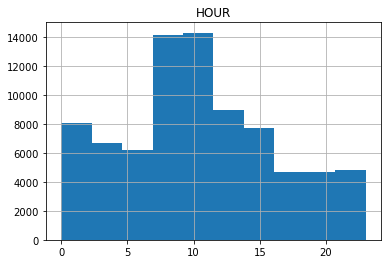

In [33]:
# set time, day, month from OPENING_DATE
df[['HOUR']]= df.OPENING_TIME.dt.hour
df[['DAY']]= df.OPENING_TIME.dt.dayofweek + 1
df[['MONTH']]= df.OPENING_TIME.dt.month
df['OPENING_DAY'] = df.OPENING_TIME.dt.day_name().str.upper()
df.hist(column='HOUR')


In [34]:
pd.set_option('display.max_columns', None)
df.head()

,ROW,NOTIFYING_CHANNEL,PROBLEM_ID,CFS_ID,CFS_CODE,CFS_NAME,CFS_DESC,CFS_PLAN_ID,CFS_PLAN_CODE,CFS_PLAN,WORK_TYPE_ID,WORK_TYPE_CODE,WORK_TYPE,RFS_TIP_ID,RFS_TYPE_CODE,RFS_TYPE,COMPLAINT_ID,COMPLAINT_TYPE_ID,COMPLAINT_TYPE,PRIORITY,OPENING_TIME,OPENING_DAY,CLOSING_TIME,DURATION_MIN,TEAM_CODE,DIRECTORATE_CODE,DIRECTORATE,CITY_CODE,CITY,REGION,EXTRA_OPERATION,RPA,HOUR,DAY,MONTH
0,1,OLO,2020081200075003100,228,ADSL,ADSL,ADSL,81,DSL_BAKIR,DSL BAKIR,141,ISLAH,ISLAH,153,MDF_DSLAM_ACCESS,MDF DSLAM ACCESS,341,HPA,HATALI PORT ARIZASI,1.0,2020-12-08 18:05:03,TUESDAY,14/08/20 10:29:2,2423,332FSAHA11001,1106237.0,EREĞLİ TELEKOM,1106222,KONYA,ANTALYA BÖLGE MÜDÜRLÜĞÜ,1,1,18,2,12
1,2,OLO,2020081200074986685,228,ADSL,ADSL,ADSL,81,DSL_BAKIR,DSL BAKIR,141,ISLAH,ISLAH,153,MDF_DSLAM_ACCESS,MDF DSLAM ACCESS,341,HPA,HATALI PORT ARIZASI,3.0,2020-12-08 21:57:01,TUESDAY,17/08/20 15:05:0,6787,232SAHA92016,1105744.0,BOR11A TELEKOM,1008,İZMİR,İZMİR BÖLGE MÜDÜRLÜĞÜ,1,1,21,2,12
2,3,OLO,2020081900075218630,228,ADSL,ADSL,ADSL,81,DSL_BAKIR,DSL BAKIR,141,ISLAH,ISLAH,153,MDF_DSLAM_ACCESS,MDF DSLAM ACCESS,341,HPA,HATALI PORT ARIZASI,2.0,2020-08-19 14:00:02,WEDNESDAY,20/08/20 11:35:1,1294,482FSAHA00016,1106127.0,03DİN,1106127,MARDİN,DİYARBAKIR BÖLGE MÜDÜRLÜĞÜ,1,1,14,3,8
3,4,OLO,2020082600075439130,228,ADSL,ADSL,ADSL,81,DSL_BAKIR,DSL BAKIR,141,ISLAH,ISLAH,153,MDF_DSLAM_ACCESS,MDF DSLAM ACCESS,341,HPA,HATALI PORT ARIZASI,5.0,2020-08-26 12:03:03,WEDNESDAY,27/08/20 09:39:5,1296,366FSAHA00866,1105602.0,KASTAMONU,1105602,KASTAMONU,ANKARA BÖLGE MÜDÜRLÜĞÜ,1,1,12,3,8
4,5,OLO,2020090200075743635,228,ADSL,ADSL,ADSL,81,DSL_BAKIR,DSL BAKIR,141,ISLAH,ISLAH,153,MDF_DSLAM_ACCESS,MDF DSLAM ACCESS,341,HPA,HATALI PORT ARIZASI,2.0,2020-02-09 17:45:02,SUNDAY,05/09/20 12:45:4,4020,452FSAHA00025,1106719.0,ORDU,1106719,ORDU,SAMSUN BÖLGE MÜDÜRLÜĞÜ,1,1,17,7,2


4    28177
1    27720
2    12627
3    11822
Name: SHIFT_PERIOD, dtype: int64


array([[<AxesSubplot:title={'center':'SHIFT_PERIOD'}>]], dtype=object)

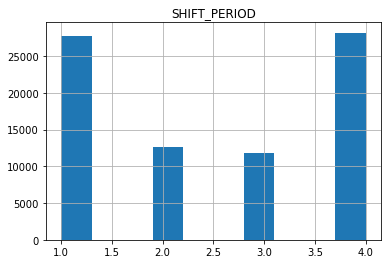

In [35]:
# convert  time to shift period category
# 4 category; 
# 1.Shift: 00:00-8:00
# 2.Shift: 8:00-12:00
# 3.Shift: 12:00-17:00
# 4.Shift: 17:00-00:00
df[['SHIFT_PERIOD']]= df.OPENING_TIME.dt.hour
df['SHIFT_PERIOD'] = np.where((df.SHIFT_PERIOD < 9), 4, df.SHIFT_PERIOD)
df['SHIFT_PERIOD'] = np.where((df.SHIFT_PERIOD > 8) & (df.SHIFT_PERIOD < 13), 1, df.SHIFT_PERIOD)
df['SHIFT_PERIOD'] = np.where((df.SHIFT_PERIOD > 12) & (df.SHIFT_PERIOD < 18), 2, df.SHIFT_PERIOD)
df['SHIFT_PERIOD'] = np.where((df.SHIFT_PERIOD > 17) & (df.SHIFT_PERIOD < 24), 3, df.SHIFT_PERIOD)
print(df['SHIFT_PERIOD'].value_counts())
df.hist(column='SHIFT_PERIOD')

In [36]:
#Add season coloumn
df[['SEASON']]= 4
df['SEASON'] = np.where((df.MONTH > 2) & (df.MONTH < 6), 1, df.SEASON)
df['SEASON'] = np.where((df.MONTH > 5) & (df.MONTH < 9), 2, df.SEASON)
df['SEASON'] = np.where((df.MONTH > 8) & (df.MONTH < 12), 3, df.SEASON)
print(df['SEASON'].value_counts())

3    22462
4    21701
2    19552
1    16631
Name: SEASON, dtype: int64


In [37]:
#Add QUARTER coloumn
df[['QUARTER']]= 1
df['QUARTER'] = np.where((df.MONTH > 3) & (df.MONTH < 7), 2, df.QUARTER)
df['QUARTER'] = np.where((df.MONTH > 6) & (df.MONTH < 10), 3, df.QUARTER)
df['QUARTER'] = np.where((df.MONTH > 9) & (df.MONTH < 13), 4, df.QUARTER)
print(df['QUARTER'].value_counts())

4    23006
3    20772
1    19035
2    17533
Name: QUARTER, dtype: int64


In [38]:
#Add REGION ID coloumn
df[['REGION_ID']]= 1
df['REGION_ID'] = np.where((df.REGION == 'ANKARA BÖLGE MÜDÜRLÜĞÜ'), 2, df.REGION_ID)
df['REGION_ID'] = np.where((df.REGION == 'İZMİR BÖLGE MÜDÜRLÜĞÜ'), 3, df.REGION_ID)
df['REGION_ID'] = np.where((df.REGION == 'ADANA BÖLGE MÜDÜRLÜĞÜ'), 4, df.REGION_ID)
df['REGION_ID'] = np.where((df.REGION == 'BURSA BÖLGE MÜDÜRLÜĞÜ'), 5, df.REGION_ID)
df['REGION_ID'] = np.where((df.REGION == 'ANTALYA BÖLGE MÜDÜRLÜĞÜ'), 6, df.REGION_ID)
df['REGION_ID'] = np.where((df.REGION == 'DİYARBAKIR BÖLGE MÜDÜRLÜĞÜ'), 7, df.REGION_ID)
df['REGION_ID'] = np.where((df.REGION == 'SAMSUN BÖLGE MÜDÜRLÜĞÜ'), 8, df.REGION_ID)
df['REGION_ID'] = np.where((df.REGION == 'KAYSERİ BÖLGE MÜDÜRLÜĞÜ'), 9, df.REGION_ID)
df['REGION_ID'] = np.where((df.REGION == 'TRABZON BÖLGE MÜDÜRLÜĞÜ'), 10, df.REGION_ID)
df['REGION_ID'] = np.where((df.REGION == 'ERZURUM BÖLGE MÜDÜRLÜĞÜ'), 11, df.REGION_ID)
print(df['REGION_ID'].value_counts())

1     27827
3     12099
2      9975
4      7449
5      5411
6      4804
7      3377
8      2660
9      2405
10     2318
11     2021
Name: REGION_ID, dtype: int64


In [39]:
#Add back to school coloumn
df[['BACK_TO_SCHOOL']]= 0
df['BACK_TO_SCHOOL'] = np.where((df.MONTH == 9), 1, df.BACK_TO_SCHOOL)
print(df['BACK_TO_SCHOOL'].value_counts())

0    72800
1     7546
Name: BACK_TO_SCHOOL, dtype: int64


In [40]:
#Add peak_time coloumn
df[['PEAK_TIME']]= 0
df['PEAK_TIME'] = np.where((df.HOUR > 8) & (df.HOUR < 13), 1, df.PEAK_TIME)
print(df['PEAK_TIME'].value_counts())

0    52626
1    27720
Name: PEAK_TIME, dtype: int64


In [41]:
#Add lunch_break coloumn
df[['LUNCH_BREAK']]= 0
df['LUNCH_BREAK'] = np.where((df.HOUR > 10) & (df.HOUR < 14), 1, df.LUNCH_BREAK)
print(df['LUNCH_BREAK'].value_counts())

0    64308
1    16038
Name: LUNCH_BREAK, dtype: int64


In [42]:
# convert solution duration (duration_min) to 5 category
# max %40 accuracy with RFC for 5 category, so try for 2 category according to 2 days SLA 
# max %10 accuracy for duration estimation
# 1.Category: 0-1440 minutes, 0-1 day
# 2.Category: 2161-2880 minutes, 1-2 day, SLA threshold is 2 day
# 3.Category: 2881-4320 minutes, 2-3 day
# 4.Category: 4321-5760 minutes, 3-4 day
# 5.Category: >5760 minutes, > 4 day

# add duration_category column with defaul value = 0
df['DURATION_CATEGORY'] = 0
df['DURATION_CATEGORY'] = np.where((df.DURATION_MIN > 2880), 1, df.DURATION_CATEGORY) # more than 2 days, customer SLA treshold
#df['DURATION_CATEGORY'] = np.where((df.DURATION_MIN < 2170) & (df.DURATION_CATEGORY == 1) & ((df.CFS_CODE == 'FIBER_INTERNET') | (df.CFS_CODE == 'FIBER_YALIN_INTERNET')), 0, df.DURATION_CATEGORY)
#df['DURATION_CATEGORY'] = np.where((df.DURATION_MIN < 1441), 1, df.DURATION_CATEGORY)
#df['DURATION_CATEGORY'] = np.where((df.DURATION_MIN > 1440) & (df.DURATION_MIN < 2881), 2, df.DURATION_CATEGORY)
#df['DURATION_CATEGORY'] = np.where((df.DURATION_MIN > 2880) & (df.DURATION_MIN < 4321), 3, df.DURATION_CATEGORY)
#df['DURATION_CATEGORY'] = np.where((df.DURATION_MIN > 4320) , 4, df.DURATION_CATEGORY)
#df['DURATION_CATEGORY'] = np.where((df.DURATION_MIN > 4320) & (df.DURATION_MIN < 5761), 4, df.DURATION_CATEGORY)
#df['DURATION_CATEGORY'] = np.where((df.DURATION_MIN > 5760), 5, df.DURATION_CATEGORY)

0    40985
1    39361
Name: DURATION_CATEGORY, dtype: int64


array([[<AxesSubplot:title={'center':'DURATION_CATEGORY'}>]], dtype=object)

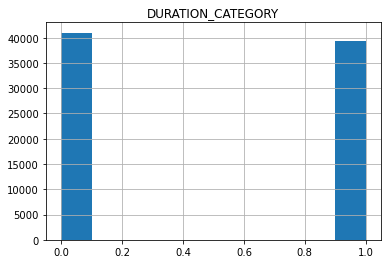

In [43]:
print(df['DURATION_CATEGORY'].value_counts())
df.hist(column='DURATION_CATEGORY')

In [44]:
# solution for RecursionError: maximum recursion depth exceeded
sys.setrecursionlimit(3000)
df['OPENING_DAY'] = df['OPENING_DAY'].apply(str)

In [45]:
# delete spaces
df[['OPENING_DAY']] = df[['OPENING_DAY']].replace(to_replace=' ', value='', regex=True)

In [46]:
# add weekend
df[['WEEKEND']]= 0
df['WEEKEND'] = np.where((df.OPENING_DAY == 'SATURDAY') | (df.OPENING_DAY == 'SUNDAY'), 1, df.WEEKEND)
print(df['WEEKEND'].value_counts())

0    59655
1    20691
Name: WEEKEND, dtype: int64


In [47]:
# add metropol flag, over 3M
df[['METROPOL']]= 0
df['METROPOL'] = np.where((df.CITY == 'İSTANBUL') | (df.CITY == 'İSTANBUL AVR') | (df.CITY == 'İSTANBUL AND') | (df.CITY == 'ANKARA') | (df.CITY == 'İZMİR') | (df.CITY == 'BURSA'), 1, df.METROPOL)
print(df['METROPOL'].value_counts())

0    44605
1    35741
Name: METROPOL, dtype: int64


7    23103
2    15193
0    10075
3    10056
1     9281
5     5400
6     4418
4     2820
Name: CITY_POPULATION, dtype: int64


array([[<AxesSubplot:title={'center':'CITY_POPULATION'}>]], dtype=object)

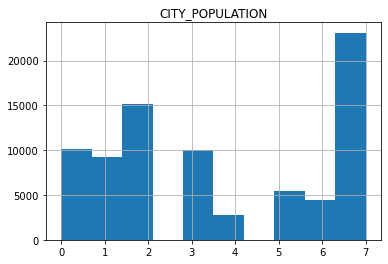

In [48]:
# add population of city
df[['CITY_POPULATION']]= 0 #under 500K
df['CITY_POPULATION'] = np.where((df.CITY.isin(['ELAZIĞ', 'ÇORUM', 'AĞRI', 'ŞIRNAK', 'ÇANAKKALE', 'OSMANİYE', 'KÜTAHYA', 'ZONGULDAK', 'TOKAT', 'BATMAN', 'ADIYAMAN', 'SİVAS', 'AFYON', 'ERZURUM', 'ORDU', 'MALATYA', 'TRABZON', 'MARDİN'])), 1, df.CITY_POPULATION) # over 500K
df['CITY_POPULATION'] = np.where((df.CITY.isin(['MUĞLA', 'DENİZLİ', 'SAKARYA', 'TEKİRDAĞ', 'AYDIN', 'VAN', 'KAHRAMANMARAŞ', 'BALIKESİR', 'SAMSUN', 'KAYSERİ', 'MANİSA', 'HATAY', 'DİYARBAKIR', 'MERSİN', 'ESKİŞEHİR'])), 2, df.CITY_POPULATION) # over 1M
df['CITY_POPULATION'] = np.where((df.CITY.isin(['KOCAELİ', 'GAZİANTEP', 'ŞANLIURFA', 'KONYA', 'ADANA', 'ANTALYA'])), 3, df.CITY_POPULATION) # over 2M
df['CITY_POPULATION'] = np.where((df.CITY.isin(['BURSA'])), 4, df.CITY_POPULATION) # over 3M
df['CITY_POPULATION'] = np.where((df.CITY.isin(['İZMİR'])), 5, df.CITY_POPULATION) # over 4M
df['CITY_POPULATION'] = np.where((df.CITY.isin(['ANKARA'])), 6, df.CITY_POPULATION) # over 5M
df['CITY_POPULATION'] = np.where((df.CITY.isin(['İSTANBUL', 'İSTANBUL AVR', 'İSTANBUL AND'])), 7, df.CITY_POPULATION) # over 6M
print(df['CITY_POPULATION'].value_counts())
df.hist(column='CITY_POPULATION')

In [49]:
# add metropol flag, over 3M
df[['ISTANBUL']]= 0
df['ISTANBUL'] = np.where((df.CITY == 'İSTANBUL') | (df.CITY == 'İSTANBUL AVR') | (df.CITY == 'İSTANBUL AND') , 1, df.ISTANBUL)
print(df['ISTANBUL'].value_counts())

0    57243
1    23103
Name: ISTANBUL, dtype: int64


In [50]:
# convert CFS_CODE, CFS_PLAN_CODE, OPENING_DAY, SEASON to one hot encoding
print(df['CFS_CODE'].value_counts())
print(df['CFS_PLAN_CODE'].value_counts())
print(df['OPENING_DAY'].value_counts())
print(df['SEASON'].value_counts())
print(df['QUARTER'].value_counts())
print(df['MONTH'].value_counts())
print(df['SHIFT_PERIOD'].value_counts())
print(df['REGION_ID'].value_counts())

hot_cfs_code = pd.get_dummies(df.CFS_CODE, prefix='CFS')
hot_cfs_plan_code = pd.get_dummies(df.CFS_PLAN_CODE, prefix='CFS_PLAN')
hot_dayofweek = pd.get_dummies(df.OPENING_DAY, prefix='DAY')
hot_season = pd.get_dummies(df.SEASON, prefix='SEASON')
hot_quarter = pd.get_dummies(df.QUARTER, prefix='QUARTER')
hot_month = pd.get_dummies(df.MONTH, prefix='MONTH')
hot_shift_period = pd.get_dummies(df.SHIFT_PERIOD, prefix='SHIFT_PERIOD')
hot_region = pd.get_dummies(df.REGION_ID, prefix='REGION')

ADSL                    30833
VDSL2                   18630
NDSL                    16545
NVDSL                   13229
FIBER_INTERNET            630
FIBER_YALIN_INTERNET      479
Name: CFS_CODE, dtype: int64
DSL_FTTC              35764
DSL_FTTB              21786
DSL_BAKIR             21687
FIBER_INTERNET_PON     1089
FIBER_INTERNET_AON       20
Name: CFS_PLAN_CODE, dtype: int64
MONDAY       12891
THURSDAY     12246
WEDNESDAY    11924
TUESDAY      11718
SATURDAY     10894
FRIDAY       10876
SUNDAY        9797
Name: OPENING_DAY, dtype: int64
3    22462
4    21701
2    19552
1    16631
Name: SEASON, dtype: int64
4    23006
3    20772
1    19035
2    17533
Name: QUARTER, dtype: int64
12    8090
1     7876
10    7809
9     7546
8     7293
11    7107
6     6326
5     6138
7     5933
2     5735
3     5424
4     5069
Name: MONTH, dtype: int64
4    28177
1    27720
2    12627
3    11822
Name: SHIFT_PERIOD, dtype: int64
1     27827
3     12099
2      9975
4      7449
5      5411
6      4804
7 

In [51]:
df_hot = pd.concat([df, hot_cfs_code, hot_cfs_plan_code, hot_dayofweek, hot_season, hot_quarter, hot_month, hot_shift_period, hot_region]
                   , axis=1)

df_hot.head()

,ROW,NOTIFYING_CHANNEL,PROBLEM_ID,CFS_ID,CFS_CODE,CFS_NAME,CFS_DESC,CFS_PLAN_ID,CFS_PLAN_CODE,CFS_PLAN,WORK_TYPE_ID,WORK_TYPE_CODE,WORK_TYPE,RFS_TIP_ID,RFS_TYPE_CODE,RFS_TYPE,COMPLAINT_ID,COMPLAINT_TYPE_ID,COMPLAINT_TYPE,PRIORITY,OPENING_TIME,OPENING_DAY,CLOSING_TIME,DURATION_MIN,TEAM_CODE,DIRECTORATE_CODE,DIRECTORATE,CITY_CODE,CITY,REGION,EXTRA_OPERATION,RPA,HOUR,DAY,MONTH,SHIFT_PERIOD,SEASON,QUARTER,REGION_ID,BACK_TO_SCHOOL,PEAK_TIME,LUNCH_BREAK,DURATION_CATEGORY,WEEKEND,METROPOL,CITY_POPULATION,ISTANBUL,CFS_ADSL,CFS_FIBER_INTERNET,CFS_FIBER_YALIN_INTERNET,CFS_NDSL,CFS_NVDSL,CFS_VDSL2,CFS_PLAN_DSL_BAKIR,CFS_PLAN_DSL_FTTB,CFS_PLAN_DSL_FTTC,CFS_PLAN_FIBER_INTERNET_AON,CFS_PLAN_FIBER_INTERNET_PON,DAY_FRIDAY,DAY_MONDAY,DAY_SATURDAY,DAY_SUNDAY,DAY_THURSDAY,DAY_TUESDAY,DAY_WEDNESDAY,SEASON_1,SEASON_2,SEASON_3,SEASON_4,QUARTER_1,QUARTER_2,QUARTER_3,QUARTER_4,MONTH_1,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,SHIFT_PERIOD_1,SHIFT_PERIOD_2,SHIFT_PERIOD_3,SHIFT_PERIOD_4,REGION_1,REGION_2,REGION_3,REGION_4,REGION_5,REGION_6,REGION_7,REGION_8,REGION_9,REGION_10,REGION_11
0,1,OLO,2020081200075003100,228,ADSL,ADSL,ADSL,81,DSL_BAKIR,DSL BAKIR,141,ISLAH,ISLAH,153,MDF_DSLAM_ACCESS,MDF DSLAM ACCESS,341,HPA,HATALI PORT ARIZASI,1.0,2020-12-08 18:05:03,TUESDAY,14/08/20 10:29:2,2423,332FSAHA11001,1106237.0,EREĞLİ TELEKOM,1106222,KONYA,ANTALYA BÖLGE MÜDÜRLÜĞÜ,1,1,18,2,12,3,4,4,6,0,0,0,0,0,0,3,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
1,2,OLO,2020081200074986685,228,ADSL,ADSL,ADSL,81,DSL_BAKIR,DSL BAKIR,141,ISLAH,ISLAH,153,MDF_DSLAM_ACCESS,MDF DSLAM ACCESS,341,HPA,HATALI PORT ARIZASI,3.0,2020-12-08 21:57:01,TUESDAY,17/08/20 15:05:0,6787,232SAHA92016,1105744.0,BOR11A TELEKOM,1008,İZMİR,İZMİR BÖLGE MÜDÜRLÜĞÜ,1,1,21,2,12,3,4,4,3,0,0,0,1,0,1,5,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,3,OLO,2020081900075218630,228,ADSL,ADSL,ADSL,81,DSL_BAKIR,DSL BAKIR,141,ISLAH,ISLAH,153,MDF_DSLAM_ACCESS,MDF DSLAM ACCESS,341,HPA,HATALI PORT ARIZASI,2.0,2020-08-19 14:00:02,WEDNESDAY,20/08/20 11:35:1,1294,482FSAHA00016,1106127.0,03DİN,1106127,MARDİN,DİYARBAKIR BÖLGE MÜDÜRLÜĞÜ,1,1,14,3,8,2,2,3,7,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,OLO,2020082600075439130,228,ADSL,ADSL,ADSL,81,DSL_BAKIR,DSL BAKIR,141,ISLAH,ISLAH,153,MDF_DSLAM_ACCESS,MDF DSLAM ACCESS,341,HPA,HATALI PORT ARIZASI,5.0,2020-08-26 12:03:03,WEDNESDAY,27/08/20 09:39:5,1296,366FSAHA00866,1105602.0,KASTAMONU,1105602,KASTAMONU,ANKARA BÖLGE MÜDÜRLÜĞÜ,1,1,12,3,8,1,2,3,2,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,5,OLO,2020090200075743635,228,ADSL,ADSL,ADSL,81,DSL_BAKIR,DSL BAKIR,141,ISLAH,ISLAH,153,MDF_DSLAM_ACCESS,MDF DSLAM ACCESS,341,HPA,HATALI PORT ARIZASI,2.0,2020-02-09 17:45:02,SUNDAY,05/09/20 12:45:4,4020,452FSAHA00025,1106719.0,ORDU,1106719,ORDU,SAMSUN BÖLGE MÜDÜRLÜĞÜ,1,1,17,7,2,2,4,1,8,0,0,0,1,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


In [52]:
# Find the correlation between features (hints: pearson correlation)
df_hot.corr(method="pearson")

,ROW,PROBLEM_ID,CFS_ID,CFS_PLAN_ID,WORK_TYPE_ID,RFS_TIP_ID,COMPLAINT_ID,PRIORITY,DURATION_MIN,DIRECTORATE_CODE,CITY_CODE,EXTRA_OPERATION,RPA,HOUR,DAY,MONTH,SHIFT_PERIOD,SEASON,QUARTER,REGION_ID,BACK_TO_SCHOOL,PEAK_TIME,LUNCH_BREAK,DURATION_CATEGORY,WEEKEND,METROPOL,CITY_POPULATION,ISTANBUL,CFS_ADSL,CFS_FIBER_INTERNET,CFS_FIBER_YALIN_INTERNET,CFS_NDSL,CFS_NVDSL,CFS_VDSL2,CFS_PLAN_DSL_BAKIR,CFS_PLAN_DSL_FTTB,CFS_PLAN_DSL_FTTC,CFS_PLAN_FIBER_INTERNET_AON,CFS_PLAN_FIBER_INTERNET_PON,DAY_FRIDAY,DAY_MONDAY,DAY_SATURDAY,DAY_SUNDAY,DAY_THURSDAY,DAY_TUESDAY,DAY_WEDNESDAY,SEASON_1,SEASON_2,SEASON_3,SEASON_4,QUARTER_1,QUARTER_2,QUARTER_3,QUARTER_4,MONTH_1,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,SHIFT_PERIOD_1,SHIFT_PERIOD_2,SHIFT_PERIOD_3,SHIFT_PERIOD_4,REGION_1,REGION_2,REGION_3,REGION_4,REGION_5,REGION_6,REGION_7,REGION_8,REGION_9,REGION_10,REGION_11
ROW,1.000000,0.090596,0.411052,0.424864,-0.013249,-0.005588,0.007683,0.114881,-0.023750,-0.017384,-0.016144,-0.044747,-0.000178,-0.603340,-0.000604,-0.031801,0.195865,-0.045685,-0.032608,-0.037693,-0.022366,0.140693,-0.026280,-0.036199,0.002966,0.055857,0.057961,0.058728,-0.425062,-0.017387,0.007992,0.100578,0.216374,0.205458,-0.142105,0.229327,-0.076356,-0.002457,-0.007607,-0.003125,-0.002127,0.003417,0.000389,-0.005535,0.007505,-0.000301,0.044415,0.014376,-0.036666,-0.017361,0.002513,0.050230,-0.017581,-0.031230,-0.009947,-0.002190,0.018294,0.024657,0.027897,0.027260,0.021006,-0.023205,-0.022366,-0.018693,-0.015472,-0.013914,0.140693,-0.423818,-0.403914,0.482935,0.057768,-0.030599,0.005768,-0.018909,-0.019624,-0.009153,-0.000300,-0.020364,-0.009209,-0.015109,0.005848
PROBLEM_ID,0.090596,1.000000,0.126374,0.074726,0.025754,-0.077608,0.002186,0.072842,-0.136827,-0.001415,0.001398,-0.048536,0.001344,0.007389,-0.010959,-0.541655,0.004477,-0.225761,-0.531403,0.008959,-0.218747,-0.005177,-0.007799,-0.226500,0.000772,-0.012667,-0.019748,-0.029840,-0.093710,0.033903,0.026286,-0.069055,0.069444,0.101243,-0.049762,0.229688,-0.171098,0.001982,0.043091,-0.002924,0.004105,0.012399,-0.011940,-0.026042,0.012617,0.011429,0.291663,0.097199,-0.426687,0.071204,0.319256,0.330834,-0.177073,-0.431067,0.208013,0.143507,0.147248,0.138165,0.179315,0.205790,0.179300,-0.210961,-0.218747,-0.233301,-0.206268,-0.223264,-0.005177,-0.001725,0.008195,0.000389,-0.025240,-0.002024,0.037857,-0.004851,0.005135,0.004139,-0.020307,0.011682,0.000572,-0.000673,0.001760
CFS_ID,0.411052,0.126374,1.000000,0.881061,0.188609,0.129152,0.020855,0.262016,-0.049145,-0.029488,-0.031071,-0.245863,-0.008754,0.002794,-0.003454,-0.041577,-0.003360,-0.027146,-0.041758,-0.067398,-0.037380,0.003734,-0.005395,-0.083229,0.001814,0.121237,0.127249,0.119602,-0.906918,0.175307,0.201060,0.050533,0.598342,0.397497,-0.283212,0.188580,0.022030,0.035549,0.262732,-0.007906,0.000004,0.004419,-0.002200,-0.005390,0.003274,0.007572,0.031022,0.022652,-0.061309,0.011770,0.014177,0.048176,-0.023975,-0.034132,0.014737,-0.001308,0.007903,0.015620,0.025556,0.034577,0.035388,-0.030796,-0.037380,-0.035689,-0.021267,0.003925,0.003734,-0.002514,0.002287,-0.003499,0.115602,-0.058724,-0.005338,-0.044493,-0.029849,-0.014266,0.007117,-0.037527,-0.003406,-0.030381,0.006314
CFS_PLAN_ID,0.424864,0.074726,0.881061,1.000000,-0.015657,0.181969,0.010254,0.232910,-0.027019,-0.029657,-0.027177,-0.098380,-0.006334,0.000393,-0.001820,-0.022977,-0.004181,-0.031819,-0.023512,-0.073354,-0.020285,0.005116,-0.005765,-0.048716,0.002007,0.120847,0.127500,0.121025,-0.975644,-0.099921,0.075944,0.373703,0.375433,0.443267,-0.314375,0.137726,0.163583,-0.003264,-0.025213,-0.005603,-0.001818,0.001587,0.001022,-0.004914,0.006543,0.003273,0.024208,0.022606,-0.031401,-0.012198,-0.000751,0.037979,-0.008533,-0.025730,-0.011363,0.005513,0.006537,0.013181,0.018684,0.027919,0.026355,-0.016399,-0.020285,-0.018529,-0.009460,-0.011486,0.005116,-0.002487,-0.000361,-0.002931,0.121426,-0.048541,-0.019237,-0.039855,-0.028204,-0.014430,-0.005766,-0.039481,-0.0113

In [53]:
df_excel.columns

Index(['ROW', 'NOTIFYING_CHANNEL', 'PROBLEM_ID', 'CFS_ID', 'CFS_CODE',
       'CFS_NAME', 'CFS_DESC', 'CFS_PLAN_ID', 'CFS_PLAN_CODE', 'CFS_PLAN',
       'WORK_TYPE_ID', 'WORK_TYPE_CODE', 'WORK_TYPE', 'RFS_TIP_ID',
       'RFS_TYPE_CODE', 'RFS_TYPE', 'COMPLAINT_ID', 'COMPLAINT_TYPE_ID',
       'COMPLAINT_TYPE', 'PRIORITY', 'OPENING_TIME', 'OPENING_DAY',
       'CLOSING_TIME', 'DURATION_MIN', 'TEAM_CODE', 'DIRECTORATE_CODE',
       'DIRECTORATE', 'CITY_CODE', 'CITY', 'REGION', 'EXTRA_OPERATION', 'RPA',
       'HOUR', 'DAY', 'MONTH', 'SHIFT_PERIOD', 'SEASON', 'QUARTER',
       'REGION_ID', 'BACK_TO_SCHOOL', 'PEAK_TIME', 'LUNCH_BREAK',
       'DURATION_CATEGORY', 'WEEKEND', 'METROPOL', 'CITY_POPULATION',
       'ISTANBUL'],
      dtype='object')

<AxesSubplot:xlabel='DURATION_CATEGORY'>

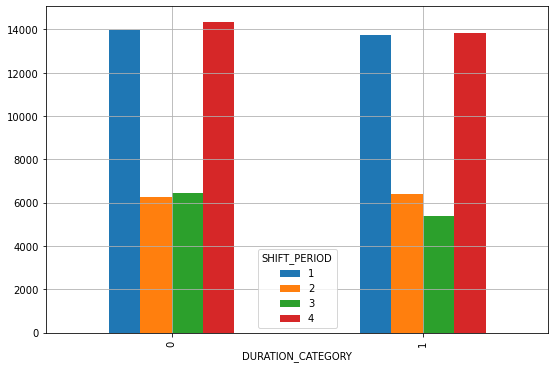

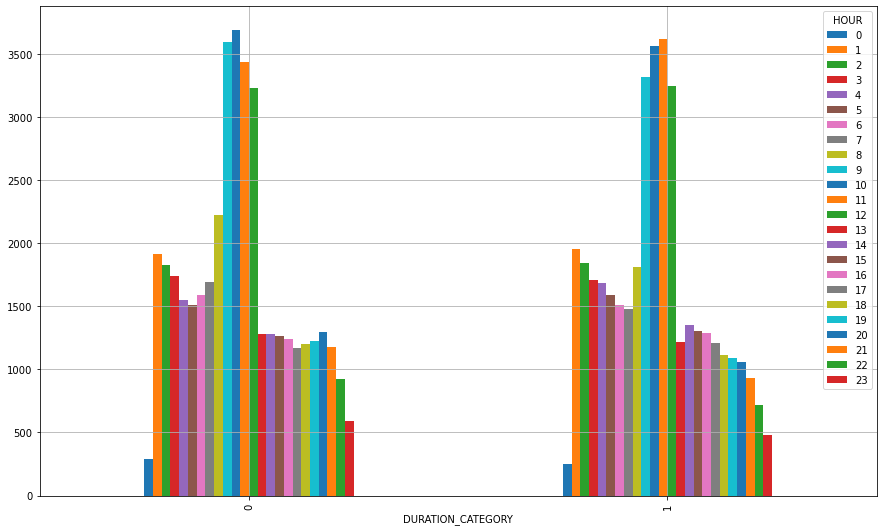

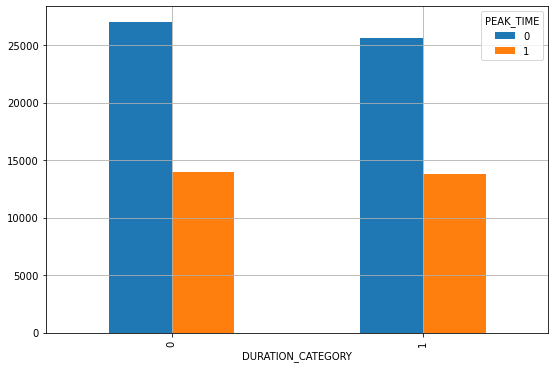

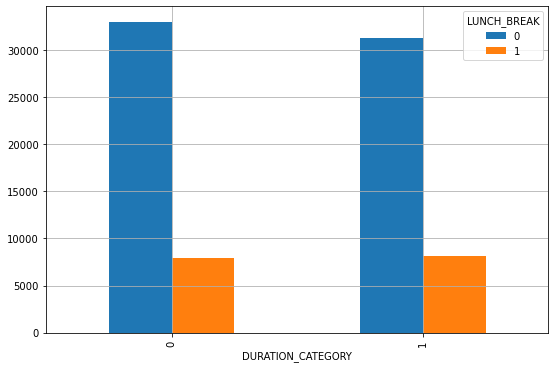

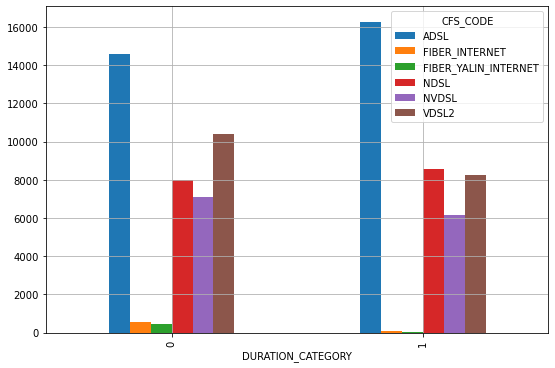

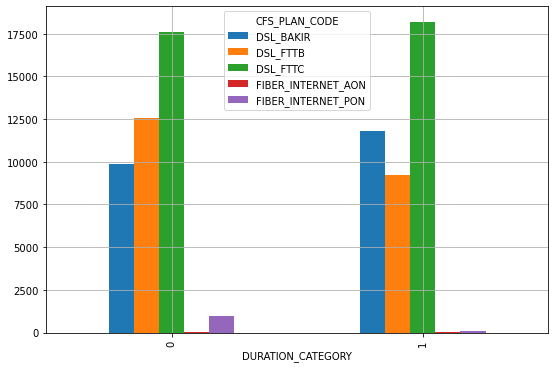

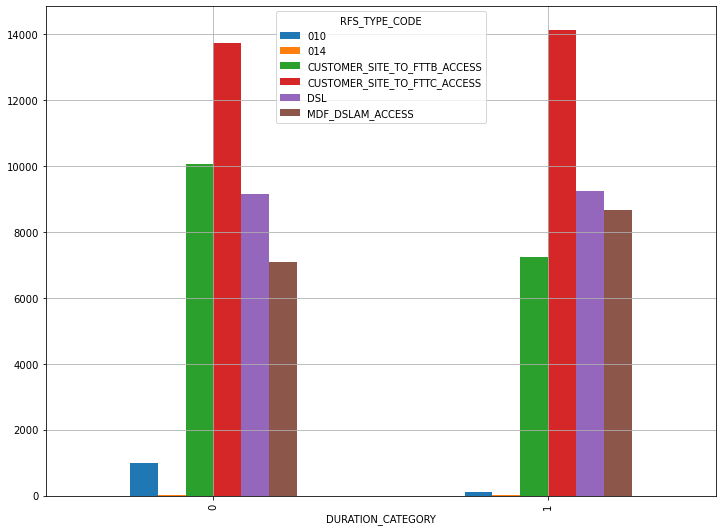

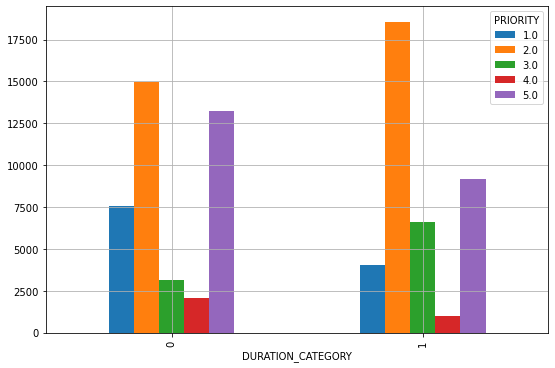

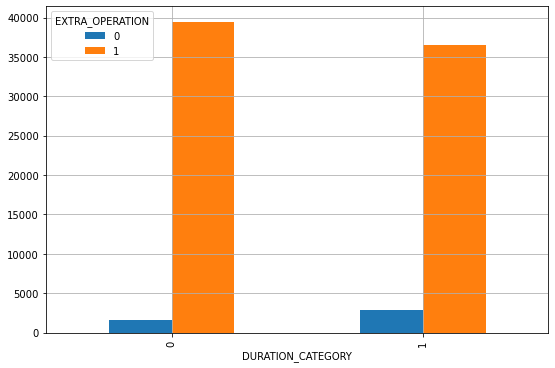

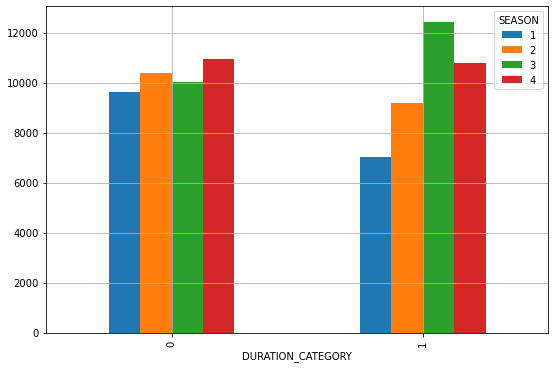

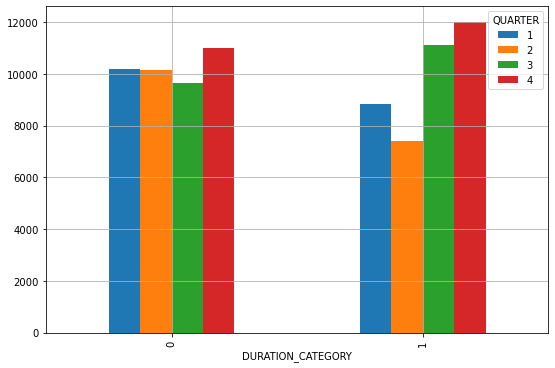

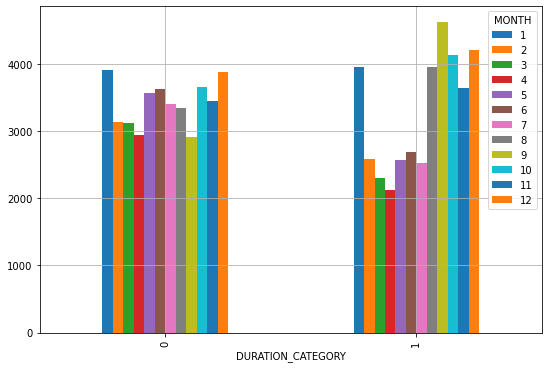

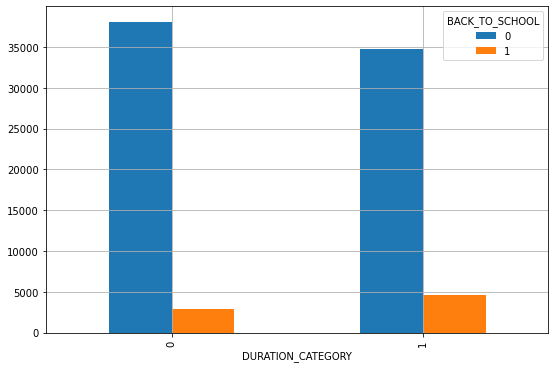

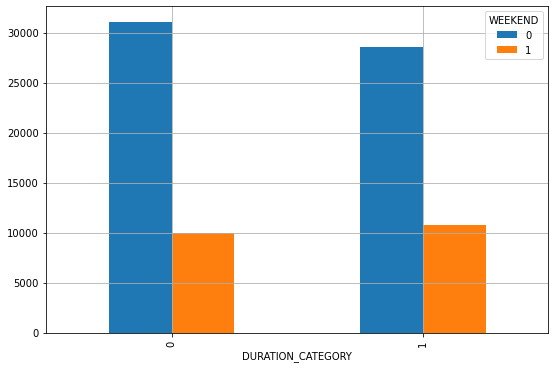

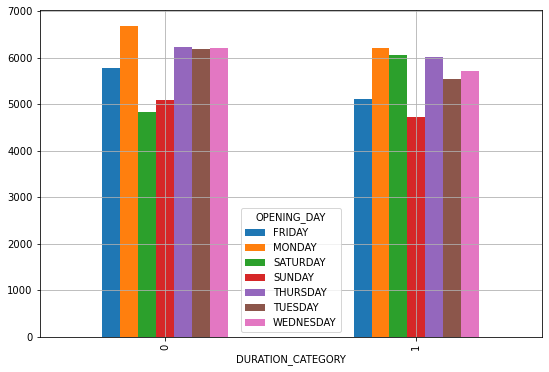

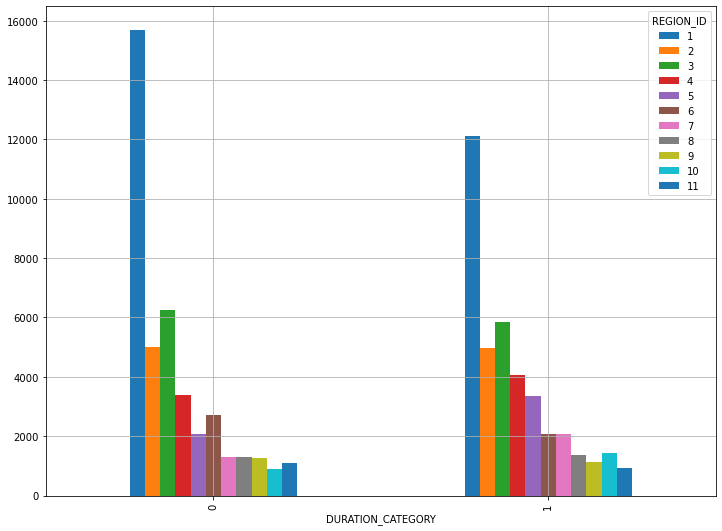

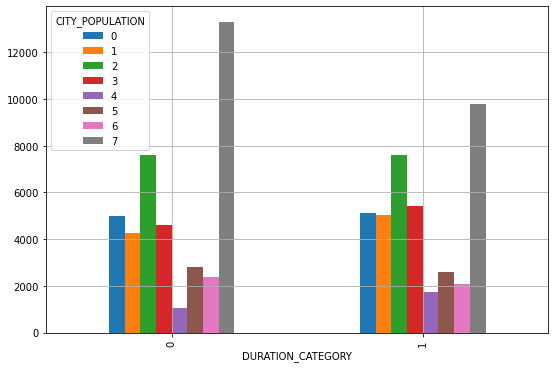

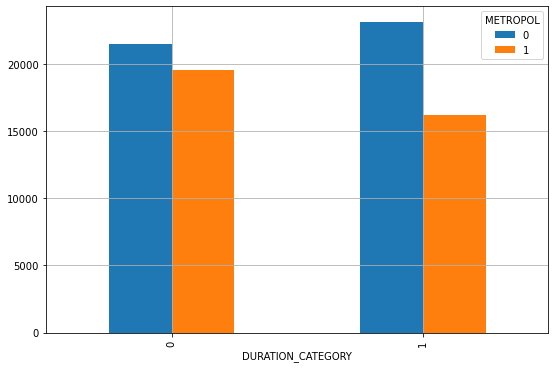

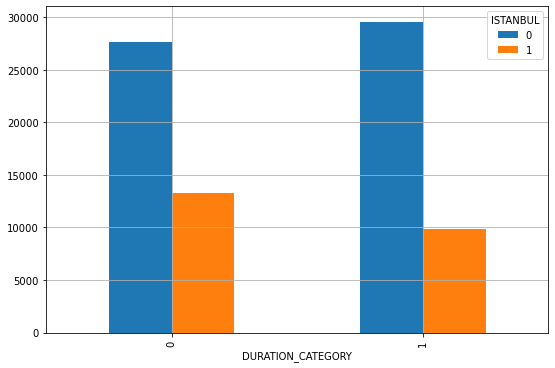

In [54]:
#examine class distribution 
distribution_set=df.groupby(['DURATION_CATEGORY','SHIFT_PERIOD']).size().unstack(level=1)
distribution_set.plot(kind = 'bar', grid=True, figsize=(9,6))
distribution_set=df.groupby(['DURATION_CATEGORY','HOUR']).size().unstack(level=1)
distribution_set.plot(kind = 'bar', grid=True, figsize=(15,9))
distribution_set=df.groupby(['DURATION_CATEGORY','PEAK_TIME']).size().unstack(level=1)
distribution_set.plot(kind = 'bar', grid=True, figsize=(9,6))
distribution_set=df.groupby(['DURATION_CATEGORY','LUNCH_BREAK']).size().unstack(level=1)
distribution_set.plot(kind = 'bar', grid=True, figsize=(9,6))
distribution_set=df.groupby(['DURATION_CATEGORY','CFS_CODE']).size().unstack(level=1)
distribution_set.plot(kind = 'bar', grid=True, figsize=(9,6))
distribution_set=df.groupby(['DURATION_CATEGORY','CFS_PLAN_CODE']).size().unstack(level=1)
distribution_set.plot(kind = 'bar', grid=True, figsize=(9,6))
distribution_set=df.groupby(['DURATION_CATEGORY','RFS_TYPE_CODE']).size().unstack(level=1)
distribution_set.plot(kind = 'bar', grid=True, figsize=(12,9))
distribution_set=df.groupby(['DURATION_CATEGORY','PRIORITY']).size().unstack(level=1)
distribution_set.plot(kind = 'bar', grid=True, figsize=(9,6))
distribution_set=df.groupby(['DURATION_CATEGORY','EXTRA_OPERATION']).size().unstack(level=1)
distribution_set.plot(kind = 'bar', grid=True, figsize=(9,6))
distribution_set=df.groupby(['DURATION_CATEGORY','SEASON']).size().unstack(level=1)
distribution_set.plot(kind = 'bar', grid=True, figsize=(9,6))
distribution_set=df.groupby(['DURATION_CATEGORY','QUARTER']).size().unstack(level=1)
distribution_set.plot(kind = 'bar', grid=True, figsize=(9,6))
distribution_set=df.groupby(['DURATION_CATEGORY','MONTH']).size().unstack(level=1)
distribution_set.plot(kind = 'bar', grid=True, figsize=(9,6))
distribution_set=df.groupby(['DURATION_CATEGORY','BACK_TO_SCHOOL']).size().unstack(level=1)
distribution_set.plot(kind = 'bar', grid=True, figsize=(9,6))
distribution_set=df.groupby(['DURATION_CATEGORY','WEEKEND']).size().unstack(level=1)
distribution_set.plot(kind = 'bar', grid=True, figsize=(9,6))
distribution_set=df.groupby(['DURATION_CATEGORY','OPENING_DAY']).size().unstack(level=1)
distribution_set.plot(kind = 'bar', grid=True, figsize=(9,6))
distribution_set=df.groupby(['DURATION_CATEGORY','REGION_ID']).size().unstack(level=1)
distribution_set.plot(kind = 'bar', grid=True, figsize=(12,9))
distribution_set=df.groupby(['DURATION_CATEGORY','CITY_POPULATION']).size().unstack(level=1)
distribution_set.plot(kind = 'bar', grid=True, figsize=(9,6))
distribution_set=df.groupby(['DURATION_CATEGORY','METROPOL']).size().unstack(level=1)
distribution_set.plot(kind = 'bar', grid=True, figsize=(9,6))
distribution_set=df.groupby(['DURATION_CATEGORY','ISTANBUL']).size().unstack(level=1)
distribution_set.plot(kind = 'bar', grid=True, figsize=(9,6))

In [55]:
df_hot.columns

Index(['ROW', 'NOTIFYING_CHANNEL', 'PROBLEM_ID', 'CFS_ID', 'CFS_CODE',
       'CFS_NAME', 'CFS_DESC', 'CFS_PLAN_ID', 'CFS_PLAN_CODE', 'CFS_PLAN',
       'WORK_TYPE_ID', 'WORK_TYPE_CODE', 'WORK_TYPE', 'RFS_TIP_ID',
       'RFS_TYPE_CODE', 'RFS_TYPE', 'COMPLAINT_ID', 'COMPLAINT_TYPE_ID',
       'COMPLAINT_TYPE', 'PRIORITY', 'OPENING_TIME', 'OPENING_DAY',
       'CLOSING_TIME', 'DURATION_MIN', 'TEAM_CODE', 'DIRECTORATE_CODE',
       'DIRECTORATE', 'CITY_CODE', 'CITY', 'REGION', 'EXTRA_OPERATION', 'RPA',
       'HOUR', 'DAY', 'MONTH', 'SHIFT_PERIOD', 'SEASON', 'QUARTER',
       'REGION_ID', 'BACK_TO_SCHOOL', 'PEAK_TIME', 'LUNCH_BREAK',
       'DURATION_CATEGORY', 'WEEKEND', 'METROPOL', 'CITY_POPULATION',
       'ISTANBUL', 'CFS_ADSL', 'CFS_FIBER_INTERNET',
       'CFS_FIBER_YALIN_INTERNET', 'CFS_NDSL', 'CFS_NVDSL', 'CFS_VDSL2',
       'CFS_PLAN_DSL_BAKIR', 'CFS_PLAN_DSL_FTTB', 'CFS_PLAN_DSL_FTTC',
       'CFS_PLAN_FIBER_INTERNET_AON', 'CFS_PLAN_FIBER_INTERNET_PON',
       'DAY_FRIDAY', 'DA

In [56]:
############################
#Partition data by features
#by Shift Period
############################

In [57]:
#Partition data by features
#by Shift Period
df_features=df_hot
df_features.shape

(80346, 100)

In [58]:
#Partition data by features
#by Shift Period
#df_features = df_hot.loc[df_hot['SHIFT_PERIOD'] == 4]
#df_features.shape

In [59]:
#Partition data by features
#by Region
#df_features = df_hot.loc[df_hot['REGION'] == 'İZMİR BÖLGE MÜDÜRLÜĞÜ']
#df_features.shape

#İSTANBUL BÖLGE MÜDÜRLÜĞÜ      27827
#İZMİR BÖLGE MÜDÜRLÜĞÜ         12099
#ANKARA BÖLGE MÜDÜRLÜĞÜ         9975
#ADANA BÖLGE MÜDÜRLÜĞÜ          7449
#BURSA BÖLGE MÜDÜRLÜĞÜ          5411
#ANTALYA BÖLGE MÜDÜRLÜĞÜ        4804
#DİYARBAKIR BÖLGE MÜDÜRLÜĞÜ     3377
#SAMSUN BÖLGE MÜDÜRLÜĞÜ         2660
#KAYSERİ BÖLGE MÜDÜRLÜĞÜ        2405
#TRABZON BÖLGE MÜDÜRLÜĞÜ        2318
#ERZURUM BÖLGE MÜDÜRLÜĞÜ        2021
#Name: REGION, dtype: int64

In [60]:
all_features=df_features[[
             #  'OPENING_DAY'
               'DAY_TUESDAY', 'DAY_MONDAY', 'DAY_WEDNESDAY', 'DAY_THURSDAY', 'DAY_FRIDAY', 'DAY_SATURDAY', 'DAY_SUNDAY' 
             # 'DAY'
             #, 'MONTH'
             #, 'HOUR'
             , 'MONTH_1', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6', 'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12'
             , 'PRIORITY'
             #, 'CFS_CODE'
             , 'CFS_ADSL', 'CFS_NDSL', 'CFS_NVDSL', 'CFS_VDSL2', 'CFS_FIBER_INTERNET', 'CFS_FIBER_YALIN_INTERNET'
             #,'CFS_PLAN_CODE'
             , 'CFS_PLAN_DSL_BAKIR', 'CFS_PLAN_DSL_FTTB', 'CFS_PLAN_DSL_FTTC', 'CFS_PLAN_FIBER_INTERNET_AON', 'CFS_PLAN_FIBER_INTERNET_PON'
             # 'SEASON'
             , 'SEASON_1', 'SEASON_2', 'SEASON_3', 'SEASON_4'
             #, 'QUARTER'
             , 'QUARTER_1', 'QUARTER_2', 'QUARTER_3', 'QUARTER_4'
             , 'BACK_TO_SCHOOL'
             , 'EXTRA_OPERATION'
             , 'WEEKEND'
             #, 'REGION'
             , 'REGION_1','REGION_2','REGION_3','REGION_4','REGION_5','REGION_6','REGION_7','REGION_8','REGION_9','REGION_10','REGION_11'
             , 'CITY_POPULATION'
             , 'METROPOL'
             , 'ISTANBUL'
             , 'PEAK_TIME'
             , 'LUNCH_BREAK'
             , 'RPA'
             #, 'SHIFT_PERIOD'
             , 'SHIFT_PERIOD_1', 'SHIFT_PERIOD_2', 'SHIFT_PERIOD_3', 'SHIFT_PERIOD_4'
             , 'DURATION_CATEGORY']]

best_features=df_features[[
             #  'OPENING_DAY'
               'DAY_TUESDAY', 'DAY_MONDAY', 'DAY_WEDNESDAY', 'DAY_THURSDAY', 'DAY_FRIDAY', 'DAY_SATURDAY', 'DAY_SUNDAY' 
             # 'DAY'
             #, 'MONTH'
             #, 'HOUR'
             #, 'MONTH_1', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6', 'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12'
             , 'PRIORITY'
             #, 'CFS_CODE'
             , 'CFS_ADSL', 'CFS_NDSL', 'CFS_NVDSL', 'CFS_VDSL2', 'CFS_FIBER_INTERNET', 'CFS_FIBER_YALIN_INTERNET'
             #,'CFS_PLAN_CODE'
             , 'CFS_PLAN_DSL_BAKIR', 'CFS_PLAN_DSL_FTTB', 'CFS_PLAN_DSL_FTTC', 'CFS_PLAN_FIBER_INTERNET_AON', 'CFS_PLAN_FIBER_INTERNET_PON'
             # 'SEASON'
             , 'SEASON_1', 'SEASON_2', 'SEASON_3', 'SEASON_4'
             #, 'QUARTER'
             , 'QUARTER_1', 'QUARTER_2', 'QUARTER_3', 'QUARTER_4'
             , 'BACK_TO_SCHOOL'
             , 'EXTRA_OPERATION'
             #, 'WEEKEND'
             #, 'REGION'
             , 'REGION_1','REGION_2','REGION_3','REGION_4','REGION_5','REGION_6','REGION_7','REGION_8','REGION_9','REGION_10','REGION_11'
             , 'CITY_POPULATION'
             #, 'METROPOL'
             #, 'ISTANBUL'
             #, 'PEAK_TIME'
             #, 'LUNCH_BREAK'
             #, 'RPA'
             #, 'SHIFT_PERIOD'
             , 'SHIFT_PERIOD_1', 'SHIFT_PERIOD_2', 'SHIFT_PERIOD_3', 'SHIFT_PERIOD_4'
             , 'DURATION_CATEGORY']]

non_ohe_features=df_features[[
             #  'OPENING_DAY'
             #  'DAY_TUESDAY', 'DAY_MONDAY', 'DAY_WEDNESDAY', 'DAY_THURSDAY', 'DAY_FRIDAY', 'DAY_SATURDAY', 'DAY_SUNDAY' 
              'DAY'
             , 'MONTH'
             , 'HOUR'
             #, 'MONTH_1', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6', 'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12'
             , 'PRIORITY'
             #, 'CFS_CODE'
             , 'CFS_ADSL', 'CFS_NDSL', 'CFS_NVDSL', 'CFS_VDSL2', 'CFS_FIBER_INTERNET', 'CFS_FIBER_YALIN_INTERNET'
             #,'CFS_PLAN_CODE'
             , 'CFS_PLAN_DSL_BAKIR', 'CFS_PLAN_DSL_FTTB', 'CFS_PLAN_DSL_FTTC', 'CFS_PLAN_FIBER_INTERNET_AON', 'CFS_PLAN_FIBER_INTERNET_PON'
             , 'SEASON'
             #, 'SEASON_1', 'SEASON_2', 'SEASON_3', 'SEASON_4'
             , 'QUARTER'
             #, 'QUARTER_1', 'QUARTER_2', 'QUARTER_3', 'QUARTER_4'
             , 'BACK_TO_SCHOOL'
             , 'EXTRA_OPERATION'
             , 'WEEKEND'
             #, 'REGION'
             , 'REGION_1','REGION_2','REGION_3','REGION_4','REGION_5','REGION_6','REGION_7','REGION_8','REGION_9','REGION_10','REGION_11'
             , 'CITY_POPULATION'
             , 'METROPOL'
             , 'ISTANBUL'
             , 'PEAK_TIME'
             , 'LUNCH_BREAK'
             , 'RPA'
             , 'SHIFT_PERIOD'
             #, 'SHIFT_PERIOD_1', 'SHIFT_PERIOD_2', 'SHIFT_PERIOD_3', 'SHIFT_PERIOD_4'
             , 'DURATION_CATEGORY']]

In [61]:
# set features for training
features = ''
#features = all_features
features = best_features
#features = non_ohe_features

features.head()
features.shape

(80346, 46)

In [62]:
# drop duplicates rows
# but no dublicate
features.drop_duplicates()
features.shape

(80346, 46)

In [63]:
features.columns

Index(['DAY_TUESDAY', 'DAY_MONDAY', 'DAY_WEDNESDAY', 'DAY_THURSDAY',
       'DAY_FRIDAY', 'DAY_SATURDAY', 'DAY_SUNDAY', 'PRIORITY', 'CFS_ADSL',
       'CFS_NDSL', 'CFS_NVDSL', 'CFS_VDSL2', 'CFS_FIBER_INTERNET',
       'CFS_FIBER_YALIN_INTERNET', 'CFS_PLAN_DSL_BAKIR', 'CFS_PLAN_DSL_FTTB',
       'CFS_PLAN_DSL_FTTC', 'CFS_PLAN_FIBER_INTERNET_AON',
       'CFS_PLAN_FIBER_INTERNET_PON', 'SEASON_1', 'SEASON_2', 'SEASON_3',
       'SEASON_4', 'QUARTER_1', 'QUARTER_2', 'QUARTER_3', 'QUARTER_4',
       'BACK_TO_SCHOOL', 'EXTRA_OPERATION', 'REGION_1', 'REGION_2', 'REGION_3',
       'REGION_4', 'REGION_5', 'REGION_6', 'REGION_7', 'REGION_8', 'REGION_9',
       'REGION_10', 'REGION_11', 'CITY_POPULATION', 'SHIFT_PERIOD_1',
       'SHIFT_PERIOD_2', 'SHIFT_PERIOD_3', 'SHIFT_PERIOD_4',
       'DURATION_CATEGORY'],
      dtype='object')

In [64]:
#Draw heatmap example
#cm=features.corr(method="pearson")
#sns.set(font_scale=0.6)
#hm=sns.heatmap(cm, cbar=True,annot=True,square=True)

In [65]:
# set inputs and outputs
#x = features.iloc[:,0:14].values # all features
#x = features.iloc[:,0:6].values # RFC features
x = features.iloc[:,0:(features.columns.size-1)].values # nominal or ordinal features
y = features.iloc[:,-1].values

In [66]:
# Split the data to training and test sets
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=147)

In [67]:
# Print the number of instances in training & test set
x_train.shape

(64276, 45)

In [68]:
y_train.shape

(64276,)

In [69]:
x_test.shape

(16070, 45)

In [70]:
#y_train, y_test class distrubitions
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))

{0: 32786, 1: 31490}
{0: 8199, 1: 7871}


In [71]:
# StandardScaler
scaler=StandardScaler()

In [72]:
# scale train data
x_train_std=scaler.fit_transform(x_train)

In [73]:
x_train_std

array([[-0.41266567, -0.43802212, -0.41853483, ..., -0.43078527,
        -0.41604202, -0.73456231],
       [-0.41266567, -0.43802212, -0.41853483, ..., -0.43078527,
         2.40360337, -0.73456231],
       [-0.41266567, -0.43802212, -0.41853483, ..., -0.43078527,
        -0.41604202,  1.3613549 ],
       ...,
       [-0.41266567, -0.43802212,  2.3892874 , ..., -0.43078527,
        -0.41604202, -0.73456231],
       [-0.41266567, -0.43802212, -0.41853483, ..., -0.43078527,
        -0.41604202,  1.3613549 ],
       [ 2.42326918, -0.43802212, -0.41853483, ..., -0.43078527,
         2.40360337, -0.73456231]])

In [74]:
# Scale each feature to range(0, 1)
x_test_std=scaler.transform(x_test)
vStacking=True
x_test_std

array([[ 2.42326918, -0.43802212, -0.41853483, ..., -0.43078527,
        -0.41604202,  1.3613549 ],
       [ 2.42326918, -0.43802212, -0.41853483, ...,  2.32134215,
        -0.41604202, -0.73456231],
       [-0.41266567, -0.43802212, -0.41853483, ..., -0.43078527,
        -0.41604202, -0.73456231],
       ...,
       [-0.41266567, -0.43802212, -0.41853483, ..., -0.43078527,
        -0.41604202, -0.73456231],
       [-0.41266567, -0.43802212, -0.41853483, ..., -0.43078527,
        -0.41604202, -0.73456231],
       [-0.41266567, -0.43802212, -0.41853483, ...,  2.32134215,
        -0.41604202, -0.73456231]])

In [75]:
#################################
# ENSEMBLE CLASSIFICATION
#################################

In [244]:
##################################
# STACKING
##################################
print("Start: ", datetime.now())

Start:  2021-10-27 22:03:52.587475


In [245]:
# computing the stack features
sx_train, sx_test = stacking(getStkModels(), x_train_std, y_train, x_test_std, regression=False, n_folds=4, random_state=None)
vStacking=False
print("Finish: ", datetime.now())

[01:02:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:03:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:03:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:04:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

139:	learn: 0.6061912	total: 3.03s	remaining: 18.6s
140:	learn: 0.6061123	total: 3.06s	remaining: 18.6s
141:	learn: 0.6060300	total: 3.08s	remaining: 18.6s
142:	learn: 0.6059220	total: 3.1s	remaining: 18.6s
143:	learn: 0.6058332	total: 3.13s	remaining: 18.6s
144:	learn: 0.6057632	total: 3.15s	remaining: 18.6s
145:	learn: 0.6057060	total: 3.18s	remaining: 18.6s
146:	learn: 0.6056475	total: 3.21s	remaining: 18.6s
147:	learn: 0.6055982	total: 3.23s	remaining: 18.6s
148:	learn: 0.6055200	total: 3.26s	remaining: 18.6s
149:	learn: 0.6054363	total: 3.28s	remaining: 18.6s
150:	learn: 0.6053163	total: 3.31s	remaining: 18.6s
151:	learn: 0.6052500	total: 3.33s	remaining: 18.6s
152:	learn: 0.6051985	total: 3.36s	remaining: 18.6s
153:	learn: 0.6051514	total: 3.38s	remaining: 18.6s
154:	learn: 0.6050714	total: 3.41s	remaining: 18.6s
155:	learn: 0.6050023	total: 3.44s	remaining: 18.6s
156:	learn: 0.6049191	total: 3.46s	remaining: 18.6s
157:	learn: 0.6048184	total: 3.49s	remaining: 18.6s
158:	learn: 0

298:	learn: 0.5934874	total: 6.61s	remaining: 15.5s
299:	learn: 0.5934092	total: 6.63s	remaining: 15.5s
300:	learn: 0.5933693	total: 6.65s	remaining: 15.4s
301:	learn: 0.5933297	total: 6.67s	remaining: 15.4s
302:	learn: 0.5932840	total: 6.69s	remaining: 15.4s
303:	learn: 0.5932352	total: 6.71s	remaining: 15.4s
304:	learn: 0.5931714	total: 6.73s	remaining: 15.3s
305:	learn: 0.5931182	total: 6.75s	remaining: 15.3s
306:	learn: 0.5930388	total: 6.78s	remaining: 15.3s
307:	learn: 0.5929686	total: 6.8s	remaining: 15.3s
308:	learn: 0.5929141	total: 6.82s	remaining: 15.3s
309:	learn: 0.5928565	total: 6.84s	remaining: 15.2s
310:	learn: 0.5927889	total: 6.87s	remaining: 15.2s
311:	learn: 0.5927342	total: 6.88s	remaining: 15.2s
312:	learn: 0.5926669	total: 6.9s	remaining: 15.2s
313:	learn: 0.5926001	total: 6.92s	remaining: 15.1s
314:	learn: 0.5925415	total: 6.95s	remaining: 15.1s
315:	learn: 0.5924903	total: 6.97s	remaining: 15.1s
316:	learn: 0.5924366	total: 6.99s	remaining: 15.1s
317:	learn: 0.

463:	learn: 0.5832013	total: 9.98s	remaining: 11.5s
464:	learn: 0.5831460	total: 9.99s	remaining: 11.5s
465:	learn: 0.5830749	total: 10s	remaining: 11.5s
466:	learn: 0.5830174	total: 10s	remaining: 11.5s
467:	learn: 0.5829504	total: 10.1s	remaining: 11.4s
468:	learn: 0.5828865	total: 10.1s	remaining: 11.4s
469:	learn: 0.5828052	total: 10.1s	remaining: 11.4s
470:	learn: 0.5827721	total: 10.1s	remaining: 11.4s
471:	learn: 0.5827420	total: 10.1s	remaining: 11.3s
472:	learn: 0.5826714	total: 10.2s	remaining: 11.3s
473:	learn: 0.5826130	total: 10.2s	remaining: 11.3s
474:	learn: 0.5825378	total: 10.2s	remaining: 11.3s
475:	learn: 0.5824732	total: 10.2s	remaining: 11.2s
476:	learn: 0.5823909	total: 10.2s	remaining: 11.2s
477:	learn: 0.5823424	total: 10.2s	remaining: 11.2s
478:	learn: 0.5822939	total: 10.3s	remaining: 11.2s
479:	learn: 0.5822339	total: 10.3s	remaining: 11.1s
480:	learn: 0.5821959	total: 10.3s	remaining: 11.1s
481:	learn: 0.5821353	total: 10.3s	remaining: 11.1s
482:	learn: 0.58

626:	learn: 0.5744962	total: 13.3s	remaining: 7.94s
627:	learn: 0.5744385	total: 13.4s	remaining: 7.92s
628:	learn: 0.5744183	total: 13.4s	remaining: 7.9s
629:	learn: 0.5743858	total: 13.4s	remaining: 7.88s
630:	learn: 0.5743220	total: 13.4s	remaining: 7.86s
631:	learn: 0.5742668	total: 13.5s	remaining: 7.83s
632:	learn: 0.5742324	total: 13.5s	remaining: 7.81s
633:	learn: 0.5742012	total: 13.5s	remaining: 7.79s
634:	learn: 0.5741536	total: 13.5s	remaining: 7.77s
635:	learn: 0.5741029	total: 13.5s	remaining: 7.75s
636:	learn: 0.5740879	total: 13.6s	remaining: 7.73s
637:	learn: 0.5740350	total: 13.6s	remaining: 7.71s
638:	learn: 0.5739883	total: 13.6s	remaining: 7.69s
639:	learn: 0.5739213	total: 13.6s	remaining: 7.66s
640:	learn: 0.5738886	total: 13.6s	remaining: 7.64s
641:	learn: 0.5738235	total: 13.7s	remaining: 7.62s
642:	learn: 0.5737704	total: 13.7s	remaining: 7.6s
643:	learn: 0.5737228	total: 13.7s	remaining: 7.58s
644:	learn: 0.5736758	total: 13.7s	remaining: 7.56s
645:	learn: 0.

789:	learn: 0.5665890	total: 16.7s	remaining: 4.44s
790:	learn: 0.5665380	total: 16.7s	remaining: 4.42s
791:	learn: 0.5664890	total: 16.8s	remaining: 4.4s
792:	learn: 0.5664295	total: 16.8s	remaining: 4.38s
793:	learn: 0.5663762	total: 16.8s	remaining: 4.36s
794:	learn: 0.5663154	total: 16.8s	remaining: 4.34s
795:	learn: 0.5662743	total: 16.8s	remaining: 4.32s
796:	learn: 0.5662294	total: 16.9s	remaining: 4.29s
797:	learn: 0.5661868	total: 16.9s	remaining: 4.27s
798:	learn: 0.5661525	total: 16.9s	remaining: 4.25s
799:	learn: 0.5661182	total: 16.9s	remaining: 4.23s
800:	learn: 0.5660946	total: 16.9s	remaining: 4.21s
801:	learn: 0.5660596	total: 17s	remaining: 4.19s
802:	learn: 0.5660144	total: 17s	remaining: 4.17s
803:	learn: 0.5659598	total: 17s	remaining: 4.15s
804:	learn: 0.5659097	total: 17s	remaining: 4.13s
805:	learn: 0.5658656	total: 17.1s	remaining: 4.1s
806:	learn: 0.5658266	total: 17.1s	remaining: 4.08s
807:	learn: 0.5657839	total: 17.1s	remaining: 4.06s
808:	learn: 0.5657340	

953:	learn: 0.5597275	total: 20.4s	remaining: 986ms
954:	learn: 0.5597021	total: 20.5s	remaining: 964ms
955:	learn: 0.5596506	total: 20.5s	remaining: 943ms
956:	learn: 0.5596086	total: 20.5s	remaining: 921ms
957:	learn: 0.5595407	total: 20.5s	remaining: 900ms
958:	learn: 0.5594976	total: 20.6s	remaining: 879ms
959:	learn: 0.5594491	total: 20.6s	remaining: 857ms
960:	learn: 0.5593984	total: 20.6s	remaining: 836ms
961:	learn: 0.5593642	total: 20.6s	remaining: 814ms
962:	learn: 0.5593017	total: 20.6s	remaining: 793ms
963:	learn: 0.5592493	total: 20.7s	remaining: 772ms
964:	learn: 0.5592064	total: 20.7s	remaining: 750ms
965:	learn: 0.5591698	total: 20.7s	remaining: 729ms
966:	learn: 0.5591244	total: 20.7s	remaining: 707ms
967:	learn: 0.5590740	total: 20.8s	remaining: 686ms
968:	learn: 0.5590330	total: 20.8s	remaining: 664ms
969:	learn: 0.5589955	total: 20.8s	remaining: 643ms
970:	learn: 0.5589396	total: 20.8s	remaining: 622ms
971:	learn: 0.5589133	total: 20.8s	remaining: 600ms
972:	learn: 

119:	learn: 0.6106801	total: 2.83s	remaining: 20.8s
120:	learn: 0.6106012	total: 2.85s	remaining: 20.7s
121:	learn: 0.6105480	total: 2.88s	remaining: 20.7s
122:	learn: 0.6104626	total: 2.9s	remaining: 20.6s
123:	learn: 0.6103709	total: 2.92s	remaining: 20.6s
124:	learn: 0.6102775	total: 2.94s	remaining: 20.6s
125:	learn: 0.6101952	total: 2.96s	remaining: 20.5s
126:	learn: 0.6101013	total: 2.98s	remaining: 20.5s
127:	learn: 0.6099713	total: 3s	remaining: 20.4s
128:	learn: 0.6098933	total: 3.02s	remaining: 20.4s
129:	learn: 0.6097807	total: 3.04s	remaining: 20.3s
130:	learn: 0.6096716	total: 3.06s	remaining: 20.3s
131:	learn: 0.6095564	total: 3.08s	remaining: 20.3s
132:	learn: 0.6094727	total: 3.1s	remaining: 20.2s
133:	learn: 0.6093786	total: 3.12s	remaining: 20.2s
134:	learn: 0.6093172	total: 3.14s	remaining: 20.1s
135:	learn: 0.6092085	total: 3.16s	remaining: 20.1s
136:	learn: 0.6091018	total: 3.18s	remaining: 20.1s
137:	learn: 0.6090083	total: 3.21s	remaining: 20s
138:	learn: 0.60893

283:	learn: 0.5973534	total: 6.25s	remaining: 15.8s
284:	learn: 0.5972750	total: 6.27s	remaining: 15.7s
285:	learn: 0.5971880	total: 6.29s	remaining: 15.7s
286:	learn: 0.5971166	total: 6.31s	remaining: 15.7s
287:	learn: 0.5970376	total: 6.33s	remaining: 15.7s
288:	learn: 0.5969659	total: 6.36s	remaining: 15.6s
289:	learn: 0.5968936	total: 6.38s	remaining: 15.6s
290:	learn: 0.5968382	total: 6.4s	remaining: 15.6s
291:	learn: 0.5967998	total: 6.42s	remaining: 15.6s
292:	learn: 0.5967190	total: 6.44s	remaining: 15.5s
293:	learn: 0.5966451	total: 6.46s	remaining: 15.5s
294:	learn: 0.5965643	total: 6.48s	remaining: 15.5s
295:	learn: 0.5964838	total: 6.51s	remaining: 15.5s
296:	learn: 0.5964203	total: 6.53s	remaining: 15.4s
297:	learn: 0.5963324	total: 6.55s	remaining: 15.4s
298:	learn: 0.5962587	total: 6.57s	remaining: 15.4s
299:	learn: 0.5961814	total: 6.59s	remaining: 15.4s
300:	learn: 0.5961097	total: 6.61s	remaining: 15.4s
301:	learn: 0.5960318	total: 6.63s	remaining: 15.3s
302:	learn: 0

446:	learn: 0.5868955	total: 9.61s	remaining: 11.9s
447:	learn: 0.5868247	total: 9.63s	remaining: 11.9s
448:	learn: 0.5867575	total: 9.65s	remaining: 11.8s
449:	learn: 0.5866993	total: 9.67s	remaining: 11.8s
450:	learn: 0.5866455	total: 9.69s	remaining: 11.8s
451:	learn: 0.5865773	total: 9.71s	remaining: 11.8s
452:	learn: 0.5865102	total: 9.74s	remaining: 11.8s
453:	learn: 0.5864526	total: 9.76s	remaining: 11.7s
454:	learn: 0.5864091	total: 9.78s	remaining: 11.7s
455:	learn: 0.5863594	total: 9.8s	remaining: 11.7s
456:	learn: 0.5863095	total: 9.82s	remaining: 11.7s
457:	learn: 0.5862400	total: 9.84s	remaining: 11.6s
458:	learn: 0.5861715	total: 9.86s	remaining: 11.6s
459:	learn: 0.5861038	total: 9.88s	remaining: 11.6s
460:	learn: 0.5860334	total: 9.9s	remaining: 11.6s
461:	learn: 0.5859975	total: 9.92s	remaining: 11.5s
462:	learn: 0.5859405	total: 9.94s	remaining: 11.5s
463:	learn: 0.5858586	total: 9.96s	remaining: 11.5s
464:	learn: 0.5857826	total: 9.97s	remaining: 11.5s
465:	learn: 0.

605:	learn: 0.5779223	total: 13.4s	remaining: 8.73s
606:	learn: 0.5778783	total: 13.4s	remaining: 8.71s
607:	learn: 0.5778259	total: 13.5s	remaining: 8.68s
608:	learn: 0.5777864	total: 13.5s	remaining: 8.66s
609:	learn: 0.5777387	total: 13.5s	remaining: 8.64s
610:	learn: 0.5776796	total: 13.5s	remaining: 8.62s
611:	learn: 0.5776311	total: 13.6s	remaining: 8.6s
612:	learn: 0.5775742	total: 13.6s	remaining: 8.57s
613:	learn: 0.5775083	total: 13.6s	remaining: 8.55s
614:	learn: 0.5774510	total: 13.6s	remaining: 8.53s
615:	learn: 0.5773862	total: 13.6s	remaining: 8.51s
616:	learn: 0.5773362	total: 13.7s	remaining: 8.48s
617:	learn: 0.5772729	total: 13.7s	remaining: 8.46s
618:	learn: 0.5772264	total: 13.7s	remaining: 8.44s
619:	learn: 0.5771696	total: 13.7s	remaining: 8.42s
620:	learn: 0.5771073	total: 13.8s	remaining: 8.39s
621:	learn: 0.5770534	total: 13.8s	remaining: 8.37s
622:	learn: 0.5770251	total: 13.8s	remaining: 8.35s
623:	learn: 0.5769952	total: 13.8s	remaining: 8.33s
624:	learn: 0

767:	learn: 0.5702668	total: 16.8s	remaining: 5.06s
768:	learn: 0.5702226	total: 16.8s	remaining: 5.04s
769:	learn: 0.5701622	total: 16.8s	remaining: 5.02s
770:	learn: 0.5701074	total: 16.8s	remaining: 5s
771:	learn: 0.5700630	total: 16.8s	remaining: 4.97s
772:	learn: 0.5699959	total: 16.9s	remaining: 4.95s
773:	learn: 0.5699577	total: 16.9s	remaining: 4.93s
774:	learn: 0.5699022	total: 16.9s	remaining: 4.91s
775:	learn: 0.5698396	total: 16.9s	remaining: 4.88s
776:	learn: 0.5698001	total: 16.9s	remaining: 4.86s
777:	learn: 0.5697645	total: 17s	remaining: 4.84s
778:	learn: 0.5697253	total: 17s	remaining: 4.82s
779:	learn: 0.5696622	total: 17s	remaining: 4.79s
780:	learn: 0.5695992	total: 17s	remaining: 4.77s
781:	learn: 0.5695487	total: 17s	remaining: 4.75s
782:	learn: 0.5694965	total: 17.1s	remaining: 4.73s
783:	learn: 0.5694440	total: 17.1s	remaining: 4.71s
784:	learn: 0.5694084	total: 17.1s	remaining: 4.68s
785:	learn: 0.5693560	total: 17.1s	remaining: 4.66s
786:	learn: 0.5692982	tot

929:	learn: 0.5631493	total: 20.1s	remaining: 1.51s
930:	learn: 0.5631000	total: 20.1s	remaining: 1.49s
931:	learn: 0.5630631	total: 20.1s	remaining: 1.47s
932:	learn: 0.5630011	total: 20.2s	remaining: 1.45s
933:	learn: 0.5629570	total: 20.2s	remaining: 1.43s
934:	learn: 0.5629037	total: 20.2s	remaining: 1.4s
935:	learn: 0.5628697	total: 20.2s	remaining: 1.38s
936:	learn: 0.5628281	total: 20.2s	remaining: 1.36s
937:	learn: 0.5627877	total: 20.2s	remaining: 1.34s
938:	learn: 0.5627318	total: 20.3s	remaining: 1.32s
939:	learn: 0.5626752	total: 20.3s	remaining: 1.29s
940:	learn: 0.5626485	total: 20.3s	remaining: 1.27s
941:	learn: 0.5626072	total: 20.3s	remaining: 1.25s
942:	learn: 0.5625729	total: 20.3s	remaining: 1.23s
943:	learn: 0.5625168	total: 20.4s	remaining: 1.21s
944:	learn: 0.5624671	total: 20.4s	remaining: 1.19s
945:	learn: 0.5624275	total: 20.4s	remaining: 1.16s
946:	learn: 0.5623790	total: 20.4s	remaining: 1.14s
947:	learn: 0.5623407	total: 20.4s	remaining: 1.12s
948:	learn: 0

92:	learn: 0.6114798	total: 1.98s	remaining: 19.4s
93:	learn: 0.6113419	total: 2s	remaining: 19.3s
94:	learn: 0.6112114	total: 2.02s	remaining: 19.3s
95:	learn: 0.6110102	total: 2.04s	remaining: 19.3s
96:	learn: 0.6108902	total: 2.07s	remaining: 19.2s
97:	learn: 0.6107903	total: 2.09s	remaining: 19.2s
98:	learn: 0.6106020	total: 2.11s	remaining: 19.2s
99:	learn: 0.6105202	total: 2.13s	remaining: 19.2s
100:	learn: 0.6103593	total: 2.15s	remaining: 19.1s
101:	learn: 0.6102528	total: 2.17s	remaining: 19.1s
102:	learn: 0.6101615	total: 2.19s	remaining: 19.1s
103:	learn: 0.6100547	total: 2.22s	remaining: 19.1s
104:	learn: 0.6099507	total: 2.25s	remaining: 19.2s
105:	learn: 0.6098806	total: 2.27s	remaining: 19.1s
106:	learn: 0.6097398	total: 2.29s	remaining: 19.1s
107:	learn: 0.6095798	total: 2.31s	remaining: 19.1s
108:	learn: 0.6094304	total: 2.33s	remaining: 19.1s
109:	learn: 0.6092870	total: 2.35s	remaining: 19s
110:	learn: 0.6091700	total: 2.38s	remaining: 19s
111:	learn: 0.6090166	total

254:	learn: 0.5973386	total: 5.53s	remaining: 16.2s
255:	learn: 0.5972443	total: 5.55s	remaining: 16.1s
256:	learn: 0.5971181	total: 5.57s	remaining: 16.1s
257:	learn: 0.5970360	total: 5.6s	remaining: 16.1s
258:	learn: 0.5969550	total: 5.62s	remaining: 16.1s
259:	learn: 0.5968647	total: 5.64s	remaining: 16.1s
260:	learn: 0.5968098	total: 5.67s	remaining: 16s
261:	learn: 0.5967276	total: 5.69s	remaining: 16s
262:	learn: 0.5966477	total: 5.72s	remaining: 16s
263:	learn: 0.5965703	total: 5.74s	remaining: 16s
264:	learn: 0.5964964	total: 5.76s	remaining: 16s
265:	learn: 0.5963954	total: 5.78s	remaining: 16s
266:	learn: 0.5963080	total: 5.8s	remaining: 15.9s
267:	learn: 0.5962240	total: 5.83s	remaining: 15.9s
268:	learn: 0.5961491	total: 5.85s	remaining: 15.9s
269:	learn: 0.5960629	total: 5.87s	remaining: 15.9s
270:	learn: 0.5959773	total: 5.89s	remaining: 15.8s
271:	learn: 0.5958983	total: 5.91s	remaining: 15.8s
272:	learn: 0.5958493	total: 5.93s	remaining: 15.8s
273:	learn: 0.5957552	tota

414:	learn: 0.5865049	total: 8.84s	remaining: 12.5s
415:	learn: 0.5864568	total: 8.86s	remaining: 12.4s
416:	learn: 0.5864132	total: 8.88s	remaining: 12.4s
417:	learn: 0.5863410	total: 8.89s	remaining: 12.4s
418:	learn: 0.5862651	total: 8.91s	remaining: 12.4s
419:	learn: 0.5862170	total: 8.93s	remaining: 12.3s
420:	learn: 0.5861786	total: 8.95s	remaining: 12.3s
421:	learn: 0.5861392	total: 8.97s	remaining: 12.3s
422:	learn: 0.5860903	total: 8.99s	remaining: 12.3s
423:	learn: 0.5860469	total: 9.02s	remaining: 12.2s
424:	learn: 0.5859869	total: 9.04s	remaining: 12.2s
425:	learn: 0.5859010	total: 9.06s	remaining: 12.2s
426:	learn: 0.5858628	total: 9.08s	remaining: 12.2s
427:	learn: 0.5858252	total: 9.1s	remaining: 12.2s
428:	learn: 0.5857601	total: 9.12s	remaining: 12.1s
429:	learn: 0.5856964	total: 9.14s	remaining: 12.1s
430:	learn: 0.5856226	total: 9.16s	remaining: 12.1s
431:	learn: 0.5855629	total: 9.19s	remaining: 12.1s
432:	learn: 0.5854998	total: 9.21s	remaining: 12.1s
433:	learn: 0

575:	learn: 0.5774646	total: 12.1s	remaining: 8.94s
576:	learn: 0.5774244	total: 12.2s	remaining: 8.92s
577:	learn: 0.5773728	total: 12.2s	remaining: 8.9s
578:	learn: 0.5773181	total: 12.2s	remaining: 8.88s
579:	learn: 0.5772488	total: 12.2s	remaining: 8.86s
580:	learn: 0.5771833	total: 12.3s	remaining: 8.84s
581:	learn: 0.5771291	total: 12.3s	remaining: 8.81s
582:	learn: 0.5770852	total: 12.3s	remaining: 8.79s
583:	learn: 0.5770311	total: 12.3s	remaining: 8.77s
584:	learn: 0.5769528	total: 12.3s	remaining: 8.75s
585:	learn: 0.5768996	total: 12.4s	remaining: 8.73s
586:	learn: 0.5768338	total: 12.4s	remaining: 8.71s
587:	learn: 0.5767642	total: 12.4s	remaining: 8.69s
588:	learn: 0.5767093	total: 12.4s	remaining: 8.67s
589:	learn: 0.5766669	total: 12.4s	remaining: 8.65s
590:	learn: 0.5766337	total: 12.5s	remaining: 8.63s
591:	learn: 0.5765687	total: 12.5s	remaining: 8.61s
592:	learn: 0.5765091	total: 12.5s	remaining: 8.59s
593:	learn: 0.5764542	total: 12.5s	remaining: 8.56s
594:	learn: 0

740:	learn: 0.5692040	total: 15.5s	remaining: 5.42s
741:	learn: 0.5691492	total: 15.5s	remaining: 5.4s
742:	learn: 0.5690887	total: 15.6s	remaining: 5.38s
743:	learn: 0.5690509	total: 15.6s	remaining: 5.36s
744:	learn: 0.5690103	total: 15.6s	remaining: 5.34s
745:	learn: 0.5689649	total: 15.6s	remaining: 5.32s
746:	learn: 0.5689129	total: 15.6s	remaining: 5.3s
747:	learn: 0.5688846	total: 15.7s	remaining: 5.28s
748:	learn: 0.5688551	total: 15.7s	remaining: 5.26s
749:	learn: 0.5688267	total: 15.7s	remaining: 5.24s
750:	learn: 0.5687909	total: 15.7s	remaining: 5.22s
751:	learn: 0.5687417	total: 15.8s	remaining: 5.2s
752:	learn: 0.5686750	total: 15.8s	remaining: 5.18s
753:	learn: 0.5686162	total: 15.8s	remaining: 5.16s
754:	learn: 0.5685562	total: 15.8s	remaining: 5.13s
755:	learn: 0.5684966	total: 15.8s	remaining: 5.11s
756:	learn: 0.5684704	total: 15.9s	remaining: 5.09s
757:	learn: 0.5684297	total: 15.9s	remaining: 5.07s
758:	learn: 0.5683796	total: 15.9s	remaining: 5.05s
759:	learn: 0.5

906:	learn: 0.5619971	total: 19.1s	remaining: 1.96s
907:	learn: 0.5619338	total: 19.1s	remaining: 1.94s
908:	learn: 0.5618834	total: 19.1s	remaining: 1.91s
909:	learn: 0.5618407	total: 19.2s	remaining: 1.89s
910:	learn: 0.5618111	total: 19.2s	remaining: 1.87s
911:	learn: 0.5617712	total: 19.2s	remaining: 1.85s
912:	learn: 0.5617341	total: 19.2s	remaining: 1.83s
913:	learn: 0.5617072	total: 19.2s	remaining: 1.81s
914:	learn: 0.5616607	total: 19.3s	remaining: 1.79s
915:	learn: 0.5616204	total: 19.3s	remaining: 1.77s
916:	learn: 0.5615885	total: 19.3s	remaining: 1.75s
917:	learn: 0.5615333	total: 19.3s	remaining: 1.73s
918:	learn: 0.5614836	total: 19.4s	remaining: 1.71s
919:	learn: 0.5614467	total: 19.4s	remaining: 1.69s
920:	learn: 0.5614070	total: 19.4s	remaining: 1.66s
921:	learn: 0.5613857	total: 19.4s	remaining: 1.64s
922:	learn: 0.5613471	total: 19.5s	remaining: 1.62s
923:	learn: 0.5613074	total: 19.5s	remaining: 1.6s
924:	learn: 0.5612525	total: 19.5s	remaining: 1.58s
925:	learn: 0

70:	learn: 0.6169227	total: 1.61s	remaining: 21.1s
71:	learn: 0.6166127	total: 1.63s	remaining: 21s
72:	learn: 0.6164550	total: 1.65s	remaining: 20.9s
73:	learn: 0.6163416	total: 1.67s	remaining: 20.9s
74:	learn: 0.6162079	total: 1.69s	remaining: 20.8s
75:	learn: 0.6160399	total: 1.71s	remaining: 20.7s
76:	learn: 0.6159206	total: 1.72s	remaining: 20.7s
77:	learn: 0.6157460	total: 1.74s	remaining: 20.6s
78:	learn: 0.6155897	total: 1.76s	remaining: 20.6s
79:	learn: 0.6153872	total: 1.78s	remaining: 20.5s
80:	learn: 0.6152403	total: 1.8s	remaining: 20.4s
81:	learn: 0.6151018	total: 1.82s	remaining: 20.4s
82:	learn: 0.6149904	total: 1.84s	remaining: 20.3s
83:	learn: 0.6148749	total: 1.86s	remaining: 20.2s
84:	learn: 0.6146276	total: 1.88s	remaining: 20.2s
85:	learn: 0.6144603	total: 1.89s	remaining: 20.1s
86:	learn: 0.6143212	total: 1.91s	remaining: 20.1s
87:	learn: 0.6141999	total: 1.93s	remaining: 20s
88:	learn: 0.6140897	total: 1.95s	remaining: 20s
89:	learn: 0.6139935	total: 1.97s	rema

234:	learn: 0.6009263	total: 4.92s	remaining: 16s
235:	learn: 0.6008415	total: 4.94s	remaining: 16s
236:	learn: 0.6007254	total: 4.96s	remaining: 16s
237:	learn: 0.6006367	total: 4.99s	remaining: 16s
238:	learn: 0.6005601	total: 5.01s	remaining: 15.9s
239:	learn: 0.6004798	total: 5.03s	remaining: 15.9s
240:	learn: 0.6004166	total: 5.05s	remaining: 15.9s
241:	learn: 0.6003226	total: 5.07s	remaining: 15.9s
242:	learn: 0.6002417	total: 5.09s	remaining: 15.9s
243:	learn: 0.6001543	total: 5.11s	remaining: 15.8s
244:	learn: 0.6000624	total: 5.13s	remaining: 15.8s
245:	learn: 0.5999875	total: 5.16s	remaining: 15.8s
246:	learn: 0.5999422	total: 5.18s	remaining: 15.8s
247:	learn: 0.5998431	total: 5.2s	remaining: 15.8s
248:	learn: 0.5997849	total: 5.22s	remaining: 15.7s
249:	learn: 0.5997034	total: 5.24s	remaining: 15.7s
250:	learn: 0.5995969	total: 5.26s	remaining: 15.7s
251:	learn: 0.5995287	total: 5.29s	remaining: 15.7s
252:	learn: 0.5994545	total: 5.31s	remaining: 15.7s
253:	learn: 0.5993924

394:	learn: 0.5899634	total: 8.3s	remaining: 12.7s
395:	learn: 0.5898733	total: 8.32s	remaining: 12.7s
396:	learn: 0.5898052	total: 8.34s	remaining: 12.7s
397:	learn: 0.5897689	total: 8.36s	remaining: 12.7s
398:	learn: 0.5897082	total: 8.38s	remaining: 12.6s
399:	learn: 0.5896324	total: 8.4s	remaining: 12.6s
400:	learn: 0.5895696	total: 8.43s	remaining: 12.6s
401:	learn: 0.5895034	total: 8.45s	remaining: 12.6s
402:	learn: 0.5894542	total: 8.47s	remaining: 12.5s
403:	learn: 0.5893935	total: 8.48s	remaining: 12.5s
404:	learn: 0.5893424	total: 8.51s	remaining: 12.5s
405:	learn: 0.5893068	total: 8.52s	remaining: 12.5s
406:	learn: 0.5892510	total: 8.54s	remaining: 12.4s
407:	learn: 0.5891786	total: 8.56s	remaining: 12.4s
408:	learn: 0.5891338	total: 8.58s	remaining: 12.4s
409:	learn: 0.5890661	total: 8.6s	remaining: 12.4s
410:	learn: 0.5889852	total: 8.62s	remaining: 12.3s
411:	learn: 0.5889182	total: 8.64s	remaining: 12.3s
412:	learn: 0.5888419	total: 8.65s	remaining: 12.3s
413:	learn: 0.5

556:	learn: 0.5805850	total: 11.6s	remaining: 9.23s
557:	learn: 0.5805385	total: 11.6s	remaining: 9.21s
558:	learn: 0.5804906	total: 11.6s	remaining: 9.19s
559:	learn: 0.5804396	total: 11.7s	remaining: 9.17s
560:	learn: 0.5803769	total: 11.7s	remaining: 9.14s
561:	learn: 0.5803144	total: 11.7s	remaining: 9.12s
562:	learn: 0.5802581	total: 11.7s	remaining: 9.1s
563:	learn: 0.5801947	total: 11.7s	remaining: 9.08s
564:	learn: 0.5801531	total: 11.8s	remaining: 9.06s
565:	learn: 0.5800924	total: 11.8s	remaining: 9.04s
566:	learn: 0.5800330	total: 11.8s	remaining: 9.02s
567:	learn: 0.5799902	total: 11.8s	remaining: 8.99s
568:	learn: 0.5799205	total: 11.8s	remaining: 8.97s
569:	learn: 0.5798816	total: 11.9s	remaining: 8.95s
570:	learn: 0.5798368	total: 11.9s	remaining: 8.93s
571:	learn: 0.5797793	total: 11.9s	remaining: 8.91s
572:	learn: 0.5797216	total: 11.9s	remaining: 8.89s
573:	learn: 0.5796666	total: 12s	remaining: 8.87s
574:	learn: 0.5796165	total: 12s	remaining: 8.85s
575:	learn: 0.579

718:	learn: 0.5727316	total: 15.2s	remaining: 5.95s
719:	learn: 0.5727083	total: 15.2s	remaining: 5.93s
720:	learn: 0.5726784	total: 15.3s	remaining: 5.91s
721:	learn: 0.5726378	total: 15.3s	remaining: 5.89s
722:	learn: 0.5725843	total: 15.3s	remaining: 5.86s
723:	learn: 0.5725341	total: 15.3s	remaining: 5.84s
724:	learn: 0.5724715	total: 15.3s	remaining: 5.82s
725:	learn: 0.5724080	total: 15.4s	remaining: 5.8s
726:	learn: 0.5723396	total: 15.4s	remaining: 5.78s
727:	learn: 0.5722829	total: 15.4s	remaining: 5.76s
728:	learn: 0.5722135	total: 15.4s	remaining: 5.74s
729:	learn: 0.5721769	total: 15.4s	remaining: 5.71s
730:	learn: 0.5721179	total: 15.5s	remaining: 5.69s
731:	learn: 0.5720733	total: 15.5s	remaining: 5.67s
732:	learn: 0.5720071	total: 15.5s	remaining: 5.65s
733:	learn: 0.5719598	total: 15.5s	remaining: 5.63s
734:	learn: 0.5719070	total: 15.5s	remaining: 5.61s
735:	learn: 0.5718516	total: 15.6s	remaining: 5.58s
736:	learn: 0.5718172	total: 15.6s	remaining: 5.56s
737:	learn: 0

883:	learn: 0.5654025	total: 18.6s	remaining: 2.44s
884:	learn: 0.5653620	total: 18.6s	remaining: 2.42s
885:	learn: 0.5653249	total: 18.6s	remaining: 2.4s
886:	learn: 0.5652767	total: 18.6s	remaining: 2.38s
887:	learn: 0.5652265	total: 18.7s	remaining: 2.35s
888:	learn: 0.5651806	total: 18.7s	remaining: 2.33s
889:	learn: 0.5651338	total: 18.7s	remaining: 2.31s
890:	learn: 0.5650903	total: 18.7s	remaining: 2.29s
891:	learn: 0.5650429	total: 18.7s	remaining: 2.27s
892:	learn: 0.5649848	total: 18.8s	remaining: 2.25s
893:	learn: 0.5649329	total: 18.8s	remaining: 2.23s
894:	learn: 0.5649074	total: 18.8s	remaining: 2.21s
895:	learn: 0.5648585	total: 18.8s	remaining: 2.18s
896:	learn: 0.5648067	total: 18.8s	remaining: 2.16s
897:	learn: 0.5647579	total: 18.9s	remaining: 2.14s
898:	learn: 0.5647244	total: 18.9s	remaining: 2.12s
899:	learn: 0.5647012	total: 18.9s	remaining: 2.1s
900:	learn: 0.5646450	total: 18.9s	remaining: 2.08s
901:	learn: 0.5645981	total: 18.9s	remaining: 2.06s
902:	learn: 0.

In [246]:
# set stacking values
x_train_std_bkp = x_train_std
x_test_std_bkp = x_test_std

x_train_std = sx_train
x_test_std = sx_test

In [247]:
# restore std values
#x_train_std = x_train_std_bkp
#x_test_std = x_test_std_bkp

In [248]:
##################################
# define the soft voting ensemble
##################################
modelWeights = [1,1,1,1,1,1,1,1,1] 
myModel = VotingClassifier(estimators=getModels(False), weights=modelWeights, voting='soft')

In [249]:
print("Start: ", datetime.now())
myModel.fit(x_train_std,y_train)

Start:  2021-10-28 01:06:37.346004
[01:19:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.06095
0:	learn: 0.6847858	total: 36ms	remaining: 36s
1:	learn: 0.6771954	total: 70.9ms	remaining: 35.4s
2:	learn: 0.6704270	total: 106ms	remaining: 35.1s
3:	learn: 0.6646576	total: 140ms	remaining: 34.8s
4:	learn: 0.6594985	total: 175ms	remaining: 34.8s
5:	learn: 0.6549191	total: 208ms	remaining: 34.5s
6:	learn: 0.6508218	total: 241ms	remaining: 34.2s
7:	learn: 0.6472960	total: 274ms	remaining: 33.9s
8:	learn: 0.6442342	total: 304ms	remaining: 33.4s
9:	learn: 0.6414397	total: 335ms	remaining: 33.1s
10:	learn: 0.6389906	total: 367ms	remaining: 33s
11:	learn: 0.6369273	total: 397ms	remaining: 32.7s
12:	learn: 0.6350985	total: 

157:	learn: 0.6186227	total: 4.62s	remaining: 24.6s
158:	learn: 0.6186032	total: 4.65s	remaining: 24.6s
159:	learn: 0.6185932	total: 4.68s	remaining: 24.6s
160:	learn: 0.6185861	total: 4.7s	remaining: 24.5s
161:	learn: 0.6185629	total: 4.73s	remaining: 24.4s
162:	learn: 0.6185627	total: 4.75s	remaining: 24.4s
163:	learn: 0.6185626	total: 4.77s	remaining: 24.3s
164:	learn: 0.6185396	total: 4.79s	remaining: 24.3s
165:	learn: 0.6185397	total: 4.82s	remaining: 24.2s
166:	learn: 0.6185407	total: 4.84s	remaining: 24.1s
167:	learn: 0.6185404	total: 4.86s	remaining: 24.1s
168:	learn: 0.6185404	total: 4.88s	remaining: 24s
169:	learn: 0.6185291	total: 4.91s	remaining: 24s
170:	learn: 0.6185300	total: 4.93s	remaining: 23.9s
171:	learn: 0.6184989	total: 4.95s	remaining: 23.8s
172:	learn: 0.6185002	total: 4.98s	remaining: 23.8s
173:	learn: 0.6185002	total: 5s	remaining: 23.7s
174:	learn: 0.6185006	total: 5.02s	remaining: 23.7s
175:	learn: 0.6184866	total: 5.05s	remaining: 23.6s
176:	learn: 0.618480

316:	learn: 0.6173243	total: 9.14s	remaining: 19.7s
317:	learn: 0.6173210	total: 9.18s	remaining: 19.7s
318:	learn: 0.6173186	total: 9.2s	remaining: 19.6s
319:	learn: 0.6173129	total: 9.23s	remaining: 19.6s
320:	learn: 0.6173105	total: 9.26s	remaining: 19.6s
321:	learn: 0.6173070	total: 9.28s	remaining: 19.5s
322:	learn: 0.6172932	total: 9.31s	remaining: 19.5s
323:	learn: 0.6172875	total: 9.34s	remaining: 19.5s
324:	learn: 0.6172842	total: 9.36s	remaining: 19.4s
325:	learn: 0.6172836	total: 9.39s	remaining: 19.4s
326:	learn: 0.6172818	total: 9.41s	remaining: 19.4s
327:	learn: 0.6172732	total: 9.45s	remaining: 19.4s
328:	learn: 0.6172718	total: 9.48s	remaining: 19.3s
329:	learn: 0.6172688	total: 9.52s	remaining: 19.3s
330:	learn: 0.6172687	total: 9.55s	remaining: 19.3s
331:	learn: 0.6172655	total: 9.58s	remaining: 19.3s
332:	learn: 0.6172551	total: 9.61s	remaining: 19.3s
333:	learn: 0.6172530	total: 9.64s	remaining: 19.2s
334:	learn: 0.6172427	total: 9.67s	remaining: 19.2s
335:	learn: 0

476:	learn: 0.6166914	total: 13.9s	remaining: 15.3s
477:	learn: 0.6166841	total: 13.9s	remaining: 15.2s
478:	learn: 0.6166841	total: 14s	remaining: 15.2s
479:	learn: 0.6166850	total: 14s	remaining: 15.2s
480:	learn: 0.6166739	total: 14s	remaining: 15.1s
481:	learn: 0.6166661	total: 14.1s	remaining: 15.1s
482:	learn: 0.6166621	total: 14.1s	remaining: 15.1s
483:	learn: 0.6166593	total: 14.1s	remaining: 15.1s
484:	learn: 0.6166577	total: 14.1s	remaining: 15s
485:	learn: 0.6166562	total: 14.2s	remaining: 15s
486:	learn: 0.6166551	total: 14.2s	remaining: 15s
487:	learn: 0.6166545	total: 14.2s	remaining: 14.9s
488:	learn: 0.6166459	total: 14.3s	remaining: 14.9s
489:	learn: 0.6166466	total: 14.3s	remaining: 14.9s
490:	learn: 0.6166453	total: 14.3s	remaining: 14.8s
491:	learn: 0.6166438	total: 14.4s	remaining: 14.8s
492:	learn: 0.6166423	total: 14.4s	remaining: 14.8s
493:	learn: 0.6166413	total: 14.4s	remaining: 14.8s
494:	learn: 0.6166398	total: 14.4s	remaining: 14.7s
495:	learn: 0.6166365	to

635:	learn: 0.6162971	total: 18.7s	remaining: 10.7s
636:	learn: 0.6162967	total: 18.7s	remaining: 10.7s
637:	learn: 0.6162926	total: 18.8s	remaining: 10.6s
638:	learn: 0.6162890	total: 18.8s	remaining: 10.6s
639:	learn: 0.6162844	total: 18.8s	remaining: 10.6s
640:	learn: 0.6162858	total: 18.9s	remaining: 10.6s
641:	learn: 0.6162829	total: 18.9s	remaining: 10.5s
642:	learn: 0.6162702	total: 18.9s	remaining: 10.5s
643:	learn: 0.6162694	total: 19s	remaining: 10.5s
644:	learn: 0.6162617	total: 19s	remaining: 10.5s
645:	learn: 0.6162576	total: 19s	remaining: 10.4s
646:	learn: 0.6162567	total: 19.1s	remaining: 10.4s
647:	learn: 0.6162559	total: 19.1s	remaining: 10.4s
648:	learn: 0.6162551	total: 19.1s	remaining: 10.3s
649:	learn: 0.6162551	total: 19.2s	remaining: 10.3s
650:	learn: 0.6162510	total: 19.2s	remaining: 10.3s
651:	learn: 0.6162535	total: 19.2s	remaining: 10.3s
652:	learn: 0.6162508	total: 19.2s	remaining: 10.2s
653:	learn: 0.6162479	total: 19.3s	remaining: 10.2s
654:	learn: 0.6162

799:	learn: 0.6159833	total: 23.6s	remaining: 5.89s
800:	learn: 0.6159763	total: 23.6s	remaining: 5.86s
801:	learn: 0.6159713	total: 23.7s	remaining: 5.84s
802:	learn: 0.6159681	total: 23.7s	remaining: 5.82s
803:	learn: 0.6159643	total: 23.7s	remaining: 5.79s
804:	learn: 0.6159652	total: 23.8s	remaining: 5.76s
805:	learn: 0.6159616	total: 23.8s	remaining: 5.73s
806:	learn: 0.6159576	total: 23.8s	remaining: 5.7s
807:	learn: 0.6159566	total: 23.9s	remaining: 5.67s
808:	learn: 0.6159566	total: 23.9s	remaining: 5.64s
809:	learn: 0.6159531	total: 23.9s	remaining: 5.61s
810:	learn: 0.6159521	total: 23.9s	remaining: 5.58s
811:	learn: 0.6159525	total: 24s	remaining: 5.55s
812:	learn: 0.6159512	total: 24s	remaining: 5.52s
813:	learn: 0.6159514	total: 24s	remaining: 5.49s
814:	learn: 0.6159510	total: 24.1s	remaining: 5.46s
815:	learn: 0.6159468	total: 24.1s	remaining: 5.43s
816:	learn: 0.6159430	total: 24.1s	remaining: 5.4s
817:	learn: 0.6159435	total: 24.1s	remaining: 5.37s
818:	learn: 0.615939

960:	learn: 0.6157422	total: 28.4s	remaining: 1.15s
961:	learn: 0.6157424	total: 28.4s	remaining: 1.12s
962:	learn: 0.6157409	total: 28.4s	remaining: 1.09s
963:	learn: 0.6157424	total: 28.5s	remaining: 1.06s
964:	learn: 0.6157398	total: 28.5s	remaining: 1.03s
965:	learn: 0.6157392	total: 28.5s	remaining: 1s
966:	learn: 0.6157389	total: 28.6s	remaining: 974ms
967:	learn: 0.6157339	total: 28.6s	remaining: 945ms
968:	learn: 0.6157318	total: 28.6s	remaining: 915ms
969:	learn: 0.6157296	total: 28.6s	remaining: 886ms
970:	learn: 0.6157278	total: 28.7s	remaining: 856ms
971:	learn: 0.6157276	total: 28.7s	remaining: 827ms
972:	learn: 0.6157272	total: 28.7s	remaining: 798ms
973:	learn: 0.6157273	total: 28.8s	remaining: 768ms
974:	learn: 0.6157259	total: 28.8s	remaining: 739ms
975:	learn: 0.6157224	total: 28.8s	remaining: 709ms
976:	learn: 0.6157206	total: 28.9s	remaining: 679ms
977:	learn: 0.6157209	total: 28.9s	remaining: 650ms
978:	learn: 0.6157194	total: 28.9s	remaining: 620ms
979:	learn: 0.6

VotingClassifier(estimators=[('RFC',
                              RandomForestClassifier(bootstrap=False,
                                                     criterion='entropy',
                                                     max_depth=10,
                                                     min_samples_split=5,
                                                     n_estimators=800,
                                                     random_state=0)),
                             ('MLP',
                              MLPClassifier(activation='tanh', alpha=0.01,
                                            max_iter=2000, random_state=0,
                                            solver='sgd')),
                             ('LR',
                              LogisticRegression(C=0.01, penalty='l1',
                                                 random_state=0,
                                                 solver='liblinear')),
                             ('KNN', KNeigh...

              precision    recall  f1-score   support

         SLA       0.65      0.74      0.69      8199
   Violation       0.68      0.59      0.64      7871

    accuracy                           0.67     16070
   macro avg       0.67      0.67      0.66     16070
weighted avg       0.67      0.67      0.67     16070

Accuracy:  0.6672059738643435
MSE: 0.3327940261356565
RMSE: 0.5768830263889348
R2: -0.33173089937915057
MEA: 0.3327940261356565


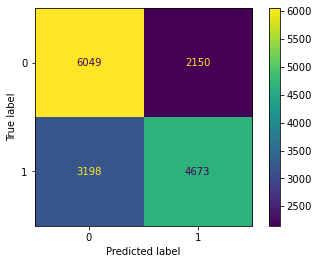

In [250]:
predictResults(myModel, x_test_std, y_test, 0)

In [251]:
#Features Importance
#if vStacking:
    #compute_feature_importance(myModel, features.iloc[:,0:(features.columns.size-1)], modelWeights)

In [252]:
#Features Importance
#if vStacking:
    #compute_feature_coef(myModel, features.iloc[:,0:(features.columns.size-1)], modelWeights)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=10,
                       min_samples_split=5, n_estimators=800, random_state=0)
Accuracy: 0.6672059738643435
              precision    recall  f1-score   support

         SLA       0.65      0.74      0.69      8199
   Violation       0.68      0.59      0.64      7871

    accuracy                           0.67     16070
   macro avg       0.67      0.67      0.66     16070
weighted avg       0.67      0.67      0.67     16070

MLPClassifier(activation='tanh', alpha=0.01, max_iter=2000, random_state=0,
              solver='sgd')
Accuracy: 0.6700684505289359
              precision    recall  f1-score   support

         SLA       0.66      0.73      0.69      8199
   Violation       0.68      0.61      0.64      7871

    accuracy                           0.67     16070
   macro avg       0.67      0.67      0.67     16070
weighted avg       0.67      0.67      0.67     16070

LogisticRegression(C=0.01, pena

<Figure size 720x720 with 0 Axes>

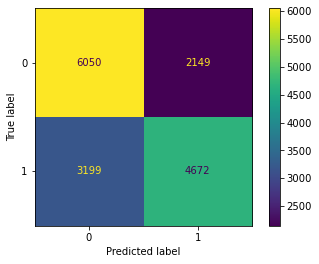

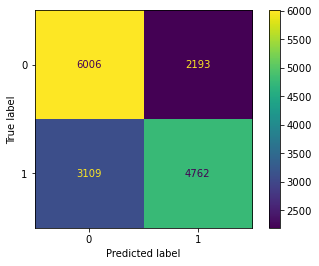

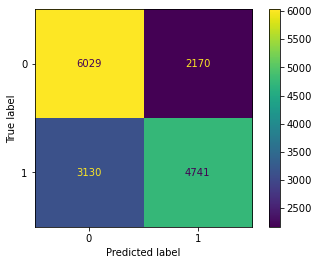

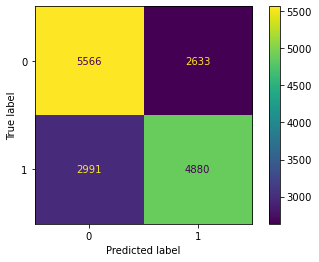

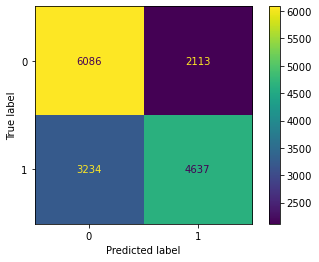

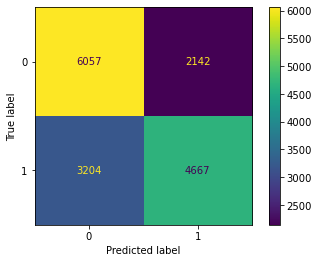

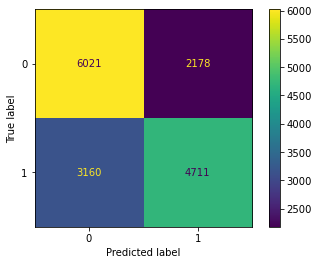

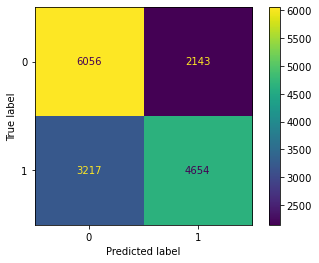

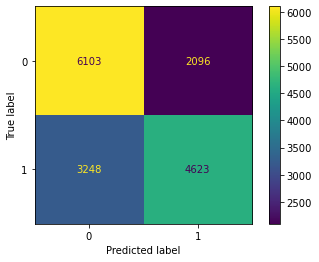

In [253]:
#model scores
voting_model_scores(myModel, x_test_std, y_test)

In [254]:
##################################
# define the hard voting ensemble
##################################
print("Finish/Start: ", datetime.now())
modelWeights = [1,1,1,1,1,1,1,1,1,1,1] 
myModel = VotingClassifier(estimators=getModels(True), weights=modelWeights, voting='hard')

Finish/Start:  2021-10-28 01:22:11.676170


In [255]:
myModel.fit(x_train_std,y_train)

[01:35:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.06095
0:	learn: 0.6847858	total: 37.1ms	remaining: 37.1s
1:	learn: 0.6771954	total: 73.6ms	remaining: 36.7s
2:	learn: 0.6704270	total: 113ms	remaining: 37.6s
3:	learn: 0.6646576	total: 150ms	remaining: 37.4s
4:	learn: 0.6594985	total: 188ms	remaining: 37.4s
5:	learn: 0.6549191	total: 228ms	remaining: 37.8s
6:	learn: 0.6508218	total: 267ms	remaining: 37.9s
7:	learn: 0.6472960	total: 305ms	remaining: 37.9s
8:	learn: 0.6442342	total: 341ms	remaining: 37.6s
9:	learn: 0.6414397	total: 381ms	remaining: 37.7s
10:	learn: 0.6389906	total: 418ms	remaining: 37.6s
11:	learn: 0.6369273	total: 451ms	remaining: 37.2s
12:	learn: 0.6350985	total: 485ms	remaining: 36.8s
13:	le

157:	learn: 0.6186227	total: 4.85s	remaining: 25.8s
158:	learn: 0.6186032	total: 4.88s	remaining: 25.8s
159:	learn: 0.6185932	total: 4.91s	remaining: 25.8s
160:	learn: 0.6185861	total: 4.94s	remaining: 25.7s
161:	learn: 0.6185629	total: 4.97s	remaining: 25.7s
162:	learn: 0.6185627	total: 5s	remaining: 25.7s
163:	learn: 0.6185626	total: 5.03s	remaining: 25.6s
164:	learn: 0.6185396	total: 5.06s	remaining: 25.6s
165:	learn: 0.6185397	total: 5.09s	remaining: 25.6s
166:	learn: 0.6185407	total: 5.12s	remaining: 25.5s
167:	learn: 0.6185404	total: 5.15s	remaining: 25.5s
168:	learn: 0.6185404	total: 5.17s	remaining: 25.4s
169:	learn: 0.6185291	total: 5.21s	remaining: 25.4s
170:	learn: 0.6185300	total: 5.23s	remaining: 25.4s
171:	learn: 0.6184989	total: 5.27s	remaining: 25.4s
172:	learn: 0.6185002	total: 5.3s	remaining: 25.3s
173:	learn: 0.6185002	total: 5.33s	remaining: 25.3s
174:	learn: 0.6185006	total: 5.37s	remaining: 25.3s
175:	learn: 0.6184866	total: 5.41s	remaining: 25.3s
176:	learn: 0.61

322:	learn: 0.6172932	total: 9.93s	remaining: 20.8s
323:	learn: 0.6172875	total: 9.96s	remaining: 20.8s
324:	learn: 0.6172842	total: 9.99s	remaining: 20.7s
325:	learn: 0.6172836	total: 10s	remaining: 20.7s
326:	learn: 0.6172818	total: 10s	remaining: 20.7s
327:	learn: 0.6172732	total: 10.1s	remaining: 20.6s
328:	learn: 0.6172718	total: 10.1s	remaining: 20.6s
329:	learn: 0.6172688	total: 10.1s	remaining: 20.6s
330:	learn: 0.6172687	total: 10.2s	remaining: 20.6s
331:	learn: 0.6172655	total: 10.2s	remaining: 20.5s
332:	learn: 0.6172551	total: 10.2s	remaining: 20.5s
333:	learn: 0.6172530	total: 10.3s	remaining: 20.4s
334:	learn: 0.6172427	total: 10.3s	remaining: 20.4s
335:	learn: 0.6172356	total: 10.3s	remaining: 20.4s
336:	learn: 0.6172331	total: 10.3s	remaining: 20.3s
337:	learn: 0.6172213	total: 10.4s	remaining: 20.3s
338:	learn: 0.6172102	total: 10.4s	remaining: 20.3s
339:	learn: 0.6172063	total: 10.4s	remaining: 20.2s
340:	learn: 0.6172086	total: 10.5s	remaining: 20.2s
341:	learn: 0.61

482:	learn: 0.6166621	total: 14.7s	remaining: 15.8s
483:	learn: 0.6166593	total: 14.8s	remaining: 15.7s
484:	learn: 0.6166577	total: 14.8s	remaining: 15.7s
485:	learn: 0.6166562	total: 14.8s	remaining: 15.7s
486:	learn: 0.6166551	total: 14.9s	remaining: 15.6s
487:	learn: 0.6166545	total: 14.9s	remaining: 15.6s
488:	learn: 0.6166459	total: 14.9s	remaining: 15.6s
489:	learn: 0.6166466	total: 14.9s	remaining: 15.5s
490:	learn: 0.6166453	total: 15s	remaining: 15.5s
491:	learn: 0.6166438	total: 15s	remaining: 15.5s
492:	learn: 0.6166423	total: 15s	remaining: 15.4s
493:	learn: 0.6166413	total: 15s	remaining: 15.4s
494:	learn: 0.6166398	total: 15.1s	remaining: 15.4s
495:	learn: 0.6166365	total: 15.1s	remaining: 15.3s
496:	learn: 0.6166366	total: 15.1s	remaining: 15.3s
497:	learn: 0.6166380	total: 15.2s	remaining: 15.3s
498:	learn: 0.6166354	total: 15.2s	remaining: 15.2s
499:	learn: 0.6166337	total: 15.2s	remaining: 15.2s
500:	learn: 0.6166342	total: 15.2s	remaining: 15.2s
501:	learn: 0.616626

641:	learn: 0.6162829	total: 19.6s	remaining: 10.9s
642:	learn: 0.6162702	total: 19.6s	remaining: 10.9s
643:	learn: 0.6162694	total: 19.7s	remaining: 10.9s
644:	learn: 0.6162617	total: 19.7s	remaining: 10.8s
645:	learn: 0.6162576	total: 19.7s	remaining: 10.8s
646:	learn: 0.6162567	total: 19.7s	remaining: 10.8s
647:	learn: 0.6162559	total: 19.8s	remaining: 10.7s
648:	learn: 0.6162551	total: 19.8s	remaining: 10.7s
649:	learn: 0.6162551	total: 19.8s	remaining: 10.7s
650:	learn: 0.6162510	total: 19.9s	remaining: 10.6s
651:	learn: 0.6162535	total: 19.9s	remaining: 10.6s
652:	learn: 0.6162508	total: 19.9s	remaining: 10.6s
653:	learn: 0.6162479	total: 20s	remaining: 10.6s
654:	learn: 0.6162485	total: 20s	remaining: 10.5s
655:	learn: 0.6162445	total: 20s	remaining: 10.5s
656:	learn: 0.6162447	total: 20s	remaining: 10.5s
657:	learn: 0.6162443	total: 20.1s	remaining: 10.4s
658:	learn: 0.6162403	total: 20.1s	remaining: 10.4s
659:	learn: 0.6162375	total: 20.1s	remaining: 10.4s
660:	learn: 0.616236

804:	learn: 0.6159652	total: 24.5s	remaining: 5.94s
805:	learn: 0.6159616	total: 24.6s	remaining: 5.91s
806:	learn: 0.6159576	total: 24.6s	remaining: 5.88s
807:	learn: 0.6159566	total: 24.6s	remaining: 5.85s
808:	learn: 0.6159566	total: 24.7s	remaining: 5.82s
809:	learn: 0.6159531	total: 24.7s	remaining: 5.79s
810:	learn: 0.6159521	total: 24.7s	remaining: 5.76s
811:	learn: 0.6159525	total: 24.7s	remaining: 5.73s
812:	learn: 0.6159512	total: 24.8s	remaining: 5.7s
813:	learn: 0.6159514	total: 24.8s	remaining: 5.67s
814:	learn: 0.6159510	total: 24.8s	remaining: 5.63s
815:	learn: 0.6159468	total: 24.9s	remaining: 5.6s
816:	learn: 0.6159430	total: 24.9s	remaining: 5.57s
817:	learn: 0.6159435	total: 24.9s	remaining: 5.54s
818:	learn: 0.6159392	total: 24.9s	remaining: 5.51s
819:	learn: 0.6159414	total: 25s	remaining: 5.48s
820:	learn: 0.6159399	total: 25s	remaining: 5.45s
821:	learn: 0.6159398	total: 25s	remaining: 5.42s
822:	learn: 0.6159395	total: 25s	remaining: 5.38s
823:	learn: 0.6159392	

965:	learn: 0.6157392	total: 29.3s	remaining: 1.03s
966:	learn: 0.6157389	total: 29.3s	remaining: 1000ms
967:	learn: 0.6157339	total: 29.3s	remaining: 969ms
968:	learn: 0.6157318	total: 29.3s	remaining: 939ms
969:	learn: 0.6157296	total: 29.4s	remaining: 909ms
970:	learn: 0.6157278	total: 29.4s	remaining: 878ms
971:	learn: 0.6157276	total: 29.4s	remaining: 848ms
972:	learn: 0.6157272	total: 29.5s	remaining: 817ms
973:	learn: 0.6157273	total: 29.5s	remaining: 787ms
974:	learn: 0.6157259	total: 29.5s	remaining: 757ms
975:	learn: 0.6157224	total: 29.5s	remaining: 726ms
976:	learn: 0.6157206	total: 29.6s	remaining: 696ms
977:	learn: 0.6157209	total: 29.6s	remaining: 666ms
978:	learn: 0.6157194	total: 29.6s	remaining: 635ms
979:	learn: 0.6157217	total: 29.7s	remaining: 605ms
980:	learn: 0.6157217	total: 29.7s	remaining: 575ms
981:	learn: 0.6157230	total: 29.7s	remaining: 545ms
982:	learn: 0.6157216	total: 29.8s	remaining: 515ms
983:	learn: 0.6157217	total: 29.8s	remaining: 485ms
984:	learn:

VotingClassifier(estimators=[('RFC',
                              RandomForestClassifier(bootstrap=False,
                                                     criterion='entropy',
                                                     max_depth=10,
                                                     min_samples_split=5,
                                                     n_estimators=800,
                                                     random_state=0)),
                             ('MLP',
                              MLPClassifier(activation='tanh', alpha=0.01,
                                            max_iter=2000, random_state=0,
                                            solver='sgd')),
                             ('LR',
                              LogisticRegression(C=0.01, penalty='l1',
                                                 random_state=0,
                                                 solver='liblinear')),
                             ('KNN', KNeigh...

              precision    recall  f1-score   support

         SLA       0.65      0.73      0.69      8199
   Violation       0.68      0.60      0.64      7871

    accuracy                           0.67     16070
   macro avg       0.67      0.67      0.66     16070
weighted avg       0.67      0.67      0.66     16070

Accuracy:  0.6666459240821406
MSE: 0.33335407591785937
RMSE: 0.5773682325153154
R2: -0.33397203215671456
MEA: 0.33335407591785937


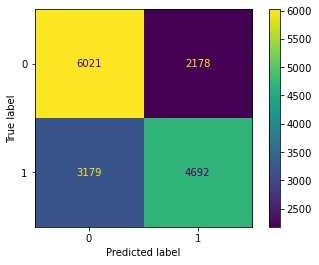

In [256]:
predictResults(myModel, x_test_std, y_test, 0)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=10,
                       min_samples_split=5, n_estimators=800, random_state=0)
Accuracy: 0.6672059738643435
              precision    recall  f1-score   support

         SLA       0.65      0.74      0.69      8199
   Violation       0.68      0.59      0.64      7871

    accuracy                           0.67     16070
   macro avg       0.67      0.67      0.66     16070
weighted avg       0.67      0.67      0.67     16070

MLPClassifier(activation='tanh', alpha=0.01, max_iter=2000, random_state=0,
              solver='sgd')
Accuracy: 0.6700684505289359
              precision    recall  f1-score   support

         SLA       0.66      0.73      0.69      8199
   Violation       0.68      0.61      0.64      7871

    accuracy                           0.67     16070
   macro avg       0.67      0.67      0.67     16070
weighted avg       0.67      0.67      0.67     16070

LogisticRegression(C=0.01, pena

<Figure size 720x720 with 0 Axes>

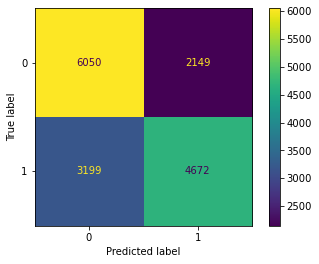

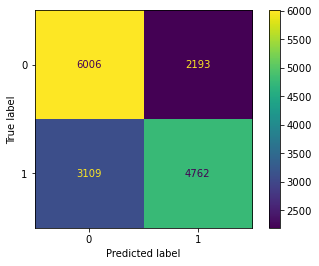

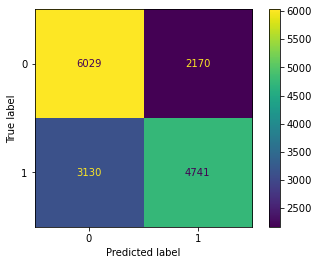

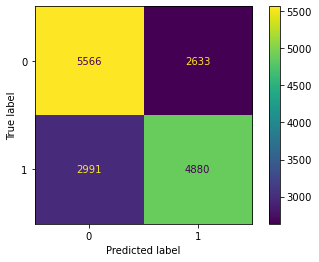

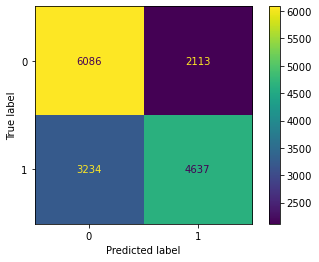

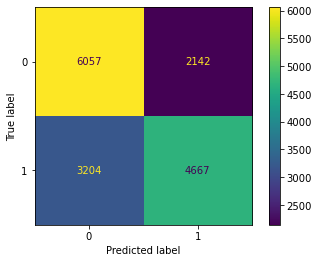

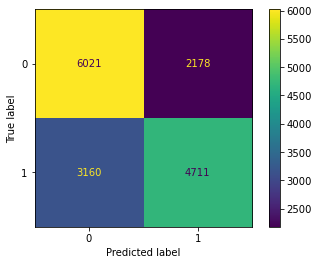

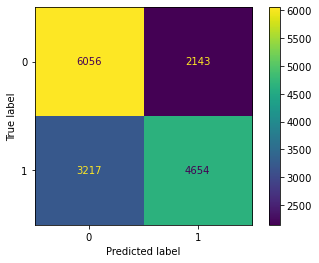

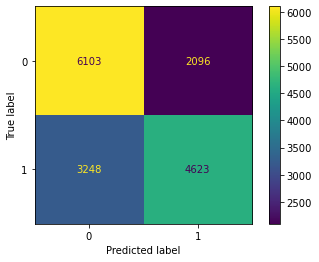

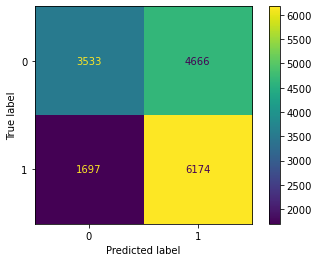

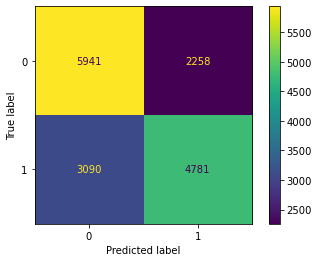

In [257]:
#model scores
voting_model_scores(myModel, x_test_std, y_test)

In [258]:
if vStacking:
    compute_feature_importance(myModel, features.iloc[:,0:(features.columns.size-1)], modelWeights)

In [259]:
if vStacking:
    compute_feature_coef(myModel, features.iloc[:,0:(features.columns.size-1)], modelWeights)

In [76]:
####################################### 
print("Start/Finish: ", datetime.now())

Start/Finish:  2021-11-09 08:53:23.466762


In [262]:
# restore std values
x_train_std = x_train_std_bkp
x_test_std = x_test_std_bkp

In [78]:
##################################
# define blending ensemble
##################################

In [79]:
# split training set into train and validation sets
X_train, X_val, Y_train, y_val = train_test_split(x_train_std, y_train, test_size=0.2, random_state=0)

In [80]:
modelWeights = [1,1,1,1,1,1,1,1,1] 
myBlender=VotingClassifier(estimators=getModels(False), weights=modelWeights, voting='soft')

In [81]:
models = getModels(True)

In [82]:
myModel = fit_ensemble(models, X_train, X_val, Y_train, y_val, myBlender)

[10:07:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.05541
0:	learn: 0.6859771	total: 85.8ms	remaining: 1m 25s
1:	learn: 0.6796726	total: 134ms	remaining: 1m 6s
2:	learn: 0.6743541	total: 162ms	remaining: 53.8s
3:	learn: 0.6696870	total: 191ms	remaining: 47.7s
4:	learn: 0.6652040	total: 213ms	remaining: 42.4s
5:	learn: 0.6619687	total: 233ms	remaining: 38.6s
6:	learn: 0.6582962	total: 259ms	remaining: 36.8s
7:	learn: 0.6551572	total: 279ms	remaining: 34.6s
8:	learn: 0.6525142	total: 297ms	remaining: 32.7s
9:	learn: 0.6501690	total: 311ms	remaining: 30.8s
10:	learn: 0.6479247	total: 324ms	remaining: 29.1s
11:	learn: 0.6459049	total: 340ms	remaining: 28s
12:	learn: 0.6441481	total: 357ms	remaining: 27.1s
13:	lear

162:	learn: 0.6078582	total: 2.52s	remaining: 12.9s
163:	learn: 0.6078111	total: 2.53s	remaining: 12.9s
164:	learn: 0.6077453	total: 2.54s	remaining: 12.9s
165:	learn: 0.6076944	total: 2.56s	remaining: 12.9s
166:	learn: 0.6076022	total: 2.58s	remaining: 12.8s
167:	learn: 0.6075208	total: 2.59s	remaining: 12.8s
168:	learn: 0.6074604	total: 2.6s	remaining: 12.8s
169:	learn: 0.6073786	total: 2.62s	remaining: 12.8s
170:	learn: 0.6073046	total: 2.63s	remaining: 12.8s
171:	learn: 0.6072426	total: 2.65s	remaining: 12.7s
172:	learn: 0.6070654	total: 2.66s	remaining: 12.7s
173:	learn: 0.6069934	total: 2.67s	remaining: 12.7s
174:	learn: 0.6069024	total: 2.68s	remaining: 12.7s
175:	learn: 0.6067984	total: 2.7s	remaining: 12.6s
176:	learn: 0.6066884	total: 2.71s	remaining: 12.6s
177:	learn: 0.6066127	total: 2.73s	remaining: 12.6s
178:	learn: 0.6065405	total: 2.75s	remaining: 12.6s
179:	learn: 0.6064881	total: 2.76s	remaining: 12.6s
180:	learn: 0.6064522	total: 2.77s	remaining: 12.6s
181:	learn: 0.

324:	learn: 0.5960575	total: 4.88s	remaining: 10.1s
325:	learn: 0.5959887	total: 4.89s	remaining: 10.1s
326:	learn: 0.5959245	total: 4.91s	remaining: 10.1s
327:	learn: 0.5958327	total: 4.92s	remaining: 10.1s
328:	learn: 0.5957646	total: 4.94s	remaining: 10.1s
329:	learn: 0.5956862	total: 4.95s	remaining: 10.1s
330:	learn: 0.5956335	total: 4.97s	remaining: 10s
331:	learn: 0.5955801	total: 4.98s	remaining: 10s
332:	learn: 0.5955169	total: 5s	remaining: 10s
333:	learn: 0.5954281	total: 5.01s	remaining: 9.99s
334:	learn: 0.5953851	total: 5.02s	remaining: 9.97s
335:	learn: 0.5953257	total: 5.04s	remaining: 9.96s
336:	learn: 0.5952767	total: 5.05s	remaining: 9.94s
337:	learn: 0.5952191	total: 5.07s	remaining: 9.93s
338:	learn: 0.5951718	total: 5.08s	remaining: 9.9s
339:	learn: 0.5951054	total: 5.09s	remaining: 9.88s
340:	learn: 0.5950610	total: 5.1s	remaining: 9.86s
341:	learn: 0.5950246	total: 5.12s	remaining: 9.84s
342:	learn: 0.5949724	total: 5.13s	remaining: 9.83s
343:	learn: 0.5948966	t

490:	learn: 0.5863605	total: 7.02s	remaining: 7.28s
491:	learn: 0.5863009	total: 7.04s	remaining: 7.26s
492:	learn: 0.5862411	total: 7.04s	remaining: 7.25s
493:	learn: 0.5861831	total: 7.05s	remaining: 7.23s
494:	learn: 0.5861322	total: 7.07s	remaining: 7.21s
495:	learn: 0.5860767	total: 7.08s	remaining: 7.19s
496:	learn: 0.5860254	total: 7.09s	remaining: 7.18s
497:	learn: 0.5859740	total: 7.1s	remaining: 7.16s
498:	learn: 0.5859148	total: 7.11s	remaining: 7.14s
499:	learn: 0.5858708	total: 7.13s	remaining: 7.13s
500:	learn: 0.5858201	total: 7.14s	remaining: 7.11s
501:	learn: 0.5857496	total: 7.15s	remaining: 7.09s
502:	learn: 0.5856957	total: 7.16s	remaining: 7.08s
503:	learn: 0.5856567	total: 7.17s	remaining: 7.06s
504:	learn: 0.5856058	total: 7.18s	remaining: 7.04s
505:	learn: 0.5855567	total: 7.2s	remaining: 7.03s
506:	learn: 0.5855143	total: 7.21s	remaining: 7.01s
507:	learn: 0.5854568	total: 7.22s	remaining: 6.99s
508:	learn: 0.5854111	total: 7.23s	remaining: 6.98s
509:	learn: 0.

653:	learn: 0.5781571	total: 9.17s	remaining: 4.85s
654:	learn: 0.5781271	total: 9.18s	remaining: 4.83s
655:	learn: 0.5780909	total: 9.19s	remaining: 4.82s
656:	learn: 0.5780372	total: 9.21s	remaining: 4.8s
657:	learn: 0.5779879	total: 9.22s	remaining: 4.79s
658:	learn: 0.5779206	total: 9.23s	remaining: 4.78s
659:	learn: 0.5778618	total: 9.25s	remaining: 4.76s
660:	learn: 0.5778101	total: 9.26s	remaining: 4.75s
661:	learn: 0.5777689	total: 9.28s	remaining: 4.74s
662:	learn: 0.5777365	total: 9.29s	remaining: 4.72s
663:	learn: 0.5777074	total: 9.31s	remaining: 4.71s
664:	learn: 0.5776714	total: 9.32s	remaining: 4.7s
665:	learn: 0.5776156	total: 9.34s	remaining: 4.68s
666:	learn: 0.5775897	total: 9.36s	remaining: 4.67s
667:	learn: 0.5775348	total: 9.37s	remaining: 4.66s
668:	learn: 0.5774916	total: 9.39s	remaining: 4.65s
669:	learn: 0.5774334	total: 9.41s	remaining: 4.63s
670:	learn: 0.5773867	total: 9.42s	remaining: 4.62s
671:	learn: 0.5773432	total: 9.44s	remaining: 4.61s
672:	learn: 0.

823:	learn: 0.5708725	total: 11.5s	remaining: 2.46s
824:	learn: 0.5708305	total: 11.5s	remaining: 2.44s
825:	learn: 0.5708003	total: 11.5s	remaining: 2.43s
826:	learn: 0.5707522	total: 11.5s	remaining: 2.42s
827:	learn: 0.5706963	total: 11.6s	remaining: 2.4s
828:	learn: 0.5706453	total: 11.6s	remaining: 2.39s
829:	learn: 0.5705910	total: 11.6s	remaining: 2.37s
830:	learn: 0.5705439	total: 11.6s	remaining: 2.36s
831:	learn: 0.5704948	total: 11.6s	remaining: 2.35s
832:	learn: 0.5704597	total: 11.6s	remaining: 2.33s
833:	learn: 0.5704217	total: 11.6s	remaining: 2.32s
834:	learn: 0.5703760	total: 11.7s	remaining: 2.3s
835:	learn: 0.5703313	total: 11.7s	remaining: 2.29s
836:	learn: 0.5702990	total: 11.7s	remaining: 2.27s
837:	learn: 0.5702520	total: 11.7s	remaining: 2.26s
838:	learn: 0.5702098	total: 11.7s	remaining: 2.25s
839:	learn: 0.5701731	total: 11.7s	remaining: 2.23s
840:	learn: 0.5701265	total: 11.7s	remaining: 2.22s
841:	learn: 0.5700750	total: 11.8s	remaining: 2.21s
842:	learn: 0.

987:	learn: 0.5644162	total: 13.8s	remaining: 168ms
988:	learn: 0.5643595	total: 13.8s	remaining: 154ms
989:	learn: 0.5643235	total: 13.9s	remaining: 140ms
990:	learn: 0.5642767	total: 13.9s	remaining: 126ms
991:	learn: 0.5642548	total: 13.9s	remaining: 112ms
992:	learn: 0.5642035	total: 13.9s	remaining: 98.1ms
993:	learn: 0.5641612	total: 13.9s	remaining: 84ms
994:	learn: 0.5641263	total: 13.9s	remaining: 70ms
995:	learn: 0.5640870	total: 14s	remaining: 56ms
996:	learn: 0.5640526	total: 14s	remaining: 42ms
997:	learn: 0.5640332	total: 14s	remaining: 28ms
998:	learn: 0.5639987	total: 14s	remaining: 14ms
999:	learn: 0.5639566	total: 14s	remaining: 0us
[10:09:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.030656
0

150:	learn: 0.6115376	total: 1.19s	remaining: 6.69s
151:	learn: 0.6114423	total: 1.2s	remaining: 6.67s
152:	learn: 0.6113882	total: 1.2s	remaining: 6.66s
153:	learn: 0.6113503	total: 1.21s	remaining: 6.64s
154:	learn: 0.6113313	total: 1.22s	remaining: 6.64s
155:	learn: 0.6112505	total: 1.23s	remaining: 6.64s
156:	learn: 0.6111715	total: 1.24s	remaining: 6.65s
157:	learn: 0.6110904	total: 1.25s	remaining: 6.66s
158:	learn: 0.6110630	total: 1.26s	remaining: 6.66s
159:	learn: 0.6110082	total: 1.27s	remaining: 6.67s
160:	learn: 0.6109473	total: 1.28s	remaining: 6.67s
161:	learn: 0.6108710	total: 1.29s	remaining: 6.67s
162:	learn: 0.6108148	total: 1.3s	remaining: 6.66s
163:	learn: 0.6107805	total: 1.3s	remaining: 6.64s
164:	learn: 0.6107805	total: 1.3s	remaining: 6.61s
165:	learn: 0.6107803	total: 1.31s	remaining: 6.58s
166:	learn: 0.6107602	total: 1.32s	remaining: 6.59s
167:	learn: 0.6107281	total: 1.33s	remaining: 6.58s
168:	learn: 0.6107266	total: 1.33s	remaining: 6.56s
169:	learn: 0.610

328:	learn: 0.6078630	total: 2.38s	remaining: 4.85s
329:	learn: 0.6078643	total: 2.38s	remaining: 4.84s
330:	learn: 0.6078558	total: 2.39s	remaining: 4.83s
331:	learn: 0.6078559	total: 2.39s	remaining: 4.82s
332:	learn: 0.6078397	total: 2.4s	remaining: 4.81s
333:	learn: 0.6078267	total: 2.41s	remaining: 4.81s
334:	learn: 0.6078150	total: 2.42s	remaining: 4.8s
335:	learn: 0.6078044	total: 2.43s	remaining: 4.8s
336:	learn: 0.6077634	total: 2.44s	remaining: 4.79s
337:	learn: 0.6077301	total: 2.44s	remaining: 4.79s
338:	learn: 0.6077243	total: 2.45s	remaining: 4.78s
339:	learn: 0.6076952	total: 2.46s	remaining: 4.77s
340:	learn: 0.6076653	total: 2.46s	remaining: 4.76s
341:	learn: 0.6076115	total: 2.47s	remaining: 4.75s
342:	learn: 0.6075714	total: 2.48s	remaining: 4.74s
343:	learn: 0.6075539	total: 2.48s	remaining: 4.73s
344:	learn: 0.6075182	total: 2.49s	remaining: 4.73s
345:	learn: 0.6075095	total: 2.5s	remaining: 4.73s
346:	learn: 0.6074919	total: 2.51s	remaining: 4.72s
347:	learn: 0.60

511:	learn: 0.6045911	total: 3.59s	remaining: 3.42s
512:	learn: 0.6045741	total: 3.59s	remaining: 3.41s
513:	learn: 0.6045567	total: 3.6s	remaining: 3.4s
514:	learn: 0.6045200	total: 3.6s	remaining: 3.39s
515:	learn: 0.6045062	total: 3.61s	remaining: 3.38s
516:	learn: 0.6044996	total: 3.61s	remaining: 3.37s
517:	learn: 0.6044804	total: 3.62s	remaining: 3.37s
518:	learn: 0.6044765	total: 3.63s	remaining: 3.36s
519:	learn: 0.6044546	total: 3.63s	remaining: 3.35s
520:	learn: 0.6044474	total: 3.64s	remaining: 3.35s
521:	learn: 0.6044399	total: 3.65s	remaining: 3.34s
522:	learn: 0.6044339	total: 3.65s	remaining: 3.33s
523:	learn: 0.6044012	total: 3.66s	remaining: 3.33s
524:	learn: 0.6043643	total: 3.67s	remaining: 3.32s
525:	learn: 0.6043615	total: 3.68s	remaining: 3.31s
526:	learn: 0.6043332	total: 3.68s	remaining: 3.3s
527:	learn: 0.6043271	total: 3.69s	remaining: 3.29s
528:	learn: 0.6043109	total: 3.7s	remaining: 3.29s
529:	learn: 0.6042899	total: 3.7s	remaining: 3.29s
530:	learn: 0.6042

672:	learn: 0.6025720	total: 4.8s	remaining: 2.33s
673:	learn: 0.6025569	total: 4.81s	remaining: 2.33s
674:	learn: 0.6025421	total: 4.83s	remaining: 2.32s
675:	learn: 0.6025284	total: 4.84s	remaining: 2.32s
676:	learn: 0.6025265	total: 4.85s	remaining: 2.31s
677:	learn: 0.6025136	total: 4.86s	remaining: 2.31s
678:	learn: 0.6025012	total: 4.87s	remaining: 2.3s
679:	learn: 0.6024862	total: 4.88s	remaining: 2.3s
680:	learn: 0.6024686	total: 4.89s	remaining: 2.29s
681:	learn: 0.6024535	total: 4.9s	remaining: 2.29s
682:	learn: 0.6024430	total: 4.91s	remaining: 2.28s
683:	learn: 0.6024405	total: 4.92s	remaining: 2.27s
684:	learn: 0.6024243	total: 4.93s	remaining: 2.27s
685:	learn: 0.6024101	total: 4.94s	remaining: 2.26s
686:	learn: 0.6024073	total: 4.95s	remaining: 2.26s
687:	learn: 0.6024027	total: 4.96s	remaining: 2.25s
688:	learn: 0.6023927	total: 4.97s	remaining: 2.25s
689:	learn: 0.6023826	total: 4.98s	remaining: 2.24s
690:	learn: 0.6023789	total: 4.99s	remaining: 2.23s
691:	learn: 0.60

846:	learn: 0.6012659	total: 6.21s	remaining: 1.12s
847:	learn: 0.6012601	total: 6.22s	remaining: 1.11s
848:	learn: 0.6012477	total: 6.23s	remaining: 1.11s
849:	learn: 0.6012350	total: 6.24s	remaining: 1.1s
850:	learn: 0.6012209	total: 6.25s	remaining: 1.09s
851:	learn: 0.6012098	total: 6.26s	remaining: 1.09s
852:	learn: 0.6012087	total: 6.26s	remaining: 1.08s
853:	learn: 0.6012077	total: 6.27s	remaining: 1.07s
854:	learn: 0.6011976	total: 6.29s	remaining: 1.06s
855:	learn: 0.6011897	total: 6.3s	remaining: 1.06s
856:	learn: 0.6011862	total: 6.31s	remaining: 1.05s
857:	learn: 0.6011742	total: 6.32s	remaining: 1.04s
858:	learn: 0.6011730	total: 6.33s	remaining: 1.04s
859:	learn: 0.6011705	total: 6.34s	remaining: 1.03s
860:	learn: 0.6011685	total: 6.35s	remaining: 1.02s
861:	learn: 0.6011594	total: 6.37s	remaining: 1.02s
862:	learn: 0.6011482	total: 6.38s	remaining: 1.01s
863:	learn: 0.6011469	total: 6.39s	remaining: 1s
864:	learn: 0.6011418	total: 6.4s	remaining: 999ms
865:	learn: 0.6011

In [83]:
meta_x, y_predict = predict_ensemble(models, myModel, x_test_std)

              precision    recall  f1-score   support

         SLA       0.65      0.72      0.69      8199
   Violation       0.67      0.60      0.64      7871

    accuracy                           0.66     16070
   macro avg       0.66      0.66      0.66     16070
weighted avg       0.66      0.66      0.66     16070

Accuracy:  0.662974486621033
MSE: 0.337025513378967
RMSE: 0.5805389852361054
R2: -0.3486639025874121
MEA: 0.337025513378967


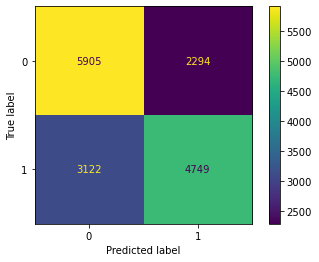

In [84]:
predictResults(myModel, meta_x, y_test, y_predict)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=10,
                       min_samples_split=5, n_estimators=800, random_state=0)
Accuracy: 0.6599875544492844
              precision    recall  f1-score   support

         SLA       0.65      0.71      0.68      8199
   Violation       0.67      0.61      0.64      7871

    accuracy                           0.66     16070
   macro avg       0.66      0.66      0.66     16070
weighted avg       0.66      0.66      0.66     16070

MLPClassifier(activation='tanh', alpha=0.01, max_iter=2000, random_state=0,
              solver='sgd')
Accuracy: 0.6665836963285625
              precision    recall  f1-score   support

         SLA       0.66      0.71      0.68      8199
   Violation       0.67      0.62      0.65      7871

    accuracy                           0.67     16070
   macro avg       0.67      0.67      0.67     16070
weighted avg       0.67      0.67      0.67     16070

LogisticRegression(C=0.01, pena

<Figure size 720x720 with 0 Axes>

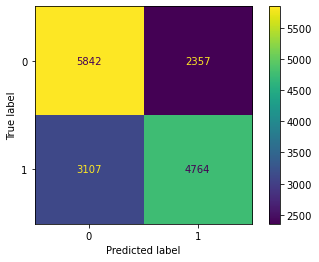

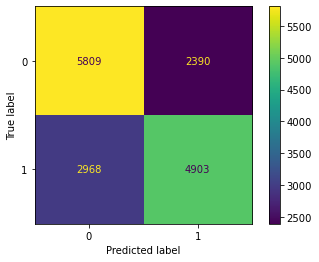

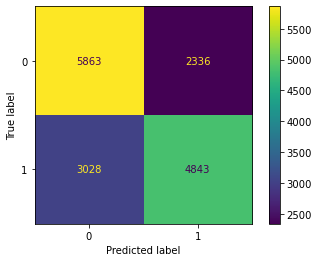

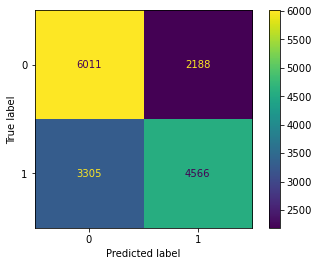

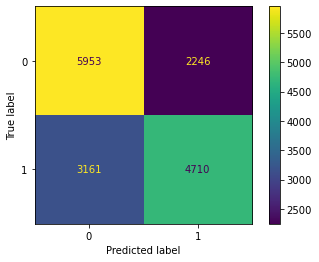

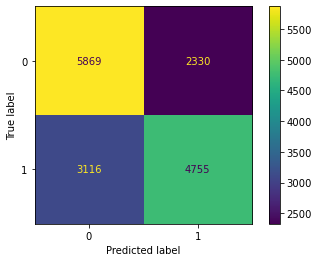

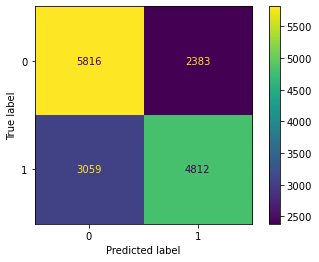

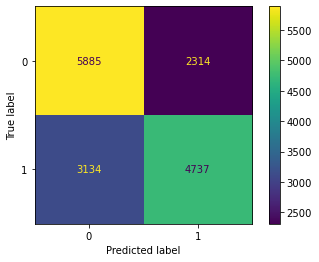

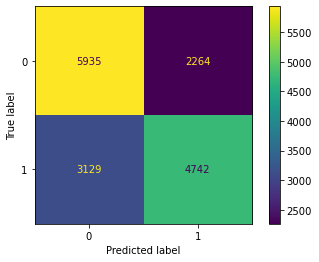

In [85]:
#model scores
voting_model_scores(myModel, meta_x, y_test)
print("Finish: ", datetime.now())

In [86]:
##################################
# define blending ensemble
##################################

In [87]:
# split training set into train and validation sets
X_train, X_val, Y_train, y_val = train_test_split(x_train_std, y_train, test_size=0.2, random_state=0)

In [88]:
modelWeights = [1,1,1,1,1,1,1,1,1,1,1] 
myBlender=VotingClassifier(estimators=getModels(True), weights=modelWeights, voting='hard')

In [89]:
models = getModels(True)

In [90]:
myModel = fit_ensemble(models, X_train, X_val, Y_train, y_val, myBlender)

[10:58:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.05541
0:	learn: 0.6859771	total: 11.8ms	remaining: 11.8s
1:	learn: 0.6796726	total: 22.4ms	remaining: 11.2s
2:	learn: 0.6743541	total: 32.9ms	remaining: 10.9s
3:	learn: 0.6696870	total: 43.5ms	remaining: 10.8s
4:	learn: 0.6652040	total: 53.9ms	remaining: 10.7s
5:	learn: 0.6619687	total: 64.4ms	remaining: 10.7s
6:	learn: 0.6582962	total: 75.7ms	remaining: 10.7s
7:	learn: 0.6551572	total: 87.3ms	remaining: 10.8s
8:	learn: 0.6525142	total: 104ms	remaining: 11.4s
9:	learn: 0.6501690	total: 123ms	remaining: 12.1s
10:	learn: 0.6479247	total: 137ms	remaining: 12.3s
11:	learn: 0.6459049	total: 152ms	remaining: 12.5s
12:	learn: 0.6441481	total: 169ms	remaining: 12.8s


162:	learn: 0.6078582	total: 2.75s	remaining: 14.1s
163:	learn: 0.6078111	total: 2.77s	remaining: 14.1s
164:	learn: 0.6077453	total: 2.78s	remaining: 14.1s
165:	learn: 0.6076944	total: 2.8s	remaining: 14.1s
166:	learn: 0.6076022	total: 2.82s	remaining: 14.1s
167:	learn: 0.6075208	total: 2.84s	remaining: 14.1s
168:	learn: 0.6074604	total: 2.86s	remaining: 14.1s
169:	learn: 0.6073786	total: 2.88s	remaining: 14s
170:	learn: 0.6073046	total: 2.89s	remaining: 14s
171:	learn: 0.6072426	total: 2.91s	remaining: 14s
172:	learn: 0.6070654	total: 2.92s	remaining: 14s
173:	learn: 0.6069934	total: 2.94s	remaining: 14s
174:	learn: 0.6069024	total: 2.95s	remaining: 13.9s
175:	learn: 0.6067984	total: 2.97s	remaining: 13.9s
176:	learn: 0.6066884	total: 2.99s	remaining: 13.9s
177:	learn: 0.6066127	total: 3.01s	remaining: 13.9s
178:	learn: 0.6065405	total: 3.03s	remaining: 13.9s
179:	learn: 0.6064881	total: 3.04s	remaining: 13.9s
180:	learn: 0.6064522	total: 3.06s	remaining: 13.8s
181:	learn: 0.6063343	t

331:	learn: 0.5955801	total: 5.51s	remaining: 11.1s
332:	learn: 0.5955169	total: 5.53s	remaining: 11.1s
333:	learn: 0.5954281	total: 5.55s	remaining: 11.1s
334:	learn: 0.5953851	total: 5.57s	remaining: 11s
335:	learn: 0.5953257	total: 5.58s	remaining: 11s
336:	learn: 0.5952767	total: 5.6s	remaining: 11s
337:	learn: 0.5952191	total: 5.61s	remaining: 11s
338:	learn: 0.5951718	total: 5.63s	remaining: 11s
339:	learn: 0.5951054	total: 5.65s	remaining: 11s
340:	learn: 0.5950610	total: 5.66s	remaining: 10.9s
341:	learn: 0.5950246	total: 5.68s	remaining: 10.9s
342:	learn: 0.5949724	total: 5.69s	remaining: 10.9s
343:	learn: 0.5948966	total: 5.71s	remaining: 10.9s
344:	learn: 0.5948342	total: 5.73s	remaining: 10.9s
345:	learn: 0.5947609	total: 5.74s	remaining: 10.9s
346:	learn: 0.5947078	total: 5.76s	remaining: 10.8s
347:	learn: 0.5946358	total: 5.78s	remaining: 10.8s
348:	learn: 0.5945644	total: 5.79s	remaining: 10.8s
349:	learn: 0.5944906	total: 5.81s	remaining: 10.8s
350:	learn: 0.5944189	tot

490:	learn: 0.5863605	total: 8.04s	remaining: 8.34s
491:	learn: 0.5863009	total: 8.06s	remaining: 8.32s
492:	learn: 0.5862411	total: 8.07s	remaining: 8.3s
493:	learn: 0.5861831	total: 8.09s	remaining: 8.28s
494:	learn: 0.5861322	total: 8.1s	remaining: 8.26s
495:	learn: 0.5860767	total: 8.12s	remaining: 8.25s
496:	learn: 0.5860254	total: 8.13s	remaining: 8.23s
497:	learn: 0.5859740	total: 8.14s	remaining: 8.21s
498:	learn: 0.5859148	total: 8.16s	remaining: 8.19s
499:	learn: 0.5858708	total: 8.17s	remaining: 8.17s
500:	learn: 0.5858201	total: 8.19s	remaining: 8.15s
501:	learn: 0.5857496	total: 8.2s	remaining: 8.13s
502:	learn: 0.5856957	total: 8.21s	remaining: 8.12s
503:	learn: 0.5856567	total: 8.23s	remaining: 8.1s
504:	learn: 0.5856058	total: 8.24s	remaining: 8.08s
505:	learn: 0.5855567	total: 8.26s	remaining: 8.06s
506:	learn: 0.5855143	total: 8.27s	remaining: 8.04s
507:	learn: 0.5854568	total: 8.28s	remaining: 8.02s
508:	learn: 0.5854111	total: 8.3s	remaining: 8s
509:	learn: 0.585390

656:	learn: 0.5780372	total: 10.6s	remaining: 5.53s
657:	learn: 0.5779879	total: 10.6s	remaining: 5.52s
658:	learn: 0.5779206	total: 10.6s	remaining: 5.5s
659:	learn: 0.5778618	total: 10.6s	remaining: 5.48s
660:	learn: 0.5778101	total: 10.7s	remaining: 5.47s
661:	learn: 0.5777689	total: 10.7s	remaining: 5.45s
662:	learn: 0.5777365	total: 10.7s	remaining: 5.43s
663:	learn: 0.5777074	total: 10.7s	remaining: 5.42s
664:	learn: 0.5776714	total: 10.7s	remaining: 5.4s
665:	learn: 0.5776156	total: 10.7s	remaining: 5.39s
666:	learn: 0.5775897	total: 10.8s	remaining: 5.37s
667:	learn: 0.5775348	total: 10.8s	remaining: 5.36s
668:	learn: 0.5774916	total: 10.8s	remaining: 5.34s
669:	learn: 0.5774334	total: 10.8s	remaining: 5.32s
670:	learn: 0.5773867	total: 10.8s	remaining: 5.31s
671:	learn: 0.5773432	total: 10.8s	remaining: 5.29s
672:	learn: 0.5772910	total: 10.9s	remaining: 5.27s
673:	learn: 0.5772586	total: 10.9s	remaining: 5.26s
674:	learn: 0.5772325	total: 10.9s	remaining: 5.24s
675:	learn: 0.

824:	learn: 0.5708305	total: 13.2s	remaining: 2.79s
825:	learn: 0.5708003	total: 13.2s	remaining: 2.77s
826:	learn: 0.5707522	total: 13.2s	remaining: 2.76s
827:	learn: 0.5706963	total: 13.2s	remaining: 2.74s
828:	learn: 0.5706453	total: 13.2s	remaining: 2.73s
829:	learn: 0.5705910	total: 13.2s	remaining: 2.71s
830:	learn: 0.5705439	total: 13.2s	remaining: 2.69s
831:	learn: 0.5704948	total: 13.3s	remaining: 2.68s
832:	learn: 0.5704597	total: 13.3s	remaining: 2.66s
833:	learn: 0.5704217	total: 13.3s	remaining: 2.64s
834:	learn: 0.5703760	total: 13.3s	remaining: 2.63s
835:	learn: 0.5703313	total: 13.3s	remaining: 2.61s
836:	learn: 0.5702990	total: 13.3s	remaining: 2.59s
837:	learn: 0.5702520	total: 13.3s	remaining: 2.58s
838:	learn: 0.5702098	total: 13.4s	remaining: 2.56s
839:	learn: 0.5701731	total: 13.4s	remaining: 2.54s
840:	learn: 0.5701265	total: 13.4s	remaining: 2.53s
841:	learn: 0.5700750	total: 13.4s	remaining: 2.51s
842:	learn: 0.5700352	total: 13.4s	remaining: 2.5s
843:	learn: 0

991:	learn: 0.5642548	total: 15.5s	remaining: 125ms
992:	learn: 0.5642035	total: 15.5s	remaining: 109ms
993:	learn: 0.5641612	total: 15.5s	remaining: 93.8ms
994:	learn: 0.5641263	total: 15.5s	remaining: 78.1ms
995:	learn: 0.5640870	total: 15.6s	remaining: 62.5ms
996:	learn: 0.5640526	total: 15.6s	remaining: 46.9ms
997:	learn: 0.5640332	total: 15.6s	remaining: 31.3ms
998:	learn: 0.5639987	total: 15.6s	remaining: 15.6ms
999:	learn: 0.5639566	total: 15.6s	remaining: 0us
[10:59:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.030656
0:	learn: 0.6887091	total: 8.06ms	remaining: 8.05s
1:	learn: 0.6843063	total: 16.3ms	remaining: 8.14s
2:	learn: 0.6802298	total: 23.9ms	remaining: 7.96s
3:	learn: 0.6763230	total: 33.2ms	r

154:	learn: 0.6113313	total: 1.04s	remaining: 5.65s
155:	learn: 0.6112505	total: 1.04s	remaining: 5.64s
156:	learn: 0.6111715	total: 1.05s	remaining: 5.64s
157:	learn: 0.6110904	total: 1.06s	remaining: 5.64s
158:	learn: 0.6110630	total: 1.06s	remaining: 5.63s
159:	learn: 0.6110082	total: 1.07s	remaining: 5.63s
160:	learn: 0.6109473	total: 1.08s	remaining: 5.63s
161:	learn: 0.6108710	total: 1.09s	remaining: 5.62s
162:	learn: 0.6108148	total: 1.09s	remaining: 5.62s
163:	learn: 0.6107805	total: 1.1s	remaining: 5.61s
164:	learn: 0.6107805	total: 1.1s	remaining: 5.59s
165:	learn: 0.6107803	total: 1.11s	remaining: 5.58s
166:	learn: 0.6107602	total: 1.12s	remaining: 5.57s
167:	learn: 0.6107281	total: 1.12s	remaining: 5.57s
168:	learn: 0.6107266	total: 1.13s	remaining: 5.56s
169:	learn: 0.6106282	total: 1.14s	remaining: 5.55s
170:	learn: 0.6106295	total: 1.14s	remaining: 5.53s
171:	learn: 0.6106274	total: 1.15s	remaining: 5.52s
172:	learn: 0.6106240	total: 1.15s	remaining: 5.51s
173:	learn: 0.

313:	learn: 0.6082498	total: 2.06s	remaining: 4.51s
314:	learn: 0.6082503	total: 2.07s	remaining: 4.5s
315:	learn: 0.6082327	total: 2.08s	remaining: 4.5s
316:	learn: 0.6081816	total: 2.09s	remaining: 4.49s
317:	learn: 0.6081355	total: 2.09s	remaining: 4.49s
318:	learn: 0.6080943	total: 2.1s	remaining: 4.49s
319:	learn: 0.6080798	total: 2.11s	remaining: 4.48s
320:	learn: 0.6080645	total: 2.12s	remaining: 4.48s
321:	learn: 0.6080406	total: 2.13s	remaining: 4.48s
322:	learn: 0.6080420	total: 2.13s	remaining: 4.46s
323:	learn: 0.6079851	total: 2.14s	remaining: 4.46s
324:	learn: 0.6079338	total: 2.14s	remaining: 4.45s
325:	learn: 0.6079334	total: 2.15s	remaining: 4.44s
326:	learn: 0.6078770	total: 2.16s	remaining: 4.44s
327:	learn: 0.6078659	total: 2.17s	remaining: 4.44s
328:	learn: 0.6078630	total: 2.17s	remaining: 4.43s
329:	learn: 0.6078643	total: 2.18s	remaining: 4.42s
330:	learn: 0.6078558	total: 2.18s	remaining: 4.41s
331:	learn: 0.6078559	total: 2.19s	remaining: 4.4s
332:	learn: 0.60

474:	learn: 0.6051262	total: 3.29s	remaining: 3.64s
475:	learn: 0.6051024	total: 3.3s	remaining: 3.63s
476:	learn: 0.6050920	total: 3.31s	remaining: 3.63s
477:	learn: 0.6050671	total: 3.32s	remaining: 3.62s
478:	learn: 0.6050611	total: 3.32s	remaining: 3.62s
479:	learn: 0.6050418	total: 3.33s	remaining: 3.61s
480:	learn: 0.6050376	total: 3.34s	remaining: 3.6s
481:	learn: 0.6050298	total: 3.35s	remaining: 3.6s
482:	learn: 0.6050158	total: 3.36s	remaining: 3.59s
483:	learn: 0.6050096	total: 3.36s	remaining: 3.59s
484:	learn: 0.6050000	total: 3.37s	remaining: 3.58s
485:	learn: 0.6049936	total: 3.38s	remaining: 3.58s
486:	learn: 0.6049869	total: 3.39s	remaining: 3.57s
487:	learn: 0.6049823	total: 3.4s	remaining: 3.57s
488:	learn: 0.6049742	total: 3.41s	remaining: 3.56s
489:	learn: 0.6049681	total: 3.42s	remaining: 3.56s
490:	learn: 0.6049626	total: 3.44s	remaining: 3.56s
491:	learn: 0.6049417	total: 3.45s	remaining: 3.56s
492:	learn: 0.6048995	total: 3.46s	remaining: 3.56s
493:	learn: 0.60

634:	learn: 0.6028991	total: 4.69s	remaining: 2.7s
635:	learn: 0.6028952	total: 4.7s	remaining: 2.69s
636:	learn: 0.6028821	total: 4.71s	remaining: 2.68s
637:	learn: 0.6028789	total: 4.72s	remaining: 2.68s
638:	learn: 0.6028718	total: 4.73s	remaining: 2.67s
639:	learn: 0.6028703	total: 4.73s	remaining: 2.66s
640:	learn: 0.6028550	total: 4.74s	remaining: 2.66s
641:	learn: 0.6028527	total: 4.75s	remaining: 2.65s
642:	learn: 0.6028386	total: 4.76s	remaining: 2.64s
643:	learn: 0.6028317	total: 4.77s	remaining: 2.64s
644:	learn: 0.6028274	total: 4.78s	remaining: 2.63s
645:	learn: 0.6028239	total: 4.79s	remaining: 2.62s
646:	learn: 0.6028097	total: 4.8s	remaining: 2.62s
647:	learn: 0.6027932	total: 4.81s	remaining: 2.61s
648:	learn: 0.6027891	total: 4.82s	remaining: 2.6s
649:	learn: 0.6027752	total: 4.82s	remaining: 2.6s
650:	learn: 0.6027660	total: 4.83s	remaining: 2.59s
651:	learn: 0.6027504	total: 4.84s	remaining: 2.58s
652:	learn: 0.6027256	total: 4.85s	remaining: 2.58s
653:	learn: 0.602

808:	learn: 0.6015742	total: 6.1s	remaining: 1.44s
809:	learn: 0.6015718	total: 6.1s	remaining: 1.43s
810:	learn: 0.6015669	total: 6.11s	remaining: 1.42s
811:	learn: 0.6015559	total: 6.12s	remaining: 1.42s
812:	learn: 0.6015534	total: 6.12s	remaining: 1.41s
813:	learn: 0.6015515	total: 6.13s	remaining: 1.4s
814:	learn: 0.6015373	total: 6.14s	remaining: 1.39s
815:	learn: 0.6015227	total: 6.14s	remaining: 1.39s
816:	learn: 0.6015090	total: 6.15s	remaining: 1.38s
817:	learn: 0.6015058	total: 6.16s	remaining: 1.37s
818:	learn: 0.6014912	total: 6.17s	remaining: 1.36s
819:	learn: 0.6014811	total: 6.17s	remaining: 1.35s
820:	learn: 0.6014720	total: 6.18s	remaining: 1.35s
821:	learn: 0.6014543	total: 6.18s	remaining: 1.34s
822:	learn: 0.6014416	total: 6.19s	remaining: 1.33s
823:	learn: 0.6014352	total: 6.2s	remaining: 1.32s
824:	learn: 0.6014324	total: 6.21s	remaining: 1.32s
825:	learn: 0.6014303	total: 6.21s	remaining: 1.31s
826:	learn: 0.6014276	total: 6.22s	remaining: 1.3s
827:	learn: 0.601

977:	learn: 0.6004241	total: 7.32s	remaining: 165ms
978:	learn: 0.6004197	total: 7.33s	remaining: 157ms
979:	learn: 0.6004087	total: 7.33s	remaining: 150ms
980:	learn: 0.6004060	total: 7.34s	remaining: 142ms
981:	learn: 0.6004055	total: 7.34s	remaining: 135ms
982:	learn: 0.6003903	total: 7.35s	remaining: 127ms
983:	learn: 0.6003855	total: 7.36s	remaining: 120ms
984:	learn: 0.6003755	total: 7.36s	remaining: 112ms
985:	learn: 0.6003750	total: 7.37s	remaining: 105ms
986:	learn: 0.6003696	total: 7.38s	remaining: 97.2ms
987:	learn: 0.6003681	total: 7.38s	remaining: 89.7ms
988:	learn: 0.6003576	total: 7.39s	remaining: 82.2ms
989:	learn: 0.6003566	total: 7.4s	remaining: 74.7ms
990:	learn: 0.6003512	total: 7.4s	remaining: 67.2ms
991:	learn: 0.6003505	total: 7.41s	remaining: 59.8ms
992:	learn: 0.6003422	total: 7.42s	remaining: 52.3ms
993:	learn: 0.6003350	total: 7.42s	remaining: 44.8ms
994:	learn: 0.6003256	total: 7.43s	remaining: 37.3ms
995:	learn: 0.6003228	total: 7.44s	remaining: 29.9ms
996:

In [91]:
meta_x, y_predict = predict_ensemble(models, myModel, x_test_std)

              precision    recall  f1-score   support

         SLA       0.65      0.72      0.69      8199
   Violation       0.68      0.60      0.64      7871

    accuracy                           0.66     16070
   macro avg       0.67      0.66      0.66     16070
weighted avg       0.66      0.66      0.66     16070

Accuracy:  0.663658991910392
MSE: 0.336341008089608
RMSE: 0.5799491426751211
R2: -0.34592474030372267
MEA: 0.336341008089608


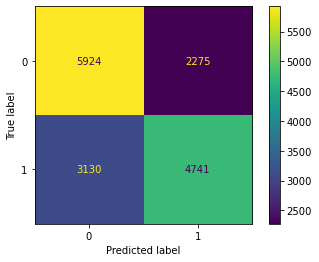

In [92]:
predictResults(myModel, meta_x, y_test, y_predict)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=10,
                       min_samples_split=5, n_estimators=800, random_state=0)
Accuracy: 0.6599875544492844
              precision    recall  f1-score   support

         SLA       0.65      0.71      0.68      8199
   Violation       0.67      0.61      0.64      7871

    accuracy                           0.66     16070
   macro avg       0.66      0.66      0.66     16070
weighted avg       0.66      0.66      0.66     16070

MLPClassifier(activation='tanh', alpha=0.01, max_iter=2000, random_state=0,
              solver='sgd')
Accuracy: 0.6665836963285625
              precision    recall  f1-score   support

         SLA       0.66      0.71      0.68      8199
   Violation       0.67      0.62      0.65      7871

    accuracy                           0.67     16070
   macro avg       0.67      0.67      0.67     16070
weighted avg       0.67      0.67      0.67     16070

LogisticRegression(C=0.01, pena

<Figure size 720x720 with 0 Axes>

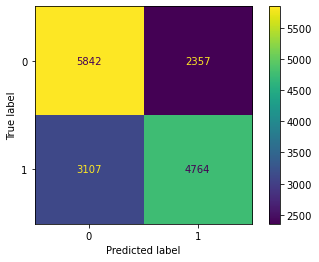

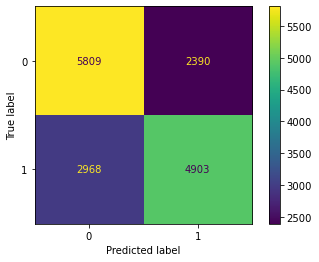

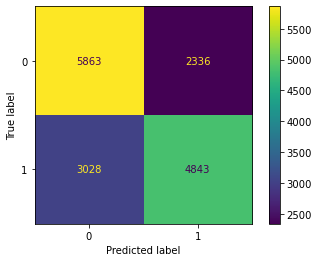

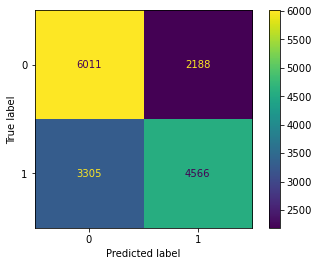

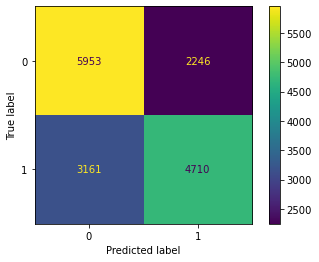

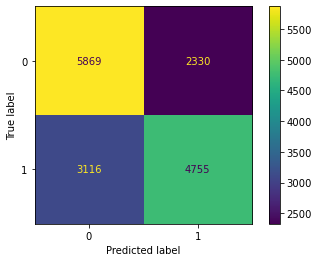

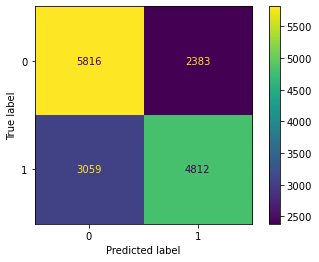

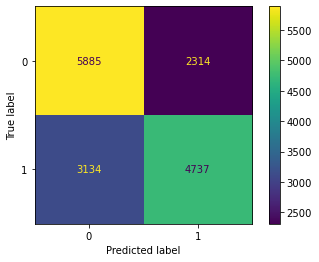

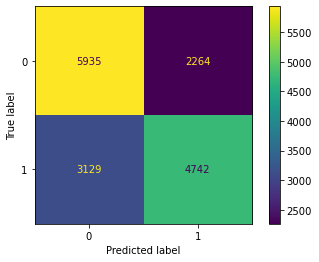

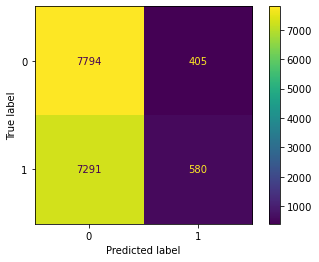

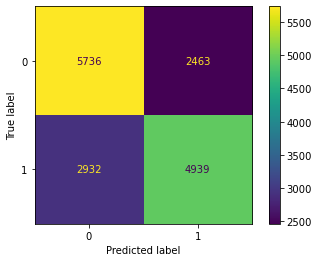

In [93]:
#model scores
voting_model_scores(myModel, meta_x, y_test)
print("Finish: ", datetime.now())

In [94]:
###########################
#PREPAIRING TRAINING
###########################
#SELECT BEST FEATURES
###########################

In [252]:
# select K best
kBest = SelectKBest(chi2, k=10)
kBest.fit_transform(x_train, y_train)

cols = kBest.get_support(indices=True)
print(cols)
print(features.iloc[:,cols].columns)

[12 13 15 18 21 24 27 29 33 40]
Index(['CFS_FIBER_INTERNET', 'CFS_FIBER_YALIN_INTERNET', 'CFS_PLAN_DSL_FTTB',
       'CFS_PLAN_FIBER_INTERNET_PON', 'SEASON_3', 'QUARTER_2',
       'BACK_TO_SCHOOL', 'REGION_1', 'REGION_5', 'CITY_POPULATION'],
      dtype='object')


In [279]:
# Feature Extraction with PCA
"""explainedVarianceRatios=[]
for i in range(1, 20):
    myPCA=PCA(n_components=i)
    myPCA.fit_transform(x_train_std)
    explainedVarianceRatios.append(myPCA.explained_variance_ratio_.sum()*100)
plt.plot(range(1, 20),explainedVarianceRatios)
#plt.show(grid=True)"""

'explainedVarianceRatios=[]\nfor i in range(1, 20):\n    myPCA=PCA(n_components=i)\n    myPCA.fit_transform(x_train_std)\n    explainedVarianceRatios.append(myPCA.explained_variance_ratio_.sum()*100)\nplt.plot(range(1, 20),explainedVarianceRatios)\n#plt.show(grid=True)'

In [280]:
# Feature Extraction with RFE for LR
# feature extraction
model = LogisticRegression(solver='lbfgs')
rfe = RFE(model, n_features_to_select=10)
fit = rfe.fit(x_train_std, y_train)
#print("Score:", model.score(x_test_std, y_test))
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

cols = fit.get_support(indices=True)
print(cols)
print(features.iloc[:,cols].columns)

Num Features: 10
Selected Features: [False False False False False  True False  True False False False False
  True  True False  True False False  True False False False False False
  True False False False  True False False False False  True False False
 False False  True False False False False False False]
Feature Ranking: [23 25 27 24 21  1 26  1  9 17 30 29  1  1 11  1 12 32  1 10 28 16  7  4
  1 13 14  8  1 19 31 20  2  1  6  3 18 15  1 22  5 33 34 35 36]
[ 5  7 12 13 15 18 24 28 33 38]
Index(['DAY_SATURDAY', 'PRIORITY', 'CFS_FIBER_INTERNET',
       'CFS_FIBER_YALIN_INTERNET', 'CFS_PLAN_DSL_FTTB',
       'CFS_PLAN_FIBER_INTERNET_PON', 'QUARTER_2', 'EXTRA_OPERATION',
       'REGION_5', 'REGION_10'],
      dtype='object')


In [64]:
features.columns

Index(['DAY_TUESDAY', 'DAY_MONDAY', 'DAY_WEDNESDAY', 'DAY_THURSDAY',
       'DAY_FRIDAY', 'DAY_SATURDAY', 'DAY_SUNDAY', 'MONTH_1', 'MONTH_2',
       'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6', 'MONTH_7', 'MONTH_8',
       'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12', 'PRIORITY', 'CFS_ADSL',
       'CFS_NDSL', 'CFS_NVDSL', 'CFS_VDSL2', 'CFS_FIBER_INTERNET',
       'CFS_FIBER_YALIN_INTERNET', 'CFS_PLAN_DSL_BAKIR', 'CFS_PLAN_DSL_FTTB',
       'CFS_PLAN_DSL_FTTC', 'CFS_PLAN_FIBER_INTERNET_AON',
       'CFS_PLAN_FIBER_INTERNET_PON', 'SEASON_1', 'SEASON_2', 'SEASON_3',
       'SEASON_4', 'QUARTER_1', 'QUARTER_2', 'QUARTER_3', 'QUARTER_4',
       'BACK_TO_SCHOOL', 'EXTRA_FEE', 'WEEKEND',
       'REGION_ADANA BÖLGE MÜDÜRLÜĞÜ', 'REGION_ANKARA BÖLGE MÜDÜRLÜĞÜ',
       'REGION_ANTALYA BÖLGE MÜDÜRLÜĞÜ', 'REGION_BURSA BÖLGE MÜDÜRLÜĞÜ',
       'REGION_DİYARBAKIR BÖLGE MÜDÜRLÜĞÜ', 'REGION_ERZURUM BÖLGE MÜDÜRLÜĞÜ',
       'REGION_KAYSERİ BÖLGE MÜDÜRLÜĞÜ', 'REGION_SAMSUN BÖLGE MÜDÜRLÜĞÜ',
       'REGI

In [65]:
# Feature Extraction with RFE for RFC
# feature extraction
model = RandomForestClassifier(random_state=0, n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features='auto', max_depth= 10, criterion= 'entropy', bootstrap= False)
rfe = RFE(model, n_features_to_select=10)
fit = rfe.fit(x_train_std, y_train)
#print("Score:", model.score(x_test_std, y_test))
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

cols = fit.get_support(indices=True)
print(cols)
print(features.iloc[:,cols].columns)

Num Features: 10
Selected Features: [False False False False False  True False False False False False False
 False False False False False False False  True  True  True False False
 False False False  True False False  True False False  True False False
 False False False  True  True False False False False False False False
 False False False False False  True False False False False False False
 False False False]
Feature Ranking: [27 32 22 35  8  1 34 36 46 42 47 44 37 29 24  9 48 50 45  1  1  1  6  5
 10 11  7  1 17 54  1  4 40  1 31 39  2 30 14  1  1 18 41 43 20 13 15 51
 49 52 23 12 38  1 21  3 33 26 53 16 25 19 28]
[ 5 19 20 21 27 30 33 39 40 53]
Index(['DAY_SATURDAY', 'PRIORITY', 'CFS_ADSL', 'CFS_NDSL', 'CFS_PLAN_DSL_FTTB',
       'CFS_PLAN_FIBER_INTERNET_PON', 'SEASON_3', 'BACK_TO_SCHOOL',
       'EXTRA_FEE', 'CITY_POPULATION'],
      dtype='object')


In [70]:
##########################################
# GRID SEARCH and RANDOM SEARCH FOR MODELS
##########################################

In [72]:
#LogisticRegression Grid Search
# define search space
parameter_space = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'C': [0.01, 0.1, 1, 10, 100],
    'random_state': [0]
}
gridSearch(LogisticRegression(), parameter_space, x_train_std, y_train, 'recall')

Start:  2021-09-30 12:58:43.606893
Best Score: 0.5550862707737906
Best Hyperparameters: {'C': 0.01, 'penalty': 'l1', 'random_state': 0, 'solver': 'liblinear'}
End:  2021-09-30 13:33:07.702151
0.609 0.553 for {'C': 0.01, 'penalty': 'none', 'random_state': 0, 'solver': 'newton-cg'}
0.609 0.553 for {'C': 0.01, 'penalty': 'none', 'random_state': 0, 'solver': 'lbfgs'}
nan nan for {'C': 0.01, 'penalty': 'none', 'random_state': 0, 'solver': 'liblinear'}
0.609 0.553 for {'C': 0.01, 'penalty': 'none', 'random_state': 0, 'solver': 'sag'}
0.609 0.553 for {'C': 0.01, 'penalty': 'none', 'random_state': 0, 'solver': 'saga'}
nan nan for {'C': 0.01, 'penalty': 'l1', 'random_state': 0, 'solver': 'newton-cg'}
nan nan for {'C': 0.01, 'penalty': 'l1', 'random_state': 0, 'solver': 'lbfgs'}
0.609 0.555 for {'C': 0.01, 'penalty': 'l1', 'random_state': 0, 'solver': 'liblinear'}
nan nan for {'C': 0.01, 'penalty': 'l1', 'random_state': 0, 'solver': 'sag'}
0.609 0.549 for {'C': 0.01, 'penalty': 'l1', 'random_sta

In [122]:
#KNeighborsClassifier Random Search
# define search space
parameter_space = {
    'n_neighbors': list(range(3, 22, 2)),
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'weights': ['uniform', 'distance'],
    'leaf_size': list(range(20, 41, 5)),
    'p': [1, 2]
}                        
randomSearch(KNeighborsClassifier(), parameter_space, x_train_std, y_train, 'recall', 50)

Start:  2021-09-23 17:10:37.304636
Best Score: 0.5941357044564413
Best Hyperparameters: {'weights': 'uniform', 'p': 2, 'n_neighbors': 19, 'metric': 'minkowski', 'leaf_size': 40}
End:  2021-09-24 03:29:09.552967
0.600 0.588 for {'weights': 'uniform', 'p': 2, 'n_neighbors': 19, 'metric': 'manhattan', 'leaf_size': 35}
0.573 0.579 for {'weights': 'uniform', 'p': 2, 'n_neighbors': 3, 'metric': 'euclidean', 'leaf_size': 25}
0.597 0.588 for {'weights': 'uniform', 'p': 1, 'n_neighbors': 15, 'metric': 'minkowski', 'leaf_size': 25}
0.594 0.583 for {'weights': 'distance', 'p': 2, 'n_neighbors': 21, 'metric': 'minkowski', 'leaf_size': 35}
0.575 0.557 for {'weights': 'distance', 'p': 1, 'n_neighbors': 5, 'metric': 'minkowski', 'leaf_size': 25}
0.579 0.560 for {'weights': 'distance', 'p': 1, 'n_neighbors': 7, 'metric': 'minkowski', 'leaf_size': 40}
0.600 0.588 for {'weights': 'uniform', 'p': 1, 'n_neighbors': 19, 'metric': 'manhattan', 'leaf_size': 35}
0.578 0.576 for {'weights': 'uniform', 'p': 2, 

In [68]:
#SVC Grid Search
parameter_space = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'random_state': [0]
}                        
randomSearch(SVC(), parameter_space, x_train_std, y_train, 'recall', 10)

Start:  2021-09-27 22:46:21.420425
Best Score: 0.5774637451042659
Best Hyperparameters: {'random_state': 0, 'kernel': 'rbf', 'gamma': 'scale', 'C': 1}
End:  2021-09-30 12:35:34.361333
0.641 0.577 for {'random_state': 0, 'kernel': 'rbf', 'gamma': 'auto', 'C': 1}
0.608 0.512 for {'random_state': 0, 'kernel': 'linear', 'gamma': 'auto', 'C': 1}
0.612 0.566 for {'random_state': 0, 'kernel': 'poly', 'gamma': 'scale', 'C': 10}
0.608 0.512 for {'random_state': 0, 'kernel': 'linear', 'gamma': 'auto', 'C': 0.01}
0.619 0.523 for {'random_state': 0, 'kernel': 'rbf', 'gamma': 'scale', 'C': 0.1}
0.562 0.556 for {'random_state': 0, 'kernel': 'sigmoid', 'gamma': 'auto', 'C': 0.1}
0.608 0.512 for {'random_state': 0, 'kernel': 'linear', 'gamma': 'auto', 'C': 10}
0.562 0.551 for {'random_state': 0, 'kernel': 'sigmoid', 'gamma': 'scale', 'C': 0.1}
0.641 0.577 for {'random_state': 0, 'kernel': 'rbf', 'gamma': 'scale', 'C': 1}
0.612 0.566 for {'random_state': 0, 'kernel': 'poly', 'gamma': 'auto', 'C': 10}


In [69]:
#Perceptron Grid Search
parameter_space = {
    'eta0': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'max_iter' : [1000, 5000, 10000, 20000, 30000, 40000, 50000, 100000]
}                        
gridSearch(Perceptron(), parameter_space, x_train_std, y_train, 'recall')

Start:  2021-09-30 12:35:34.408917
Best Score: 0.5500688049116121
Best Hyperparameters: {'eta0': 0.01, 'max_iter': 1000}
End:  2021-09-30 12:37:06.265758
0.546 0.546 for {'eta0': 0.0001, 'max_iter': 1000}
0.546 0.546 for {'eta0': 0.0001, 'max_iter': 5000}
0.546 0.546 for {'eta0': 0.0001, 'max_iter': 10000}
0.546 0.546 for {'eta0': 0.0001, 'max_iter': 20000}
0.546 0.546 for {'eta0': 0.0001, 'max_iter': 30000}
0.546 0.546 for {'eta0': 0.0001, 'max_iter': 40000}
0.546 0.546 for {'eta0': 0.0001, 'max_iter': 50000}
0.546 0.546 for {'eta0': 0.0001, 'max_iter': 100000}
0.546 0.546 for {'eta0': 0.001, 'max_iter': 1000}
0.546 0.546 for {'eta0': 0.001, 'max_iter': 5000}
0.546 0.546 for {'eta0': 0.001, 'max_iter': 10000}
0.546 0.546 for {'eta0': 0.001, 'max_iter': 20000}
0.546 0.546 for {'eta0': 0.001, 'max_iter': 30000}
0.546 0.546 for {'eta0': 0.001, 'max_iter': 40000}
0.546 0.546 for {'eta0': 0.001, 'max_iter': 50000}
0.546 0.546 for {'eta0': 0.001, 'max_iter': 100000}
0.543 0.550 for {'eta0':

In [70]:
#GaussianNB Grid Search
parameter_space = {
    'var_smoothing': np.logspace(0,-9, num=50)
}                   

gridSearch(GaussianNB(), parameter_space, x_train_std, y_train, 'recall')

Start:  2021-09-30 12:37:06.280592
Best Score: 0.9409018736106701
Best Hyperparameters: {'var_smoothing': 1.0}
End:  2021-09-30 12:39:00.560562
0.535 0.941 for {'var_smoothing': 1.0}
0.540 0.929 for {'var_smoothing': 0.6551285568595508}
0.543 0.922 for {'var_smoothing': 0.4291934260128778}
0.545 0.917 for {'var_smoothing': 0.281176869797423}
0.545 0.917 for {'var_smoothing': 0.1842069969326716}
0.544 0.918 for {'var_smoothing': 0.12067926406393285}
0.543 0.920 for {'var_smoothing': 0.07906043210907697}
0.542 0.922 for {'var_smoothing': 0.0517947467923121}
0.541 0.925 for {'var_smoothing': 0.03393221771895328}
0.540 0.927 for {'var_smoothing': 0.022229964825261943}
0.539 0.929 for {'var_smoothing': 0.014563484775012436}
0.539 0.930 for {'var_smoothing': 0.009540954763499934}
0.538 0.931 for {'var_smoothing': 0.0062505519252739694}
0.538 0.931 for {'var_smoothing': 0.004094915062380423}
0.538 0.932 for {'var_smoothing': 0.0026826957952797246}
0.537 0.932 for {'var_smoothing': 0.001757510

[10:59:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         SLA       0.66      0.71      0.68      8199
   Violation       0.67      0.62      0.64      7871

    accuracy                           0.67     16070
   macro avg       0.67      0.66      0.66     16070
weighted avg       0.67      0.67      0.66     16070

Accuracy:  0.6657125077784692
MSE: 0.3342874922215308
RMSE: 0.5781760045362752
R2: -0.3377072534526546
MEA: 0.3342874922215308


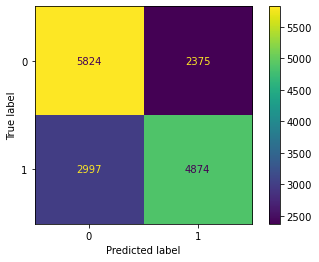

In [200]:
#XGBClassifier default
myModel=XGBClassifier(colsample_bytree=0.5, learning_rate=0.06, max_depth=6, min_child_weight=1, n_estimators=900, random_state=0, subsample=0.9, use_label_encoder=False)
#myModel=XGBClassifier(use_label_encoder=False)
myModel.fit(x_train_std,y_train)
predictResults(myModel, x_test_std, y_test, 0)

In [148]:
#XGBClassifier random Search
parameter_space = {
    'n_estimators': stats.randint(150, 1000),
    'learning_rate': stats.uniform(0.01, 0.59),
    'subsample': stats.uniform(0.3, 0.6),
    'max_depth': [3, 4, 5, 6, 7, 8, 9],
    'colsample_bytree': stats.uniform(0.5, 0.4),
    'min_child_weight': [1, 2, 3, 4],
    'use_label_encoder': [False],
    'random_state': [0]
}                        
randomSearch(XGBClassifier(), parameter_space, x_train_std, y_train, 'recall', 50)

Start:  2021-10-14 01:07:42.009804
[19:11:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Score: 0.6230655234465967
Best Hyperparameters: {'colsample_bytree': 0.5866201417697487, 'learning_rate': 0.0897787223092167, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 700, 'random_state': 0, 'subsample': 0.43339283295095254, 'use_label_encoder': False}
End:  2021-10-14 19:13:18.430807
0.631 0.610 for {'colsample_bytree': 0.7195254015709299, 'learning_rate': 0.4319617261597275, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 857, 'random_state': 0, 'subsample': 0.8083510432704752, 'use_label_encoder': False}
0.613 0.599 for {'colsample_bytree': 0.7494254787143889, 'learning_rate': 0.2367852073026929, 'max_depth': 9, 'min_c

              precision    recall  f1-score   support

         SLA       0.66      0.71      0.69      8199
   Violation       0.68      0.62      0.65      7871

    accuracy                           0.67     16070
   macro avg       0.67      0.67      0.67     16070
weighted avg       0.67      0.67      0.67     16070

Accuracy:  0.6687616677037959
MSE: 0.3312383322962041
RMSE: 0.5755330853184759
R2: -0.3255055305525838
MEA: 0.3312383322962041


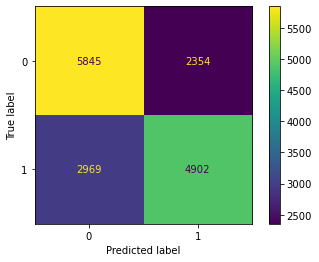

In [198]:
#LGBMClassifier default
myModel=LGBMClassifier(boosting_type='dart', class_weight='balanced', importance_type='gain', learning_rate=0.7, max_depth=49, min_child_samples=50, n_estimators=251, num_leaves=7, random_state=0)
#myModel=LGBMClassifier()
myModel.fit(x_train_std,y_train)
predictResults(myModel, x_test_std, y_test, 0)

In [159]:
#LGBMClassifier random Search
parameter_space = {
    'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
    'num_leaves': list(range(1,51,2)),
    'max_depth': list(range(-1,101,5)),
    'learning_rate': stats.uniform(0.01, 1),
    'n_estimators': stats.randint(100, 1000),
    'class_weight': ['dict', 'balanced', None],
    'min_child_samples': list(range(10,101,10)),
    'random_state': [0],
    'importance_type': ['split','gain']
}                        
randomSearch(LGBMClassifier(), parameter_space, x_train_std, y_train, 'recall', 50)

Start:  2021-10-14 23:08:50.338985
Best Score: 0.6309198687413995
Best Hyperparameters: {'boosting_type': 'gbdt', 'class_weight': 'balanced', 'importance_type': 'split', 'learning_rate': 0.6127633760716439, 'max_depth': 14, 'min_child_samples': 80, 'n_estimators': 109, 'num_leaves': 39, 'random_state': 0}
End:  2021-10-14 23:46:14.307609
0.654 0.631 for {'boosting_type': 'gbdt', 'class_weight': 'balanced', 'importance_type': 'split', 'learning_rate': 0.6127633760716439, 'max_depth': 14, 'min_child_samples': 80, 'n_estimators': 109, 'num_leaves': 39, 'random_state': 0}
nan nan for {'boosting_type': 'dart', 'class_weight': 'None', 'importance_type': 'split', 'learning_rate': 0.3075346065444723, 'max_depth': 59, 'min_child_samples': 20, 'n_estimators': 586, 'num_leaves': 15, 'random_state': 0}
nan nan for {'boosting_type': 'rf', 'class_weight': 'None', 'importance_type': 'split', 'learning_rate': 0.40278479610082973, 'max_depth': 64, 'min_child_samples': 90, 'n_estimators': 877, 'num_leav

Learning rate set to 0.06095
0:	learn: 0.6853167	total: 11.4ms	remaining: 11.4s
1:	learn: 0.6783365	total: 21.6ms	remaining: 10.8s
2:	learn: 0.6723654	total: 30.7ms	remaining: 10.2s
3:	learn: 0.6671697	total: 40.8ms	remaining: 10.2s
4:	learn: 0.6628016	total: 49.5ms	remaining: 9.84s
5:	learn: 0.6589553	total: 58ms	remaining: 9.6s
6:	learn: 0.6552889	total: 66.7ms	remaining: 9.47s
7:	learn: 0.6523420	total: 75.2ms	remaining: 9.33s
8:	learn: 0.6495072	total: 83.7ms	remaining: 9.21s
9:	learn: 0.6473216	total: 92.6ms	remaining: 9.17s
10:	learn: 0.6453210	total: 101ms	remaining: 9.1s
11:	learn: 0.6435976	total: 109ms	remaining: 8.98s
12:	learn: 0.6414969	total: 118ms	remaining: 8.93s
13:	learn: 0.6397607	total: 127ms	remaining: 8.93s
14:	learn: 0.6383183	total: 137ms	remaining: 9s
15:	learn: 0.6370615	total: 149ms	remaining: 9.15s
16:	learn: 0.6360087	total: 159ms	remaining: 9.22s
17:	learn: 0.6350351	total: 168ms	remaining: 9.18s
18:	learn: 0.6342254	total: 179ms	remaining: 9.22s
19:	learn

165:	learn: 0.6047673	total: 1.79s	remaining: 8.99s
166:	learn: 0.6046898	total: 1.8s	remaining: 9s
167:	learn: 0.6046225	total: 1.82s	remaining: 9.01s
168:	learn: 0.6045585	total: 1.83s	remaining: 9.01s
169:	learn: 0.6044665	total: 1.84s	remaining: 9.01s
170:	learn: 0.6043735	total: 1.86s	remaining: 9s
171:	learn: 0.6042792	total: 1.87s	remaining: 9s
172:	learn: 0.6041871	total: 1.88s	remaining: 8.99s
173:	learn: 0.6041226	total: 1.9s	remaining: 9s
174:	learn: 0.6040294	total: 1.91s	remaining: 8.99s
175:	learn: 0.6039946	total: 1.92s	remaining: 8.98s
176:	learn: 0.6039045	total: 1.93s	remaining: 8.98s
177:	learn: 0.6038304	total: 1.94s	remaining: 8.98s
178:	learn: 0.6036742	total: 1.96s	remaining: 8.97s
179:	learn: 0.6035909	total: 1.97s	remaining: 8.97s
180:	learn: 0.6034182	total: 1.98s	remaining: 8.97s
181:	learn: 0.6033648	total: 2s	remaining: 8.99s
182:	learn: 0.6032715	total: 2.01s	remaining: 8.99s
183:	learn: 0.6031953	total: 2.03s	remaining: 9s
184:	learn: 0.6030982	total: 2.0

335:	learn: 0.5924386	total: 4.56s	remaining: 9s
336:	learn: 0.5923464	total: 4.58s	remaining: 9s
337:	learn: 0.5923086	total: 4.59s	remaining: 8.99s
338:	learn: 0.5922520	total: 4.61s	remaining: 8.99s
339:	learn: 0.5922159	total: 4.62s	remaining: 8.98s
340:	learn: 0.5921641	total: 4.64s	remaining: 8.97s
341:	learn: 0.5921144	total: 4.66s	remaining: 8.96s
342:	learn: 0.5920518	total: 4.67s	remaining: 8.95s
343:	learn: 0.5919761	total: 4.69s	remaining: 8.94s
344:	learn: 0.5919319	total: 4.71s	remaining: 8.93s
345:	learn: 0.5918928	total: 4.72s	remaining: 8.93s
346:	learn: 0.5918325	total: 4.74s	remaining: 8.92s
347:	learn: 0.5917758	total: 4.76s	remaining: 8.92s
348:	learn: 0.5917383	total: 4.78s	remaining: 8.91s
349:	learn: 0.5917002	total: 4.79s	remaining: 8.89s
350:	learn: 0.5916304	total: 4.8s	remaining: 8.88s
351:	learn: 0.5915695	total: 4.82s	remaining: 8.87s
352:	learn: 0.5915049	total: 4.83s	remaining: 8.85s
353:	learn: 0.5914511	total: 4.84s	remaining: 8.84s
354:	learn: 0.59138

502:	learn: 0.5836159	total: 7.08s	remaining: 7s
503:	learn: 0.5835625	total: 7.1s	remaining: 6.99s
504:	learn: 0.5835174	total: 7.12s	remaining: 6.98s
505:	learn: 0.5834682	total: 7.14s	remaining: 6.97s
506:	learn: 0.5834354	total: 7.16s	remaining: 6.96s
507:	learn: 0.5833947	total: 7.17s	remaining: 6.95s
508:	learn: 0.5833495	total: 7.19s	remaining: 6.94s
509:	learn: 0.5832799	total: 7.21s	remaining: 6.93s
510:	learn: 0.5832208	total: 7.23s	remaining: 6.92s
511:	learn: 0.5831621	total: 7.24s	remaining: 6.9s
512:	learn: 0.5831122	total: 7.26s	remaining: 6.89s
513:	learn: 0.5830663	total: 7.28s	remaining: 6.88s
514:	learn: 0.5830231	total: 7.29s	remaining: 6.87s
515:	learn: 0.5829757	total: 7.31s	remaining: 6.85s
516:	learn: 0.5829204	total: 7.32s	remaining: 6.84s
517:	learn: 0.5828796	total: 7.34s	remaining: 6.83s
518:	learn: 0.5828305	total: 7.35s	remaining: 6.82s
519:	learn: 0.5827841	total: 7.37s	remaining: 6.8s
520:	learn: 0.5827450	total: 7.38s	remaining: 6.79s
521:	learn: 0.5827

666:	learn: 0.5759391	total: 9.61s	remaining: 4.8s
667:	learn: 0.5758988	total: 9.63s	remaining: 4.79s
668:	learn: 0.5758780	total: 9.64s	remaining: 4.77s
669:	learn: 0.5758303	total: 9.66s	remaining: 4.76s
670:	learn: 0.5757828	total: 9.67s	remaining: 4.74s
671:	learn: 0.5757260	total: 9.69s	remaining: 4.73s
672:	learn: 0.5757062	total: 9.7s	remaining: 4.71s
673:	learn: 0.5756813	total: 9.71s	remaining: 4.7s
674:	learn: 0.5756557	total: 9.73s	remaining: 4.68s
675:	learn: 0.5756206	total: 9.74s	remaining: 4.67s
676:	learn: 0.5755590	total: 9.75s	remaining: 4.65s
677:	learn: 0.5754997	total: 9.76s	remaining: 4.64s
678:	learn: 0.5754548	total: 9.78s	remaining: 4.62s
679:	learn: 0.5754135	total: 9.79s	remaining: 4.61s
680:	learn: 0.5753697	total: 9.81s	remaining: 4.59s
681:	learn: 0.5753276	total: 9.82s	remaining: 4.58s
682:	learn: 0.5752935	total: 9.84s	remaining: 4.57s
683:	learn: 0.5752451	total: 9.85s	remaining: 4.55s
684:	learn: 0.5752039	total: 9.86s	remaining: 4.54s
685:	learn: 0.5

827:	learn: 0.5691093	total: 12.1s	remaining: 2.52s
828:	learn: 0.5690603	total: 12.2s	remaining: 2.51s
829:	learn: 0.5690102	total: 12.2s	remaining: 2.5s
830:	learn: 0.5689900	total: 12.2s	remaining: 2.48s
831:	learn: 0.5689551	total: 12.2s	remaining: 2.47s
832:	learn: 0.5689124	total: 12.2s	remaining: 2.45s
833:	learn: 0.5688530	total: 12.3s	remaining: 2.44s
834:	learn: 0.5688073	total: 12.3s	remaining: 2.42s
835:	learn: 0.5687617	total: 12.3s	remaining: 2.41s
836:	learn: 0.5687367	total: 12.3s	remaining: 2.4s
837:	learn: 0.5686771	total: 12.3s	remaining: 2.38s
838:	learn: 0.5686277	total: 12.3s	remaining: 2.37s
839:	learn: 0.5685922	total: 12.4s	remaining: 2.35s
840:	learn: 0.5685494	total: 12.4s	remaining: 2.34s
841:	learn: 0.5685083	total: 12.4s	remaining: 2.33s
842:	learn: 0.5684829	total: 12.4s	remaining: 2.31s
843:	learn: 0.5684450	total: 12.4s	remaining: 2.3s
844:	learn: 0.5684163	total: 12.4s	remaining: 2.28s
845:	learn: 0.5683622	total: 12.5s	remaining: 2.27s
846:	learn: 0.5

992:	learn: 0.5628097	total: 15.5s	remaining: 109ms
993:	learn: 0.5627731	total: 15.5s	remaining: 93.8ms
994:	learn: 0.5627348	total: 15.6s	remaining: 78.2ms
995:	learn: 0.5626918	total: 15.6s	remaining: 62.5ms
996:	learn: 0.5626584	total: 15.6s	remaining: 46.9ms
997:	learn: 0.5626319	total: 15.6s	remaining: 31.3ms
998:	learn: 0.5626129	total: 15.6s	remaining: 15.6ms
999:	learn: 0.5625789	total: 15.6s	remaining: 0us
              precision    recall  f1-score   support

         SLA       0.66      0.72      0.69      8199
   Violation       0.68      0.62      0.65      7871

    accuracy                           0.67     16070
   macro avg       0.67      0.67      0.67     16070
weighted avg       0.67      0.67      0.67     16070

Accuracy:  0.6695706285003111
MSE: 0.3304293714996889
RMSE: 0.5748298630896701
R2: -0.32226833876276917
MEA: 0.3304293714996889


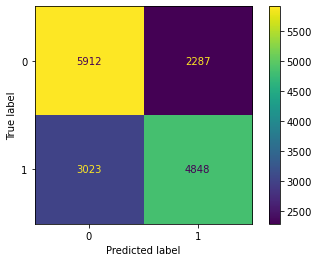

In [199]:
#CatBoostClassifier default is better
#myModel=CatBoostClassifier(bagging_temperature=0.01, depth=1, iterations=950, l2_leaf_reg=3, learning_rate=0.7, random_state=0, random_strength=1, scale_pos_weight=1)
myModel=CatBoostClassifier()
myModel.fit(x_train_std,y_train)
predictResults(myModel, x_test_std, y_test, 0)

In [161]:
#CatBoostClassifier random Search
parameter_space = {
    'iterations': list(range(100,1001,50)),
    'depth': list(range(1,11,1)),
    'learning_rate': stats.uniform(0.01, 1),
    'random_strength': list(range(1,11,1)),
    'bagging_temperature': [None, 0.01, 0.1, 1],
    'l2_leaf_reg': list(range(1,11,1)),
    'scale_pos_weight': stats.uniform(0.01, 1),
    'random_state': [0]
}                        
randomSearch(CatBoostClassifier(), parameter_space, x_train_std, y_train, 'recall', 50)

Start:  2021-10-14 23:46:14.402578
0:	learn: 0.6857388	total: 20.8ms	remaining: 19.7s
1:	learn: 0.6769439	total: 36.1ms	remaining: 17.1s
2:	learn: 0.6716561	total: 48.8ms	remaining: 15.4s
3:	learn: 0.6633299	total: 61.4ms	remaining: 14.5s
4:	learn: 0.6593932	total: 74.4ms	remaining: 14.1s
5:	learn: 0.6565566	total: 85.8ms	remaining: 13.5s
6:	learn: 0.6541307	total: 99.4ms	remaining: 13.4s
7:	learn: 0.6520459	total: 111ms	remaining: 13.1s
8:	learn: 0.6504681	total: 122ms	remaining: 12.8s
9:	learn: 0.6469821	total: 136ms	remaining: 12.8s
10:	learn: 0.6453970	total: 151ms	remaining: 12.9s
11:	learn: 0.6439425	total: 165ms	remaining: 12.9s
12:	learn: 0.6422935	total: 176ms	remaining: 12.7s
13:	learn: 0.6415409	total: 188ms	remaining: 12.6s
14:	learn: 0.6405532	total: 201ms	remaining: 12.5s
15:	learn: 0.6394199	total: 220ms	remaining: 12.8s
16:	learn: 0.6383157	total: 236ms	remaining: 13s
17:	learn: 0.6375220	total: 252ms	remaining: 13s
18:	learn: 0.6368507	total: 266ms	remaining: 13s
19:	l

167:	learn: 0.6210693	total: 2.37s	remaining: 11.1s
168:	learn: 0.6210660	total: 2.39s	remaining: 11s
169:	learn: 0.6210661	total: 2.4s	remaining: 11s
170:	learn: 0.6210657	total: 2.42s	remaining: 11s
171:	learn: 0.6210644	total: 2.43s	remaining: 11s
172:	learn: 0.6210640	total: 2.44s	remaining: 11s
173:	learn: 0.6210599	total: 2.46s	remaining: 11s
174:	learn: 0.6210572	total: 2.47s	remaining: 11s
175:	learn: 0.6210565	total: 2.48s	remaining: 10.9s
176:	learn: 0.6210550	total: 2.5s	remaining: 10.9s
177:	learn: 0.6210525	total: 2.51s	remaining: 10.9s
178:	learn: 0.6210499	total: 2.53s	remaining: 10.9s
179:	learn: 0.6210493	total: 2.54s	remaining: 10.9s
180:	learn: 0.6210473	total: 2.56s	remaining: 10.9s
181:	learn: 0.6210441	total: 2.58s	remaining: 10.9s
182:	learn: 0.6210426	total: 2.59s	remaining: 10.8s
183:	learn: 0.6210388	total: 2.6s	remaining: 10.8s
184:	learn: 0.6210389	total: 2.61s	remaining: 10.8s
185:	learn: 0.6210384	total: 2.63s	remaining: 10.8s
186:	learn: 0.6210380	total: 

331:	learn: 0.6209496	total: 4.71s	remaining: 8.76s
332:	learn: 0.6209496	total: 4.72s	remaining: 8.74s
333:	learn: 0.6209494	total: 4.73s	remaining: 8.72s
334:	learn: 0.6209495	total: 4.74s	remaining: 8.7s
335:	learn: 0.6209485	total: 4.75s	remaining: 8.69s
336:	learn: 0.6209485	total: 4.77s	remaining: 8.67s
337:	learn: 0.6209484	total: 4.78s	remaining: 8.66s
338:	learn: 0.6209468	total: 4.79s	remaining: 8.64s
339:	learn: 0.6209464	total: 4.81s	remaining: 8.62s
340:	learn: 0.6209459	total: 4.82s	remaining: 8.61s
341:	learn: 0.6209454	total: 4.84s	remaining: 8.6s
342:	learn: 0.6209454	total: 4.85s	remaining: 8.58s
343:	learn: 0.6209454	total: 4.86s	remaining: 8.56s
344:	learn: 0.6209453	total: 4.87s	remaining: 8.54s
345:	learn: 0.6209454	total: 4.88s	remaining: 8.52s
346:	learn: 0.6209450	total: 4.89s	remaining: 8.51s
347:	learn: 0.6209450	total: 4.91s	remaining: 8.5s
348:	learn: 0.6209451	total: 4.93s	remaining: 8.49s
349:	learn: 0.6209451	total: 4.95s	remaining: 8.48s
350:	learn: 0.6

493:	learn: 0.6209205	total: 6.84s	remaining: 6.32s
494:	learn: 0.6209205	total: 6.86s	remaining: 6.3s
495:	learn: 0.6209205	total: 6.87s	remaining: 6.29s
496:	learn: 0.6209204	total: 6.89s	remaining: 6.28s
497:	learn: 0.6209204	total: 6.9s	remaining: 6.26s
498:	learn: 0.6209204	total: 6.91s	remaining: 6.25s
499:	learn: 0.6209204	total: 6.92s	remaining: 6.23s
500:	learn: 0.6209204	total: 6.94s	remaining: 6.22s
501:	learn: 0.6209205	total: 6.95s	remaining: 6.2s
502:	learn: 0.6209203	total: 6.96s	remaining: 6.19s
503:	learn: 0.6209203	total: 6.98s	remaining: 6.17s
504:	learn: 0.6209203	total: 6.99s	remaining: 6.16s
505:	learn: 0.6209202	total: 7s	remaining: 6.15s
506:	learn: 0.6209202	total: 7.02s	remaining: 6.13s
507:	learn: 0.6209202	total: 7.03s	remaining: 6.12s
508:	learn: 0.6209201	total: 7.05s	remaining: 6.11s
509:	learn: 0.6209198	total: 7.06s	remaining: 6.09s
510:	learn: 0.6209199	total: 7.07s	remaining: 6.08s
511:	learn: 0.6209199	total: 7.09s	remaining: 6.07s
512:	learn: 0.6209

662:	learn: 0.6209100	total: 8.97s	remaining: 3.88s
663:	learn: 0.6209095	total: 8.98s	remaining: 3.87s
664:	learn: 0.6209097	total: 8.99s	remaining: 3.85s
665:	learn: 0.6209096	total: 9s	remaining: 3.84s
666:	learn: 0.6209095	total: 9.01s	remaining: 3.82s
667:	learn: 0.6209093	total: 9.03s	remaining: 3.81s
668:	learn: 0.6209093	total: 9.04s	remaining: 3.8s
669:	learn: 0.6209088	total: 9.06s	remaining: 3.79s
670:	learn: 0.6209089	total: 9.07s	remaining: 3.77s
671:	learn: 0.6209089	total: 9.09s	remaining: 3.76s
672:	learn: 0.6209090	total: 9.1s	remaining: 3.75s
673:	learn: 0.6209088	total: 9.12s	remaining: 3.73s
674:	learn: 0.6209088	total: 9.13s	remaining: 3.72s
675:	learn: 0.6209088	total: 9.14s	remaining: 3.7s
676:	learn: 0.6209088	total: 9.15s	remaining: 3.69s
677:	learn: 0.6209088	total: 9.16s	remaining: 3.68s
678:	learn: 0.6209089	total: 9.18s	remaining: 3.66s
679:	learn: 0.6209088	total: 9.19s	remaining: 3.65s
680:	learn: 0.6209088	total: 9.2s	remaining: 3.63s
681:	learn: 0.62090

832:	learn: 0.6209015	total: 11.1s	remaining: 1.56s
833:	learn: 0.6209015	total: 11.1s	remaining: 1.54s
834:	learn: 0.6209015	total: 11.1s	remaining: 1.53s
835:	learn: 0.6209013	total: 11.1s	remaining: 1.52s
836:	learn: 0.6209013	total: 11.1s	remaining: 1.5s
837:	learn: 0.6209013	total: 11.2s	remaining: 1.49s
838:	learn: 0.6209014	total: 11.2s	remaining: 1.48s
839:	learn: 0.6209013	total: 11.2s	remaining: 1.46s
840:	learn: 0.6209013	total: 11.2s	remaining: 1.45s
841:	learn: 0.6209013	total: 11.2s	remaining: 1.44s
842:	learn: 0.6209013	total: 11.2s	remaining: 1.42s
843:	learn: 0.6209013	total: 11.2s	remaining: 1.41s
844:	learn: 0.6209014	total: 11.2s	remaining: 1.39s
845:	learn: 0.6209011	total: 11.2s	remaining: 1.38s
846:	learn: 0.6209010	total: 11.2s	remaining: 1.37s
847:	learn: 0.6209009	total: 11.3s	remaining: 1.35s
848:	learn: 0.6209009	total: 11.3s	remaining: 1.34s
849:	learn: 0.6209009	total: 11.3s	remaining: 1.33s
850:	learn: 0.6209009	total: 11.3s	remaining: 1.31s
851:	learn: 0

              precision    recall  f1-score   support

         SLA       0.66      0.72      0.69      8199
   Violation       0.68      0.61      0.64      7871

    accuracy                           0.67     16070
   macro avg       0.67      0.67      0.66     16070
weighted avg       0.67      0.67      0.67     16070

Accuracy:  0.6662103298070939
MSE: 0.33378967019290606
RMSE: 0.5777453333371946
R2: -0.33571513542815334
MEA: 0.33378967019290606


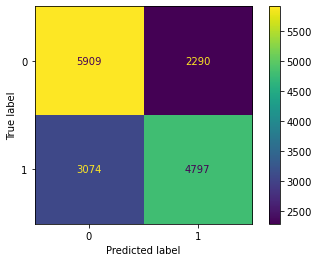

In [195]:
#HistGradientBoostingClassifier default
#myModel=HistGradientBoostingClassifier(l2_regularization=0.9, learning_rate=0.7, max_depth=None, max_iter=950, max_leaf_nodes=11, min_samples_leaf=40, n_iter_no_change=90, random_state= 0, validation_fraction=0.06, warm_start=True)
myModel=HistGradientBoostingClassifier()
myModel.fit(x_train_std,y_train)
predictResults(myModel, x_test_std, y_test, 0)


In [177]:
#HistGradientBoostingClassifier random Search
parameter_space = {
    'learning_rate': stats.uniform(0.01, 1),
    'max_iter': list(range(100,1001,50)),
    'max_leaf_nodes': list(range(11,52,5)),
    'max_depth': [[int(x) for x in np.linspace(10, 110, num = 11)], None],
    'min_samples_leaf': list(range(10,101,10)),
    'l2_regularization': stats.uniform(0, 1),
    'warm_start':[True, False],
    'validation_fraction': stats.uniform(0.01, 1),
    'n_iter_no_change': list(range(10,101,10)),
    'random_state': [0]
}                        
randomSearch(HistGradientBoostingClassifier(), parameter_space, x_train_std, y_train, 'recall', 50)

Start:  2021-10-15 09:49:42.676086


T:\Umit\tools\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Score: 0.6175082036625383
Best Hyperparameters: {'l2_regularization': 0.9280812934655909, 'learning_rate': 0.7144144019235328, 'max_depth': None, 'max_iter': 950, 'max_leaf_nodes': 11, 'min_samples_leaf': 40, 'n_iter_no_change': 90, 'random_state': 0, 'validation_fraction': 0.060370056757543804, 'warm_start': True}
End:  2021-10-15 10:09:23.125533
0.644 0.613 for {'l2_regularization': 0.5488135039273248, 'learning_rate': 0.7251893663724195, 'max_depth': None, 'max_iter': 250, 'max_leaf_nodes': 46, 'min_samples_leaf': 100, 'n_iter_no_change': 40, 'random_state': 0, 'validation_fraction': 0.6558941130666561, 'warm_start': True}
nan nan for {'l2_regularization': 0.2975346065444723, 'learning_rate': 0.06671297731744318, 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 'max_iter': 150, 'max_leaf_nodes': 41, 'min_samples_leaf': 80, 'n_iter_no_change': 80, 'random_state': 0, 'validation_fraction': 0.48997717237505733, 'warm_start': False}
0.602 0.555 for {'l2_regularization':

In [205]:
#######################################
# CODE ARCHIVE #
#######################################

In [215]:
#######################################

In [ ]:
# Hyperparameter Optimization With Grid Search for RFC
# define model
print("Start: ", datetime.now())
model = RandomForestClassifier()
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search space
space = dict()
space['criterion'] = ['gini']#['entropy', 'gini']
space['random_state'] =  [0]
space['n_estimators'] = range(100, 1001, 100)
# Number of features to consider at every split
space['max_features'] = ['auto'] #['auto', 'log2', None] 
# Maximum number of levels in tree
max_depth = [20]#[int(x) for x in np.linspace(10, 110, num = 11)]
#max_depth.append(None)
#space['max_depth'] = max_depth 
# Minimum number of samples required to split a node
space['min_samples_split'] = [5] #[2, 5, 10] 
# Minimum number of samples required at each leaf node
space['min_samples_leaf'] = [4] #[1, 2, 4] 
# Method of selecting samples for training each tree
space['bootstrap'] = [False]#[True, False]

acc = make_scorer(accuracy_score)
recall = make_scorer(recall_score)
scoring = { "recall": recall, "accuracy": acc }

# define search
search = GridSearchCV(model, space, scoring=scoring, n_jobs=-1, cv=cv, refit='recall')
# execute search
result = search.fit(x_train_std, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

print("End: ", datetime.now())

# All results
means = result.cv_results_['mean_test_accuracy']
stds = result.cv_results_['mean_test_recall']
for mean, std, params in zip(means, stds, result.cv_results_['params']):
    print("%0.3f %0.3f for %r" % (mean, std, params))

#Start:  2021-09-05 10:06:16.124889
#Best Score: 0.6108711760347201
#Best Hyperparameters: {'criterion': 'gini', 'n_estimators': 300, 'random_state': 0}
#End:  2021-09-05 12:01:55.280618

#Start:  2021-09-06 15:08:04.574690
#Best Score: 0.5777389647507145
#Best Hyperparameters: {'bootstrap': False, 'criterion': 'entropy', 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 800, 'random_state': 0}
#End:  2021-09-06 16:27:37.171270

#Start:  2021-09-09 20:47:12.830801
#Best Score: 0.6159733248650364
#Best Hyperparameters: {'bootstrap': True, 'criterion': 'entropy', 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 600, 'random_state': 0}
#End:  2021-09-09 22:26:01.841850

#Start:  2021-09-09 23:22:42.411583
#Best Score: 0.6159733248650364
#Best Hyperparameters: {'bootstrap': True, 'criterion': 'entropy', 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 600, 'random_state': 0}
#End:  2021-09-10 01:00:31.723010


In [ ]:
# Hyperparameter Optimization With Random Search for RFC
# define model
print("Start: ", datetime.now())
model = RandomForestClassifier()
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search space
space = dict()
space['criterion'] = ['entropy', 'gini']
space['random_state'] =  [0]
#space['n_estimators'] = [300]
# Number of features to consider at every split
space['max_features'] = ['auto', 'log2', None] 
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
space['max_depth'] = max_depth 
# Minimum number of samples required to split a node
space['min_samples_split'] = [2, 5, 10] 
# Minimum number of samples required at each leaf node
space['min_samples_leaf'] = [1, 2, 4] 
# Method of selecting samples for training each tree
space['bootstrap'] = [True, False]
acc = make_scorer(accuracy_score)
recall = make_scorer(recall_score)
scoring = { "recall": recall, "accuracy": acc }

search = RandomizedSearchCV(model, space, n_iter=50, scoring=scoring, n_jobs=-1, cv=cv, random_state=1, refit='recall')
# execute search
result = search.fit(x_train_std, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

print("End: ", datetime.now())

# All results
means = result.cv_results_['mean_test_accuracy']
stds = result.cv_results_['mean_test_recall']
for mean, std, params in zip(means, stds, result.cv_results_['params']):
    print("%0.3f %0.3f for %r" % (mean, std, params))
    

#Start:  2021-09-05 12:38:21.969319
#Best Score: 0.6171059595638827
#Best Hyperparameters: {'random_state': 0, 'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 10, 'criterion': 'entropy', 'bootstrap': False}
#End:  2021-09-05 18:30:13.793527

#Start:  2021-09-06 07:46:52.683063
#Best Score: 0.6193923997036096
#Best Hyperparameters: {'random_state': 0, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 10, 'criterion': 'entropy', 'bootstrap': False}
#End:  2021-09-06 09:39:47.720969

#Start:  2021-09-08 20:43:28.530501
#Best Score: 0.6224727426696306
#Best Hyperparameters: {'random_state': 0, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 20, 'criterion': 'entropy', 'bootstrap': False}
#0.659 1.229 for {'random_state': 0, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 60, 'criterion': 'entropy', 'bootstrap': True}
#0.659 1.231 for {'random_state': 0, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 30, 'criterion': 'entropy', 'bootstrap': True}
#End:  2021-09-09 01:29:18.431642

In [242]:
#######################################################
# Classification with RandomForestClassifier algorithm
#######################################################
# create  RandomForestClassifier object
#myModel = RandomForestClassifier(random_state=0, n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features='auto', max_depth= 10, criterion= 'entropy', bootstrap= False)
#BEST1
myModel = RandomForestClassifier(random_state=0, n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features='auto', max_depth= 10, criterion= 'entropy', bootstrap= False)
#myModel = RandomForestClassifier(random_state=0, n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features='auto', max_depth= 10, criterion= 'gini', bootstrap= False)
#myModel = RandomForestClassifier(random_state=0, min_samples_split=5, min_samples_leaf=2, max_features='auto', max_depth=20, criterion='entropy', bootstrap=False)
#myModel = RandomForestClassifier(random_state=0, min_samples_split=5, min_samples_leaf=4, max_features='auto', max_depth=60, criterion= 'entropy', bootstrap=True)
#myModel = RandomForestClassifier(random_state=0, min_samples_split=2, min_samples_leaf=4, max_features='auto', max_depth=30, criterion= 'entropy', bootstrap=True)
#BEST2
#myModel = RandomForestClassifier(random_state=0, n_estimators=800, min_samples_split=2, min_samples_leaf=4, max_features='auto', max_depth=30, criterion= 'entropy', bootstrap=True)
#myModel = RandomForestClassifier(random_state=0, n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_features='auto', max_depth=20, criterion= 'gini', bootstrap=False)

In [243]:
# fit the model with x and y data
myModel.fit(x_train_std, y_train)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=10,
                       min_samples_split=5, n_estimators=800, random_state=0)

<AxesSubplot:>

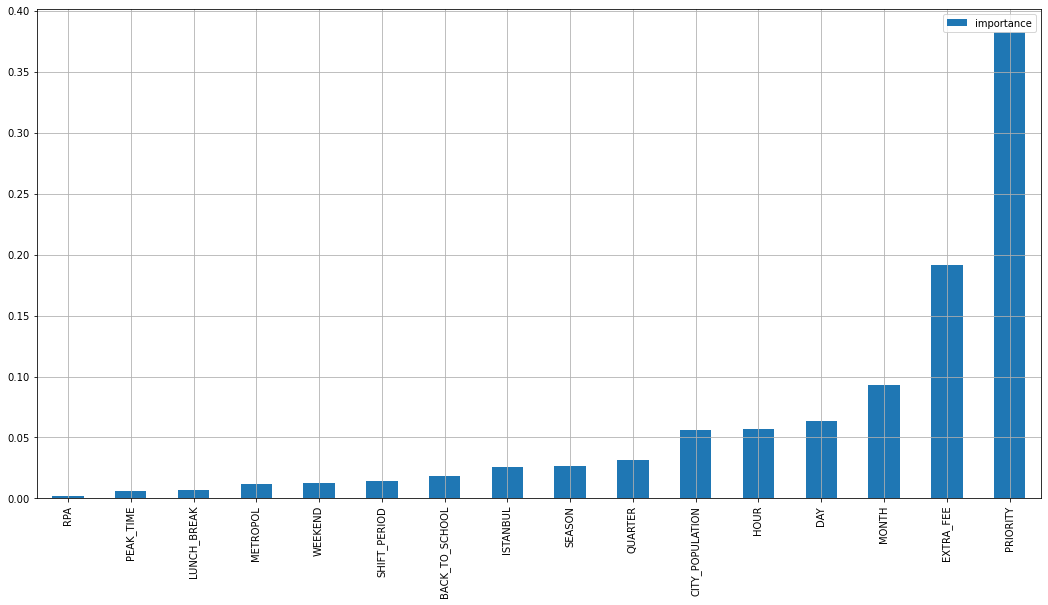

In [244]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(features.columns, myModel.feature_importances_):
    feats[feature] = importance #add the name/value pair 

print(feats)
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'importance'})
importances.sort_values(by='importance').plot(kind='bar', grid=True, figsize=(18,9))

In [245]:
# Predict the values by using all test data
y_predict= myModel.predict(x_test_std)

In [246]:
y_predict_rfc = y_predict

In [247]:
# myModel.score(x_test_std, y_test)
accuracy_score(y_test, y_predict)

0.6481642812694461

In [248]:
# Print the predicted and the actual value of the data in test set
#for i in range(len(y_test)):
 #   print("Predicted: ",y_predict[i]," Actual:", y_test[i])

In [249]:
# false predictions in red colors
# lineX=y_test
# lineY=y_predict
# plt.scatter(lineX, lineY, marker='x', c=lineX+lineY)
# plt.xlabel("Real Values")
# plt.ylabel("Predictions")

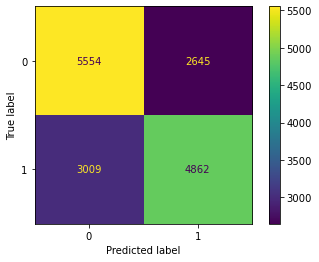

In [250]:
plot_confusion_matrix(myModel,x_test_std,y_test)

In [251]:
# performance
target_names = ['SLA', 'Violation']
print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

         SLA       0.65      0.68      0.66      8199
   Violation       0.65      0.62      0.63      7871

    accuracy                           0.65     16070
   macro avg       0.65      0.65      0.65     16070
weighted avg       0.65      0.65      0.65     16070



In [252]:
# Export as dot file
#export_graphviz(rfClassifier.estimators_[0] , 
#                out_file='slatree.dot', 
#                feature_names = ('DAY_TUESDAY', 'DAY_MONDAY', 'DAY_WEDNESDAY', 'DAY_THURSDAY',
#                                   'DAY_FRIDAY', 'DAY_SATURDAY', 'DAY_SUNDAY', 'PRIORITY', 'SEASON_FALL',
#                                   'SEASON_WINTER', 'SEASON_SUMMER', 'SEASON_SPRING', 'BACKTOSCHOOL',
#                                   'EXTRA_FEE', 'SHIFT_PERIOD_1', 'SHIFT_PERIOD_2', 'SHIFT_PERIOD_3',
#                                   'SHIFT_PERIOD_4'),
#                class_names = ('DURATION_CATEGORY'), 
#                rounded = True, proportion = False, 
#                precision = 2, filled = True)

In [253]:
#dot to png
#graphs = pydot.graph_from_dot_file('slatree.dot')
#graphs[0].write_png('slatree.png')

In [254]:
# Display
#Image(filename = 'slatree.png')

In [255]:
# Calculate mean squared error of predicted values
mse=mean_squared_error(y_test,y_predict)
rmse = np.sqrt(mse)
print("MSE:", mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, y_predict)
print("R2:", r2)
# Calculate absolute squared error of predicted values
mea=mean_absolute_error(y_test,y_predict)
print("MEA:", mea)

MSE: 0.3518357187305538
RMSE: 0.5931574147985961
R2: -0.4079294138163272
MEA: 0.3518357187305538


In [256]:
#######################################################
# Classification with MLPClassifier algorithm
#######################################################
#myModel = MLPClassifier(solver= 'adam', random_state= 0, max_iter= 300, learning_rate='constant', hidden_layer_sizes=(100,), alpha=0.0001, activation='relu')
#BEST1
myModel = MLPClassifier(solver= 'sgd', random_state= 0, max_iter= 500, learning_rate='constant', hidden_layer_sizes=(100,), alpha=0.01, activation='tanh')
#myModel = MLPClassifier(solver= 'sgd', random_state= 0, max_iter= 225, learning_rate='constant', hidden_layer_sizes=(100,), alpha=0.01, activation='tanh')
#myModel = MLPClassifier(solver= 'lbfgs', random_state= 0, max_iter= 300, learning_rate='adaptive', hidden_layer_sizes=(50, 100, 50), alpha=0.05, activation='logistic')
#myModel = MLPClassifier(solver='adam', random_state=0, learning_rate='adaptive', hidden_layer_sizes=(50, 50, 50), alpha= 0.05, activation='relu')
#myModel = MLPClassifier(solver='sgd', random_state=0, learning_rate='adaptive', hidden_layer_sizes=(50, 50, 50), alpha=0.05, activation='tanh')
#BEST2
#myModel = MLPClassifier(solver='sgd', random_state=0, max_iter= 600, learning_rate='adaptive', hidden_layer_sizes=(50, 50, 50), alpha=0.05, activation='tanh')

In [257]:
# fit the MLP with x and y data
myModel.fit(x_train, y_train)

MLPClassifier(activation='tanh', alpha=0.01, max_iter=500, random_state=0,
              solver='sgd')

In [258]:
# Predict the values by using all test data
y_predict= myModel.predict(x_test)

In [259]:
y_predict_mlp = y_predict

In [260]:
accuracy_score(y_test, y_predict)

#0.6693217174859988

0.6392657125077784

In [261]:
# Print the predicted and the actual value of the data in test set
# for i in range(len(y_test)):
    # print("Predicted: ",y_predict[i]," Actual:", y_test[i])

In [262]:
# false predictions 
# lineX=y_test
# lineY=y_predict
# plt.scatter(lineX, lineY, marker='x', c=lineX+lineY)
# plt.xlabel("Real Values")
# plt.ylabel("Predictions")

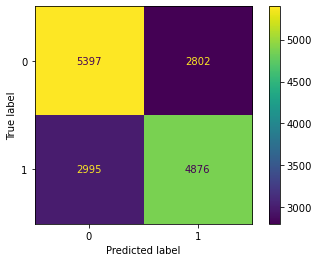

In [263]:
plot_confusion_matrix(myModel,x_test,y_test)

In [264]:
# performances
target_names = ['SLA', 'Violation']
print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

         SLA       0.64      0.66      0.65      8199
   Violation       0.64      0.62      0.63      7871

    accuracy                           0.64     16070
   macro avg       0.64      0.64      0.64     16070
weighted avg       0.64      0.64      0.64     16070



In [265]:
# Calculate mean squared error of predicted values
mse=mean_squared_error(y_test,y_predict)
rmse = np.sqrt(mse)
print("MSE:", mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, y_predict)
print("R2:", r2)
# Calculate absolute squared error of predicted values
mea=mean_absolute_error(y_test,y_predict)
print("MEA:", mea)

MSE: 0.36073428749222153
RMSE: 0.6006115945369532
R2: -0.4435385235042888
MEA: 0.36073428749222153


In [266]:
#############################
# Merge MLP and RFC predicts
#############################
#y_predict =  np.logical_and(y_predict_mlp, y_predict_rfc)
y_predict =  np.logical_or(y_predict_mlp, y_predict_rfc)

In [267]:
#MLP and RFC similarity with XOR
y_predict_xor =  np.logical_xor(y_predict_mlp, y_predict_rfc)
unique, counts = np.unique(y_predict_xor, return_counts=True)
dict(zip(unique, counts))

{False: 14703, True: 1367}

In [268]:
# performances
target_names = ['SLA', 'Violation']
print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

         SLA       0.66      0.62      0.64      8199
   Violation       0.63      0.66      0.64      7871

    accuracy                           0.64     16070
   macro avg       0.64      0.64      0.64     16070
weighted avg       0.64      0.64      0.64     16070



In [306]:
#######################################################
# Classification with Perceptron algorithm
#######################################################
# no important change when change eta0 or max_iter
# very low performance score 0.2908853030963803 without scaling
myModel=Perceptron(eta0=0.1, max_iter=10000, random_state=0)

In [307]:
myModel.fit(x_train_std,y_train)

Perceptron(eta0=0.1, max_iter=10000)

In [308]:
# Predict the values by using all test data
y_predict= myModel.predict(x_test_std)

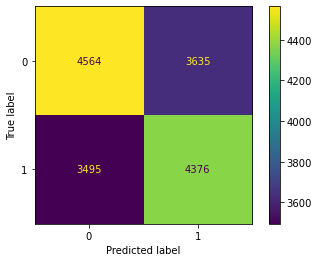

In [310]:
plot_confusion_matrix(myModel,x_test_std,y_test)

In [311]:
# performances
target_names = ['SLA', 'Violation']
print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

         SLA       0.57      0.56      0.56      8199
   Violation       0.55      0.56      0.55      7871

    accuracy                           0.56     16070
   macro avg       0.56      0.56      0.56     16070
weighted avg       0.56      0.56      0.56     16070



In [312]:
accuracy_score(y_test, y_predict)

0.5563161169881767

In [314]:
# Calculate mean squared error of predicted values
mse=mean_squared_error(y_test,y_predict)
rmse = np.sqrt(mse)
print("MSE:", mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, y_predict)
print("R2:", r2)
# Calculate absolute squared error of predicted values
mea=mean_absolute_error(y_test,y_predict)
print("MEA:", mea)

MSE: 0.44368388301182327
RMSE: 0.6660960013480214
R2: -0.7754751893368257
MEA: 0.44368388301182327


In [ ]:
##################################################
# Classification with LogisticRegression algorithm
##################################################
myModel = LogisticRegression(penalty = 'l2', C = 1, random_state = 0)

In [307]:
myModel.fit(x_train_std,y_train)

Perceptron(eta0=0.1, max_iter=10000)

In [308]:
# Predict the values by using all test data
y_predict= myModel.predict(x_test_std)

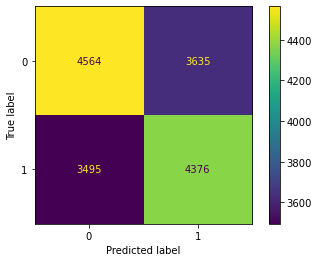

In [310]:
plot_confusion_matrix(myModel,x_test_std,y_test)

In [311]:
# performances
target_names = ['SLA', 'Violation']
print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

         SLA       0.57      0.56      0.56      8199
   Violation       0.55      0.56      0.55      7871

    accuracy                           0.56     16070
   macro avg       0.56      0.56      0.56     16070
weighted avg       0.56      0.56      0.56     16070



In [312]:
accuracy_score(y_test, y_predict)

0.5563161169881767

In [314]:
# Calculate mean squared error of predicted values
mse=mean_squared_error(y_test,y_predict)
rmse = np.sqrt(mse)
print("MSE:", mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, y_predict)
print("R2:", r2)
# Calculate absolute squared error of predicted values
mea=mean_absolute_error(y_test,y_predict)
print("MEA:", mea)

MSE: 0.44368388301182327
RMSE: 0.6660960013480214
R2: -0.7754751893368257
MEA: 0.44368388301182327


In [375]:
##################################################
# Classification with KNeighborsClassifier algorithm
##################################################
myModel = KNeighborsClassifier(n_neighbors = 13)

In [376]:
myModel.fit(x_train_std,y_train)

KNeighborsClassifier(n_neighbors=13)

In [377]:
# Predict the values by using all test data
y_predict= myModel.predict(x_test_std)

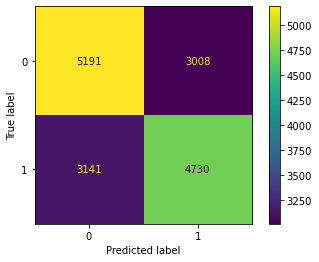

In [378]:
plot_confusion_matrix(myModel,x_test_std,y_test)

In [379]:
# performances
target_names = ['SLA', 'Violation']
print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

         SLA       0.62      0.63      0.63      8199
   Violation       0.61      0.60      0.61      7871

    accuracy                           0.62     16070
   macro avg       0.62      0.62      0.62     16070
weighted avg       0.62      0.62      0.62     16070



In [380]:
accuracy_score(y_test, y_predict)

0.6173615432482887

In [381]:
# Calculate mean squared error of predicted values
mse=mean_squared_error(y_test,y_predict)
rmse = np.sqrt(mse)
print("MSE:", mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, y_predict)
print("R2:", r2)
# Calculate absolute squared error of predicted values
mea=mean_absolute_error(y_test,y_predict)
print("MEA:", mea)

MSE: 0.38263845675171126
RMSE: 0.6185777693642985
R2: -0.5311917165823481
MEA: 0.38263845675171126


In [328]:
#######################################################
# Classification with SVC algorithm
#######################################################
# training not complated without scaling
myModel=SVC(kernel='linear', C=0.01, random_state=0) # linear, poly, rbf (gaussian), sigmoid, tried

In [329]:
# fit the SVC with x and y data
myModel.fit(x_train_std, y_train)

SVC(C=0.01, kernel='linear', random_state=0)

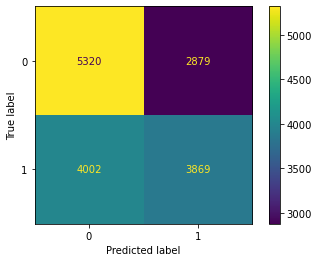

In [330]:
# Predict the values by using all test data
y_predict= myModel.predict(x_test_std)
plot_confusion_matrix(myModel,x_test_std,y_test)

In [331]:
# performances
target_names = ['SLA', 'Violation']
print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

         SLA       0.57      0.65      0.61      8199
   Violation       0.57      0.49      0.53      7871

    accuracy                           0.57     16070
   macro avg       0.57      0.57      0.57     16070
weighted avg       0.57      0.57      0.57     16070



In [332]:
# Calculate the score of the model in test data
accuracy_score(y_test, y_predict)

0.5718108276291226

In [333]:
# Calculate mean squared error of predicted values
mse=mean_squared_error(y_test,y_predict)
rmse = np.sqrt(mse)
print("MSE:", mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, y_predict)
print("R2:", r2)
# Calculate absolute squared error of predicted values
mea=mean_absolute_error(y_test,y_predict)
print("MEA:", mea)

MSE: 0.4281891723708774
RMSE: 0.654361652582788
R2: -0.7134705158242214
MEA: 0.4281891723708774


In [334]:
#######################################################
# Classification with GaussianNB algorithm
#######################################################
myModel = GaussianNB()

In [335]:
myModel.fit(x_train_std,y_train)

GaussianNB()

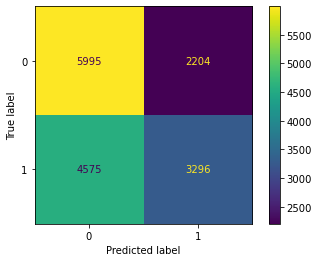

In [336]:
# Predict the values by using all test data
y_predict= myModel.predict(x_test_std)
plot_confusion_matrix(myModel,x_test_std,y_test)

In [337]:
# performances
target_names = ['SLA', 'Violation']
print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

         SLA       0.57      0.73      0.64      8199
   Violation       0.60      0.42      0.49      7871

    accuracy                           0.58     16070
   macro avg       0.58      0.57      0.57     16070
weighted avg       0.58      0.58      0.57     16070



In [338]:
# Calculate the score of the model in test data
accuracy_score(y_test, y_predict)

0.5781580584940884

In [339]:
# Calculate mean squared error of predicted values
mse=mean_squared_error(y_test,y_predict)
rmse = np.sqrt(mse)
print("MSE:", mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, y_predict)
print("R2:", r2)
# Calculate absolute squared error of predicted values
mea=mean_absolute_error(y_test,y_predict)
print("MEA:", mea)

MSE: 0.42184194150591164
RMSE: 0.6494936038991543
R2: -0.6880710110118291
MEA: 0.42184194150591164


In [270]:
###############################
#META-ESTIMATORS
###############################

In [271]:
###############################
# BaggingClassifier with RFC
###############################
myModel = BaggingClassifier(base_estimator=RandomForestClassifier(random_state=0, n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features='auto', max_depth= 10, criterion= 'entropy', bootstrap= False),
                        n_estimators=10, random_state=0)

In [272]:
# fit the model with x and y data
myModel.fit(x_train_std, y_train)

BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=False,
                                                        criterion='entropy',
                                                        max_depth=10,
                                                        min_samples_split=5,
                                                        n_estimators=800,
                                                        random_state=0),
                  random_state=0)

In [273]:
# Predict the values by using all test data
y_predict= myModel.predict(x_test_std)

In [274]:
accuracy_score(y_test, y_predict)

0.6484131922837586

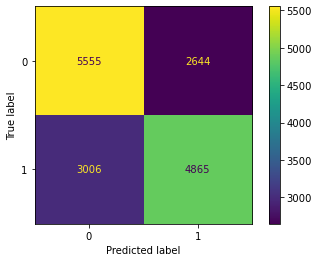

In [275]:
plot_confusion_matrix(myModel, x_test_std, y_test)

In [276]:
# performances
target_names = ['SLA', 'Violation']
print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

         SLA       0.65      0.68      0.66      8199
   Violation       0.65      0.62      0.63      7871

    accuracy                           0.65     16070
   macro avg       0.65      0.65      0.65     16070
weighted avg       0.65      0.65      0.65     16070



In [277]:
# Calculate mean squared error of predicted values
mse=mean_squared_error(y_test,y_predict)
rmse = np.sqrt(mse)
print("MSE:", mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, y_predict)
print("R2:", r2)
# Calculate absolute squared error of predicted values
mea=mean_absolute_error(y_test,y_predict)
print("MEA:", mea)

MSE: 0.35158680771624146
RMSE: 0.5929475589934083
R2: -0.40693335480407655
MEA: 0.35158680771624146


In [278]:
###############################
# BaggingClassifier with MLP
###############################
myModel = BaggingClassifier(base_estimator=MLPClassifier(solver='sgd', random_state=0, max_iter= 2000, learning_rate='adaptive', hidden_layer_sizes=(50, 50, 50), alpha=0.05, activation='tanh'),
                        n_estimators=10, random_state=0)

In [279]:
# fit the model with x and y data
myModel.fit(x_train, y_train)

BaggingClassifier(base_estimator=MLPClassifier(activation='tanh', alpha=0.05,
                                               hidden_layer_sizes=(50, 50, 50),
                                               learning_rate='adaptive',
                                               max_iter=2000, random_state=0,
                                               solver='sgd'),
                  random_state=0)

In [280]:
# Predict the values by using all test data
y_predict= myModel.predict(x_test)

In [281]:
accuracy_score(y_test, y_predict)

0.6430616054760423

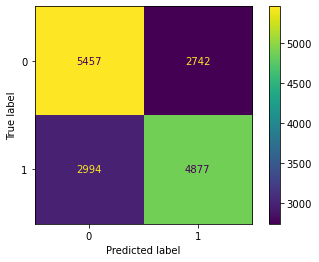

In [282]:
plot_confusion_matrix(myModel, x_test, y_test)

In [283]:
# performances
target_names = ['SLA', 'Violation']
print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

         SLA       0.65      0.67      0.66      8199
   Violation       0.64      0.62      0.63      7871

    accuracy                           0.64     16070
   macro avg       0.64      0.64      0.64     16070
weighted avg       0.64      0.64      0.64     16070



In [284]:
# Calculate mean squared error of predicted values
mse=mean_squared_error(y_test,y_predict)
rmse = np.sqrt(mse)
print("MSE:", mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, y_predict)
print("R2:", r2)
# Calculate absolute squared error of predicted values
mea=mean_absolute_error(y_test,y_predict)
print("MEA:", mea)

MSE: 0.3569383945239577
RMSE: 0.5974432144764535
R2: -0.42834862356746606
MEA: 0.3569383945239577


In [285]:
###############################
# AdaBoostClassifier with RFC
###############################
myModel = AdaBoostClassifier(base_estimator=RandomForestClassifier(random_state=0, n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features='auto', max_depth= 10, criterion= 'entropy', bootstrap= False),
    n_estimators=100, random_state=0)

In [286]:
# fit the model with x and y data
myModel.fit(x_train_std, y_train)

AdaBoostClassifier(base_estimator=RandomForestClassifier(bootstrap=False,
                                                         criterion='entropy',
                                                         max_depth=10,
                                                         min_samples_split=5,
                                                         n_estimators=800,
                                                         random_state=0),
                   n_estimators=100, random_state=0)

In [287]:
# Predict the values by using all test data
y_predict= myModel.predict(x_test_std)

In [288]:
accuracy_score(y_test, y_predict)

0.6041692594897324

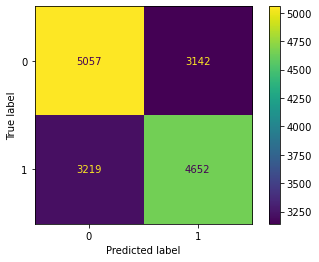

In [289]:
plot_confusion_matrix(myModel, x_test_std, y_test)

In [290]:
# performances
target_names = ['SLA', 'Violation']
print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

         SLA       0.61      0.62      0.61      8199
   Violation       0.60      0.59      0.59      7871

    accuracy                           0.60     16070
   macro avg       0.60      0.60      0.60     16070
weighted avg       0.60      0.60      0.60     16070



In [291]:
# Calculate mean squared error of predicted values
mse=mean_squared_error(y_test,y_predict)
rmse = np.sqrt(mse)
print("MSE:", mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, y_predict)
print("R2:", r2)
# Calculate absolute squared error of predicted values
mea=mean_absolute_error(y_test,y_predict)
print("MEA:", mea)

MSE: 0.39583074051026756
RMSE: 0.6291508090356934
R2: -0.5839828442316337
MEA: 0.39583074051026756


In [292]:
###############################
# AdaBoostClassifier with LR
###############################
myModel = AdaBoostClassifier(LogisticRegression(penalty = 'l2', C = 0.001, random_state = 0),
    n_estimators=100, random_state=0)

In [293]:
# fit the model with x and y data
myModel.fit(x_train_std, y_train)

AdaBoostClassifier(base_estimator=LogisticRegression(C=0.001, random_state=0),
                   n_estimators=100, random_state=0)

In [294]:
# Predict the values by using all test data
y_predict= myModel.predict(x_test_std)

In [295]:
accuracy_score(y_test, y_predict)

0.5102675793403858

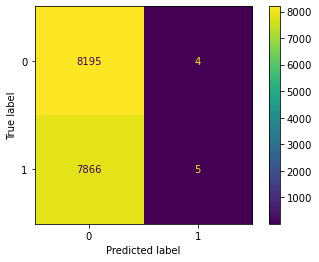

In [296]:
plot_confusion_matrix(myModel, x_test_std, y_test)

In [297]:
# performances
target_names = ['SLA', 'Violation']
print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

         SLA       0.51      1.00      0.68      8199
   Violation       0.56      0.00      0.00      7871

    accuracy                           0.51     16070
   macro avg       0.53      0.50      0.34     16070
weighted avg       0.53      0.51      0.35     16070



In [298]:
# Calculate mean squared error of predicted values
mse=mean_squared_error(y_test,y_predict)
rmse = np.sqrt(mse)
print("MSE:", mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, y_predict)
print("R2:", r2)
# Calculate absolute squared error of predicted values
mea=mean_absolute_error(y_test,y_predict)
print("MEA:", mea)

MSE: 0.4897324206596142
RMSE: 0.6998088457997756
R2: -0.9597461066032003
MEA: 0.4897324206596142


In [299]:
###############################
# GradientBoostingClassifier
###############################
myModel = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

In [300]:
# fit the model with x and y data
myModel.fit(x_train_std, y_train)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)

In [301]:
# Predict the values by using all test data
y_predict= myModel.predict(x_test_std)

In [302]:
accuracy_score(y_test, y_predict)

0.6293714996888612

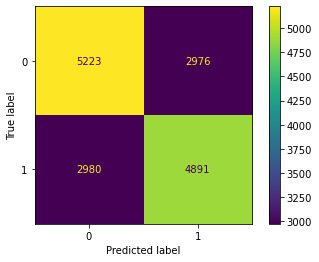

In [303]:
plot_confusion_matrix(myModel, x_test_std, y_test)

In [304]:
# performances
target_names = ['SLA', 'Violation']
print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

         SLA       0.64      0.64      0.64      8199
   Violation       0.62      0.62      0.62      7871

    accuracy                           0.63     16070
   macro avg       0.63      0.63      0.63     16070
weighted avg       0.63      0.63      0.63     16070



In [305]:
# Calculate mean squared error of predicted values
mse=mean_squared_error(y_test,y_predict)
rmse = np.sqrt(mse)
print("MSE:", mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, y_predict)
print("R2:", r2)
# Calculate absolute squared error of predicted values
mea=mean_absolute_error(y_test,y_predict)
print("MEA:", mea)

MSE: 0.37062850031113875
RMSE: 0.6087926578985153
R2: -0.48313186924125295
MEA: 0.37062850031113875


C: 0.001
Accuracy: 0.5762912258867455
              precision    recall  f1-score   support

         SLA       0.58      0.65      0.61      8199
   Violation       0.58      0.50      0.54      7871

    accuracy                           0.58     16070
   macro avg       0.58      0.57      0.57     16070
weighted avg       0.58      0.58      0.57     16070

C: 0.01
Accuracy: 0.5782202862476664
              precision    recall  f1-score   support

         SLA       0.58      0.65      0.61      8199
   Violation       0.58      0.51      0.54      7871

    accuracy                           0.58     16070
   macro avg       0.58      0.58      0.58     16070
weighted avg       0.58      0.58      0.58     16070

C: 0.1
Accuracy: 0.578531425015557
              precision    recall  f1-score   support

         SLA       0.58      0.65      0.61      8199
   Violation       0.58      0.51      0.54      7871

    accuracy                           0.58     16070
   macro avg      

<Figure size 720x720 with 0 Axes>

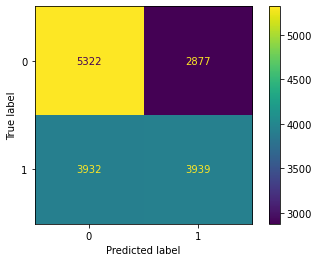

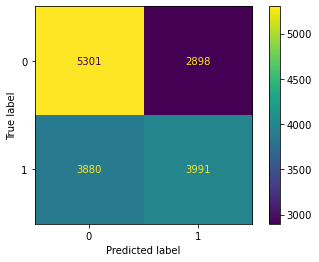

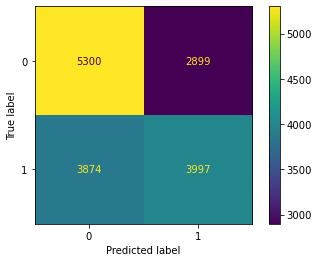

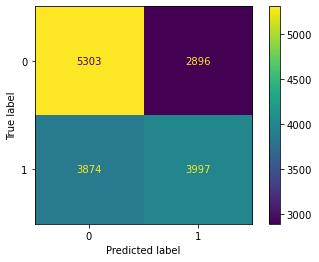

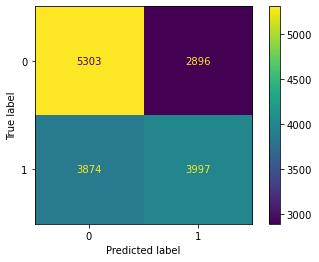

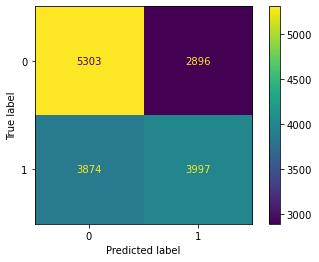

In [315]:
##################################################
# Classification with LogisticRegression algorithm
##################################################
c_param_range = [0.001,0.01,0.1,1,10,100]

model_acc_table = pd.DataFrame(columns = ['C_parameter','Accuracy'])
model_acc_table['C_parameter'] = c_param_range

plt.figure(figsize=(10, 10))

j = 0
for i in c_param_range:    
    # Apply logistic regression model to training data
    myModel = LogisticRegression(penalty = 'l2', C = i,random_state = 0)
    myModel.fit(x_train_std,y_train)
    
    # Predict using model
    y_predict = myModel.predict(x_test_std)
    
    # Saving accuracy score in table
    model_acc_table.iloc[j,1] = accuracy_score(y_test,y_predict)
    j += 1
    print("C:", i)
    print("Accuracy:", accuracy_score(y_test,y_predict))
    plot_confusion_matrix(myModel,x_test_std,y_test)
    # performances
    target_names = ['SLA', 'Violation']
    print(classification_report(y_test, y_predict, target_names=target_names))

C: 3
Accuracy: 0.5919726197884256
              precision    recall  f1-score   support

         SLA       0.60      0.60      0.60      8199
   Violation       0.58      0.58      0.58      7871

    accuracy                           0.59     16070
   macro avg       0.59      0.59      0.59     16070
weighted avg       0.59      0.59      0.59     16070

C: 5
Accuracy: 0.6014312383322962
              precision    recall  f1-score   support

         SLA       0.61      0.62      0.61      8199
   Violation       0.59      0.58      0.59      7871

    accuracy                           0.60     16070
   macro avg       0.60      0.60      0.60     16070
weighted avg       0.60      0.60      0.60     16070

C: 7
Accuracy: 0.6077162414436839
              precision    recall  f1-score   support

         SLA       0.61      0.62      0.62      8199
   Violation       0.60      0.59      0.60      7871

    accuracy                           0.61     16070
   macro avg       0.61   

<Figure size 720x720 with 0 Axes>

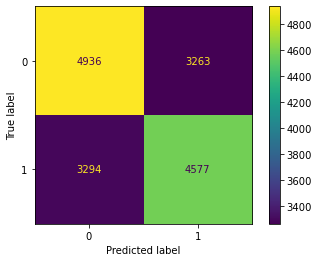

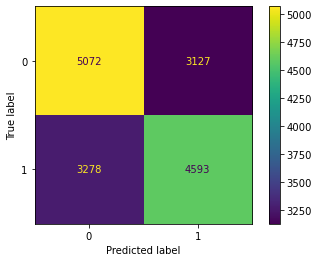

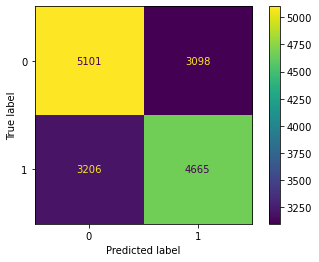

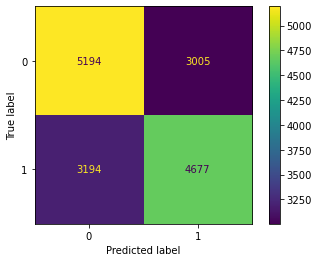

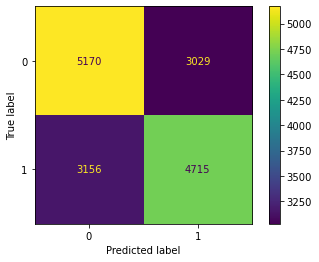

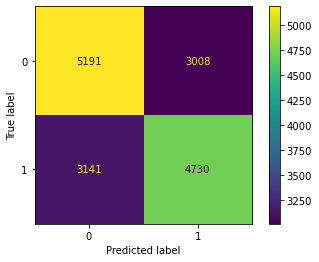

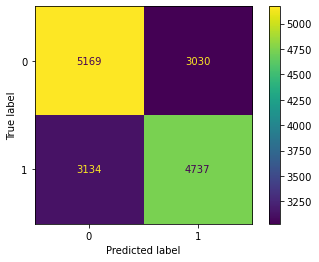

In [374]:
#######################################################
# Classification with KNeighborsClassifier algorithm
#######################################################
c_param_range = [3, 5, 7, 9, 11, 13, 15]

model_acc_table = pd.DataFrame(columns = ['C_parameter','Accuracy'])
model_acc_table['C_parameter'] = c_param_range

plt.figure(figsize=(10, 10))

j = 0
for i in c_param_range:    
    # Apply KNN regression model to training data
    myModel = KNeighborsClassifier(n_neighbors = i)
    myModel.fit(x_train_std,y_train)
    
    # Predict using model
    y_predict = myModel.predict(x_test_std)
    
    # Saving accuracy score in table
    model_acc_table.iloc[j,1] = accuracy_score(y_test,y_predict)
    j += 1
    print("C:", i)
    print("Accuracy:", accuracy_score(y_test,y_predict))
    plot_confusion_matrix(myModel,x_test_std,y_test)
    # performances
    target_names = ['SLA', 'Violation']
    print(classification_report(y_test, y_predict, target_names=target_names))